In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import sys

sys.path.append('..')

from flod.classifiers.bsvclassifier import BSVClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [2]:
def plot_contour(clf, colors):
    gx = np.linspace(min(X[:,0])-.2, max(X[:,0])+.2, 50)
    gy = np.linspace(min(X[:,1])-.2, max(X[:,1])+.2, 50)
    gX, gY = np.meshgrid(gx, gy)
    zs = np.array([clf._compute_r(np.array([x, y])) for x, y in zip(np.ravel(gX), np.ravel(gY))])
    gZ = zs.reshape(gX.shape)
    membership_contour = plt.contour(gX, gY, gZ, levels=(clf.radius_, ), colors='blue')
    plt.clabel(membership_contour, inline=1)

    plt.scatter(X[:,0], X[:,1], c=colors, alpha=.2)
    plt.show()

In [3]:
def print_report(clf, dataset):
    mistakes = sum(clf.predict(X))
    print(f'c: {clf.c}, q: {clf.q}')

    count = 0
    for b in clf.betas_:
        if not np.isclose(b, 0):
                    count+=1

    print(f'Support vectors are {count}, over {len(dataset)} candidates')
    print(f'Mistakes {mistakes}/{len(dataset)} = {mistakes/len(dataset)*100}%')

# FLOD goes federated over synthetic data

In this notebook we want to answer the following question:
"Can different clients build a sphere that contains everybody's data?"

There is a fundamental issue in this test:
there are no outliers, so the naive 100% correct sphere would be the simplest and biggest one that can fit the space.

## 1. Single client scenario

We generate a synthetic dataset. 
All the points have label 0, since 1 means the points is an outlier.

With multiple centers, a low std is harder than a large one.

I have tested with centers from 1 to 5 and with std up to 2.
I also tried to raise the number of samples, but soon we hit the limit of how many points gurobi can handle

In [4]:
X, y = make_blobs(n_samples=1000, centers=5, n_features=2, cluster_std=1.0)
y = [0] * len(X)

In [5]:
X

array([[4.49862348, 8.81826037],
       [1.47027958, 3.64860657],
       [6.2170726 , 1.63017653],
       ...,
       [5.70427703, 2.7932272 ],
       [5.53254873, 9.53864142],
       [6.50517778, 1.91601119]])

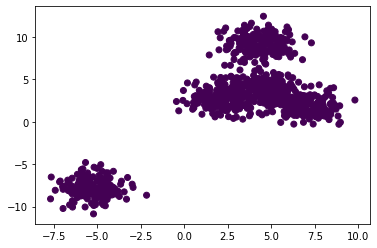

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

Let's see if we can create a sphere containing all the points with our implementation of the classifier.

In [7]:
params = {
    'q': uniform(0.0001, 20),
    'c': uniform()    
}
clf = RandomizedSearchCV(BSVClassifier(), params, cv=2, n_jobs=-1, refit='f1', verbose=10, return_train_score=False, n_iter=50)
clf.fit(X, y)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  2.2min remaining:    5.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished


Academic license - for non-commercial use only - expires 2021-06-25
Using license file /Users/maxfrax/gurobi.lic
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 1000 columns and 1000 nonzeros
Model fingerprint: 0xddc8d692
Model has 345355 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [6e-02, 6e-02]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.04s
Presolved: 1 rows, 1000 columns, 1000 nonzeros
Presolved model has 345355 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free

RandomizedSearchCV(cv=2, estimator=BSVClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'c': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbfb30c9bd0>,
                                        'q': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbfa0b98c50>},
                   refit='f1', verbose=10)

Theoretically, in the following plot there should be only one color, the one representing the points classified to 0.

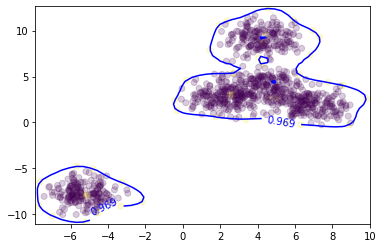

In [8]:
best_clf = clf.best_estimator_

plot_contour(best_clf, best_clf.predict(X))

In [9]:
print_report(best_clf, X)

c: 0.06327393727360076, q: 0.2401350912800353
Support vectors are 179, over 1000 candidates
Mistakes 42/1000 = 4.2%


Some times even this baseline does around 20% of mistakes.

## 2. Multiple client scenario

Let's split randomly the data generated before among k clients

In [10]:
clients = 5
points_per_client = int(len(X) / clients)

In [11]:
k = [X[i*points_per_client: (i+1)*points_per_client] for i in range(clients)]

colors = [int(i/points_per_client) for i in range(len(X))]

Let's plot again the previous plot, but this time the colors represent the client assignment

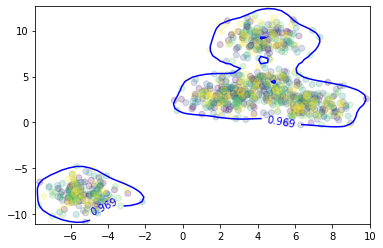

In [12]:
best_clf = clf.best_estimator_
plot_contour(best_clf, colors)

### Federated primitives

#### 1. Init server model

In [13]:
def init_server_model():
    return {
        'q': 1,
        'C': 1,
        'betas': np.empty(shape=(0, 2)),
        'xs': np.empty(shape=(0, 2))
    }

#### 2. Client update

In [14]:
def client_compute_update(global_model, client_data):
    # Concat points from server and from client
    X = np.concatenate((global_model['xs'], client_data))
    # Init the classifier with q and C from server
    clf = BSVClassifier(q=global_model['q'], c=global_model['C'])
    # Train locally
    clf.fit(X, [0]*len(X))
    # Select only the positive betas related from client_data
    client_betas = clf.betas_[len(global_model['xs']):]
    assert(len(client_betas) == len(client_data))
    
    for i, t in enumerate(zip(client_betas, client_data)):
        b, x = t
        if not np.isclose(b, 0):
            yield x
    

#### 3. Server combines client updates

In [15]:
def global_combine(global_model, client_updates):
    # Concatenates server points and clients candidate points.
    X = np.concatenate((global_model['xs'], *client_updates))
    
    # Performs model selection over this new dataset
    # Cross validation is low because I want to fit exactly the data I have got
    clf = RandomizedSearchCV(BSVClassifier(), params, cv=2, n_jobs=-1, refit='f1', verbose=10, return_train_score=False, n_iter=50)
    clf.fit(X, [0] * len(X))
    
    # Filter and keep only the support vectors
    xs = []
    betas = []
    for i, t in enumerate(zip(clf.best_estimator_.betas_, X)):
        b, x = t
        if not np.isclose(b, 0):
            xs.append(x)
            betas.append(b)
            
    return {
        'q': clf.best_estimator_.q,
        'C': clf.best_estimator_.c,
        'betas': betas,
        'xs': xs
    }, clf.best_estimator_

## Federated Learning simulation with one pass on data

In [16]:
import threading

number_of_rounds = 20

server_model = init_server_model()

# Metrics
debug_sk_models = []
debug_models = []
mistakes = []

client_updates = []

points_per_round = int(points_per_client / number_of_rounds)

def client_worker(client, round_ix):
    dataset = k[client]
    # Pick a data slice
    dataset = dataset[points_per_round*round_ix : points_per_round*(round_ix+1),:]
    update = client_compute_update(server_model, dataset)
    update = np.array(list(update))
    if update.size > 0:
        client_updates.append(update)

for r in tqdm(range(number_of_rounds)):
    client_updates = []
    threads = []
    for client in range(clients):
        t = threading.Thread(target=client_worker, args=(client, r))
        threads.append(t)
        t.start()
        
    for t in threads:
        t.join()
        
    server_model, debug_model = global_combine(server_model, client_updates)
    mistakes.append(sum(debug_model.predict(X)))
    debug_models.append(server_model)
    debug_sk_models.append(debug_model)

  0%|          | 0/20 [00:00<?, ?it/s]

Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
Changed value of parameter NonConvex

   4   2.24870548e+00  4.54761277e+02  7.65e-01 1.45e-10  5.74e+01     0s
   6   8.87519783e-01  2.36165172e+01  1.25e-02 5.08e-13  1.15e+00     0s
   8   8.69400852e-01  1.18334775e+00  1.48e-04 8.88e-15  1.57e-02     0s
   7   8.77418794e-01  3.22777860e+00  1.28e-03 5.18e-14  1.18e-01     0s
   5   9.73624459e-01  1.98129154e+02  7.58e-02 1.44e-11  1.14e+01     0s
   7   8.17946314e-01  3.12054882e+00  1.34e-03 1.37e-13  1.15e-01     0s
   7   8.49434892e-01  4.08864260e+00  1.04e-03 1.38e-13  1.62e-01     0s
   9   8.74682762e-01  9.14120249e-01  1.53e-05 9.44e-16  1.97e-03     0s
   8   8.79205528e-01  1.16970262e+00  1.37e-04 5.55e-15  1.45e-02     0s
  10   8.75229555e-01  8.79616123e-01  1.53e-06 9.71e-17  2.19e-04     0s
   8   8.27791599e-01  1.15355747e+00  1.49e-04 1.53e-14  1.63e-02     0s
   6   8.39420371e-01  2.35891047e+01  7.51e-03 1.42e-12  1.16e+00     0s
   8   8.50800962e-01  1.25776215e+00  1.17e-04 1.55e-14  2.04e-02     0s
   9   8.83429696e-01  9.19813560e-01 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0555s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1970s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:    0.6s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 50 columns and 50 nonzeros
Model fingerprint: 0xce4445ec
Model has 608 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [9e-01, 9e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 50 columns, 50 nonzeros
Presolved model has 608 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 47
 AA' NZ     : 7.590e+02
 Factor NZ  : 8.140e+02
 Factor Ops : 2.068e+04 (less than 1 second per iteration)
 Threads

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished


Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Changed value of parameter NonConvex to 2
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NonConvex to 2
Changed value of parameter NumericFocus to 3
   Prev: -1  Min: -1  Max: 2  Default: -1
   Prev: -1  Min: -1  Max: 2  Default: -1
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  De

   8   9.54908561e-01  4.55544680e+00  5.77e-04 6.76e-06  3.00e-02     0s
   4   7.81314253e+00  1.97146635e+04  3.49e+00 5.81e-02  2.43e+02     0s
   5   1.89591723e+00  3.60639262e+03  4.73e-01 7.83e-03  3.69e+01     0s
   8   9.53088239e-01  6.51540733e+00  4.61e-04 7.68e-06  4.64e-02     0s
   5   2.70225567e+00  5.10971625e+03  4.38e-01 1.77e-02  5.58e+01     0s
   5   1.88430104e+00  3.59389357e+03  4.65e-01 7.73e-03  3.67e+01     0s
   6   1.04326858e+00  5.36754149e+02  4.69e-02 7.76e-04  4.67e+00     0s
   9   9.56571141e-01  1.38269049e+00  6.39e-05 7.49e-07  3.55e-03     0s
  10   9.63449435e-01  1.01597787e+00  6.91e-06 8.10e-08  4.38e-04     0s
   7   9.58686966e-01  5.58458915e+01  4.65e-03 7.69e-05  4.60e-01     0s
   6   1.11849095e+00  8.23914984e+02  4.34e-02 1.76e-03  7.43e+00     0s
   6   1.04775928e+00  5.33855065e+02  4.61e-02 7.66e-04  4.64e+00     0s
  11   9.64786956e-01  9.71572517e-01  8.17e-07 9.56e-09  5.66e-05     0s
   9   9.53959958e-01  1.59156092e+00 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0655s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.4s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 99 columns and 99 nonzeros
Model fingerprint: 0x4b31c197
Model has 2631 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [2e-01, 2e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 99 columns, 99 nonzeros
Presolved model has 2631 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 97
 AA' NZ     : 3.301e+03
 Factor NZ  : 3.417e+03
 Factor Ops : 1.760e+05 (less than 1 second per iteration)
 Threa

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    1.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
   Prev: 0  Min: 0  Max: 3  Default: 0
Optimize a model with 1 rows, 103 columns and 103 nonzeros
Changed value of parameter NonConvex to 2
Model fingerprint: 0x2104ed93
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter ObjScale to -0.5
Model has 2861 quadratic objective terms
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Coefficient statistics:
Changed value of parameter NumericFocus to 3
  Matrix range     [1e+00, 1e+00]
Gurobi Optimizer version

   4   1.10044812e+01  1.24963423e+04  1.01e+01 4.72e-02  1.46e+02     0s
   3   1.09001326e+02  1.54981567e+04  5.44e+01 8.71e-01  1.11e+03     0s
  12   9.65002848e-01  9.67317496e-01  1.56e-07 5.02e-10  1.12e-05     0s
   8   9.50990033e-01  7.07743616e+00  9.91e-04 4.73e-06  2.98e-02     0s
   2   9.83109035e+02  1.61468833e+04  1.02e+03 4.89e+00  1.01e+04     0s
   9   9.52006297e-01  1.66925379e+00  1.11e-04 5.29e-07  3.48e-03     0s
  13   9.65240013e-01  9.65643795e-01  1.54e-08 4.97e-11  1.96e-06     0s
   4   1.33529681e+01  1.18461677e+04  6.21e+00 9.94e-02  1.60e+02     0s
   5   1.94435310e+00  3.68641254e+03  9.98e-01 4.68e-03  2.29e+01     0s
   3   1.02060456e+02  1.57122563e+04  1.02e+02 4.85e-01  1.05e+03     0s
  14   9.65321999e-01  9.65382979e-01  1.53e-09 4.93e-12  2.96e-07     0s
   5   2.17752333e+00  4.17958080e+03  6.15e-01 9.85e-03  2.69e+01     0s
  10   9.63000493e-01  1.06000965e+00  1.31e-05 6.23e-08  4.71e-04     0s
   6   1.04535710e+00  5.85760522e+02 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    3.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 142 columns and 142 nonzeros
Model fingerprint: 0x97f76013
Model has 4606 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [9e-01, 9e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 142 columns, 142 nonzeros
Presolved model has 4606 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 140
 AA' NZ     : 6.277e+03
 Factor NZ  : 6.742e+03
 Factor Ops : 4.818e+05 (less than 1 second per iteration)
 


 Factor Ops : 5.778e+05 (less than 1 second per iteration)
   0  -2.62820422e+05  6.63911294e+05  1.55e+04 8.01e+02  1.00e+06     0s
Barrier statistics:
 Threads    : 1
   3  -4.59077433e+02  1.13320403e+05  1.81e+01 1.40e+00  1.79e+03     0s
   1   2.27286601e+04  1.24938497e+05  1.55e+03 8.03e+01  1.01e+05     0s
 Free vars  : 150
Ordering time: 0.00s
 AA' NZ     : 7.176e+03

   4  -2.35729164e+02  7.72930153e+04  4.35e+00 3.36e-01  5.60e+02     0s
   2   2.78691128e+03  1.18037643e+05  1.61e+02 8.34e+00  1.07e+04     0s
 Factor NZ  : 7.469e+03
                  Objective                Residual
 Factor Ops : 5.409e+05 (less than 1 second per iteration)

Iter       Primal          Dual         Primal    Dual     Compl     Time
   3  -2.35169278e+02  1.07202125e+05  2.19e+01 1.13e+00  1.67e+03     0s
   5   8.84178135e+00  1.96645149e+04  4.64e-01 3.58e-02  9.75e+01     0s
 Threads    : 1
Barrier statistics:
   4  -2.64597791e+02  7.62891978e+04  5.19e+00 2.68e-01  5.33e+02     0s
  

  18   9.73234314e-01  9.73236432e-01  1.62e-12 1.08e-13  6.97e-09     0s
  19   9.73234875e-01  9.73235132e-01  1.87e-13 2.55e-14  8.48e-10     0s
  20   9.73688267e-01  9.73688337e-01  2.58e-14 2.18e-15  2.30e-10     0s

Barrier solved model in 21 iterations and 0.09 seconds
  20   9.73234947e-01  9.73234974e-01  1.96e-14 1.33e-15  9.03e-11     0s
Optimal objective 9.73558513e-01
  21   9.73688282e-01  9.73688289e-01  2.58e-15 2.66e-15  2.39e-11     0s

  21   9.73234955e-01  9.73234958e-01  3.79e-15 4.04e-15  9.23e-12     0s


Barrier solved model in 21 iterations and 0.09 seconds
Optimal objective 9.73234955e-01
Barrier solved model in 21 iterations and 0.09 seconds

Optimal objective 9.73688282e-01

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    5.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 183 columns and 183 nonzeros
Model fingerprint: 0xded11797
Model has 16836 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [6e-05, 4e+00]
  Bounds range     [8e-01, 8e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 183 columns, 183 nonzeros
Presolved model has 16836 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 76
 AA' NZ     : 2.926e+03
 Factor NZ  : 3.003e+03
 Factor Ops : 1.552e+05 (less than 1 second per iteration)



   1  -1.68419399e+03  1.84205786e+04  1.07e+03 9.91e+01  1.00e+05     0s
                  Objective                Residual
   1   8.22077946e+03  1.28370934e+04  1.14e+03 3.82e+01  1.00e+05     0s
Iter       Primal          Dual         Primal    Dual     Compl     Time
                  Objective                Residual
   2   2.78928226e+02  1.33527315e+04  1.08e+02 1.00e+01  1.04e+04     0s
Iter       Primal          Dual         Primal    Dual     Compl     Time
   2   9.99514792e+02  1.07677513e+04  1.14e+02 3.84e+00  1.03e+04     0s
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.58578226e+05  3.20907970e+05  1.07e+04 6.12e+02  1.00e+06     0s
   3   2.43741436e+01  1.22325648e+04  1.27e+01 1.18e+00  1.43e+03     0s
   3   8.67304696e+01  1.00421117e+04  1.21e+01 4.05e-01  1.26e+03     0s
   1   1.91368294e+03  1.54032032e+04  1.07e+03 6.13e+01  1.00e+05     0s
   0  -3.69119068e+05  4.15568736e+05  9.29e+03 7.99e+02  1.00e+06     0s
   0  -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0125s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0578s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0665s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.2s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 17 columns and 17 nonzeros
Model fingerprint: 0x6d5a530c
Model has 107 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [4e-01, 4e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 17 columns, 17 nonzeros
Presolved model has 107 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 16
 AA' NZ     : 1.150e+02
 Factor NZ  : 1.530e+02
 Factor Ops : 1.785e+03 (less than 1 second per iteration)
 Threads

[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
Changed value of parameter NonConvex to 2
Changed value of parameter NonConvex to 2
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: -1  Min: -1  Max: 2  Default: -1
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
   Prev: 0  Mi

   4   3.20806202e+00  5.85016041e+03  2.36e+00 8.23e-02  1.93e+02     0s
   6   9.09122536e-01  2.03582302e+02  2.00e-02 1.41e-03  4.32e+00     0s
   7   8.59043628e-01  2.13389132e+01  2.00e-03 9.51e-05  4.28e-01     0s
   9   8.76049763e-01  1.07918222e+00  3.07e-05 7.41e-07  4.23e-03     0s
   5   1.60074967e+00  1.89807065e+03  1.31e-01 1.94e-02  5.20e+01     0s
   5   1.09218202e+00  1.19155886e+03  2.34e-01 8.16e-03  2.76e+01     0s
   7   8.73087323e-01  2.13187997e+01  2.00e-03 1.41e-04  4.27e-01     0s
  10   8.80698101e-01  9.10153472e-01  3.92e-06 9.47e-08  6.14e-04     0s
   6   9.14594721e-01  3.19465641e+02  1.29e-02 1.93e-03  6.97e+00     0s
  11   8.82786245e-01  8.86856100e-01  3.88e-07 9.38e-09  8.48e-05     0s
   6   8.82134531e-01  1.36265220e+02  2.31e-02 8.09e-04  2.86e+00     0s
   8   8.56322841e-01  3.12765046e+00  2.19e-04 1.04e-05  4.73e-02     0s
   7   8.41879613e-01  3.36832957e+01  1.29e-03 1.93e-04  6.88e-01     0s
   8   8.70498455e-01  3.10938142e+00 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0559s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1588s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 55 columns and 55 nonzeros
Model fingerprint: 0x5749f6a8
Model has 1052 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [4e-01, 4e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 55 columns, 55 nonzeros
Presolved model has 1052 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 54
 AA' NZ     : 1.287e+03
 Factor NZ  : 1.380e+03
 Factor Ops : 4.626e+04 (less than 1 second per iteration)
 Threa

 Threads    : 1
Iter       Primal          Dual         Primal    Dual     Compl     Time
Iter       Primal          Dual         Primal    Dual     Compl     Time
 Factor Ops : 1.383e+04 (less than 1 second per iteration)


 Threads    : 1
   0  -1.80215147e+05  2.35936880e+05  1.05e+04 4.20e+02  1.00e+06     0s
                  Objective                Residual
   0  -1.47027717e+05  1.97346213e+05  3.60e+04 3.56e+02  1.00e+06     0s
                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time

   1   1.92277755e+03  1.60316240e+04  1.06e+03 4.25e+01  1.01e+05     0s
                  Objective                Residual
   0  -3.36200250e+05  3.94621225e+05  1.12e+04 7.09e+02  1.00e+06     0s
Iter       Primal          Dual         Primal    Dual     Compl     Time
   1   1.75691810e+03  1.61535680e+04  3.60e+03 3.56e+01  1.00e+05     0s
   2   4.05874032e+02  1.36557871e+04  1.07e+02 4.29e+00  1.04e+04     0s
Iter      

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0562s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 66 columns and 66 nonzeros
Model fingerprint: 0xa5162928
Model has 1656 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [8e-01, 8e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 66 columns, 66 nonzeros
Presolved model has 1656 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 65
 AA' NZ     : 2.103e+03
 Factor NZ  : 2.211e+03
 Factor Ops : 9.802e+04 (less than 1 second per iteration)
 Threa

                  Objective                Residual

 AA' NZ     : 1.540e+03
 Threads    : 1
Iter       Primal          Dual         Primal    Dual     Compl     Time
 Factor NZ  : 1.596e+03
   0  -8.18008538e+04  1.81272705e+05  5.60e+04 2.75e+02  1.00e+06     0s
                  Objective                Residual

   0  -1.66208707e+05  2.66568539e+05  2.83e+04 4.43e+02  1.00e+06     0s
   1   4.22019437e+03  4.47945302e+04  5.60e+03 2.75e+01  1.00e+05     0s
 Factor Ops : 6.012e+04 (less than 1 second per iteration)
                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
 Threads    : 1
   1   3.42683184e+03  4.60266065e+04  2.83e+03 4.44e+01  1.00e+05     0s
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.13067517e+05  2.13427317e+05  2.82e+04 3.37e+02  1.00e+06     0s
   2   5.46731330e+02  4.28548835e+04  5.60e+02 2.74e+00  1.03e+04     0s

   0  -8.18886993e+04  1.81636646e+0


Barrier solved model in 19 iterations and 0.06 seconds
Optimal objective 9.00483189e-01

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0233s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1945s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    1.0s remaining:    0.0s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 70 columns and 70 nonzeros
Model fingerprint: 0x40bb5e8b
Model has 749 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [3e-02, 3e-02]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 70 columns, 70 nonzeros
Presolved model has 749 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 67
 AA' NZ     : 9.690e+02
 Factor NZ  : 1.156e+03
 Factor Ops : 2.655e+04 (less than 1 second per iteration)
 Threads

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
   Prev: -1  Min: -1  Max: 2  Default: -1
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Changed value of parameter NonConvex to 2
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
Optimize a model with 1 rows, 79 columns and 79 nonzeros
   Prev: 0.0  Min: -1.0  Max

   5   1.72734770e+00  1.83139727e+03  7.59e-01 7.81e-03  1.89e+01     0s
   3   7.73024017e+01  2.47006809e+03  7.73e+01 8.65e-01  1.00e+03     0s
   5   1.72632324e+00  1.83133392e+03  7.59e-01 4.86e-03  1.89e+01     0s
   5   1.72621981e+00  1.83141571e+03  7.59e-01 7.31e-03  1.89e+01     0s
  12   9.79184695e-01  9.80285163e-01  1.02e-07 1.16e-09  6.97e-06     0s
   6   1.04400001e+00  4.48718620e+02  7.52e-02 7.74e-04  3.02e+00     0s
   4   8.61423217e+00  2.39712522e+03  7.66e+00 8.58e-02  1.10e+02     0s
   6   1.04298691e+00  4.48663637e+02  7.52e-02 4.82e-04  3.02e+00     0s
  13   9.79252108e-01  9.79398645e-01  1.15e-08 1.30e-10  9.28e-07     0s
   6   1.04283445e+00  4.48734353e+02  7.52e-02 7.25e-04  3.02e+00     0s
   7   9.76276609e-01  4.65772086e+01  7.45e-03 7.67e-05  2.90e-01     0s
   5   1.72678766e+00  1.83142512e+03  7.59e-01 8.50e-03  1.89e+01     0s
   7   9.75266016e-01  4.65701364e+01  7.45e-03 4.78e-05  2.90e-01     0s
   6   1.04341718e+00  4.48742146e+02 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1748s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.9s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 119 columns and 119 nonzeros
Model fingerprint: 0xa5c4c2b9
Model has 4428 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [6e-01, 6e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 119 columns, 119 nonzeros
Presolved model has 4428 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 117
 AA' NZ     : 5.163e+03
 Factor NZ  : 5.321e+03
 Factor Ops : 3.507e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter ObjScale to -0.5
Changed value of parameter NonConvex to 2
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter ObjScale to -0.5
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter NumericFocus to 3
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Changed value of parameter ObjScale to -0.5
Gurobi Optimizer version 9.1.2 build v9.1.2rc

   7   9.54700291e-01  1.47740004e+02  3.00e-03 1.01e-04  7.08e-01     0s
   7   9.54085570e-01  1.52199179e+02  2.66e-03 9.78e-05  7.28e-01     0s
   3   1.27939552e+02  5.42636155e+04  2.40e+01 7.41e-01  1.63e+03     0s
   8   9.32913326e-01  1.58011375e+01  3.01e-04 1.01e-05  7.09e-02     0s
   2   1.08649759e+03  6.21116925e+04  2.84e+02 4.21e+00  1.07e+04     0s
   4   2.12636599e+01  3.51739841e+04  3.16e+00 9.76e-02  3.26e+02     0s
  10   9.48413450e-01  1.19965826e+00  4.78e-06 1.38e-07  1.20e-03     0s
   8   9.35032071e-01  1.62530031e+01  2.67e-04 9.80e-06  7.30e-02     0s
  11   9.60956836e-01  1.00349045e+00  4.91e-07 1.42e-08  2.03e-04     0s
   9   9.33388416e-01  2.57219027e+00  3.19e-05 1.07e-06  7.81e-03     0s
   3   1.39257807e+02  5.57336044e+04  3.55e+01 5.27e-01  1.50e+03     0s
   9   9.35492914e-01  2.61900101e+00  2.82e-05 1.04e-06  8.02e-03     0s
   5   3.41545279e+00  7.50697518e+03  3.14e-01 9.71e-03  4.81e+01     0s
  12   9.64175775e-01  9.71330129e-01 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    2.7s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 135 columns and 135 nonzeros
Model fingerprint: 0xd223743c
Model has 5807 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [3e-01, 3e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 135 columns, 135 nonzeros
Presolved model has 5807 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 133
 AA' NZ     : 7.009e+03
 Factor NZ  : 7.173e+03
 Factor Ops : 5.564e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    3.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 141 columns and 141 nonzeros
Model fingerprint: 0xb4bca883
Model has 6353 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [3e-01, 3e-01]
Changed value of parameter ObjScale to -0.5
  RHS range        [1e+00, 1e+00]
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter ObjScale to -0.5
Changed value of parameter NumericFocus to 3
Changed value of parameter ObjScale to -0.5
Presolve time: 0.24s
Changed value of parameter ObjScale to 

   3   1.75494365e+02  3.93923160e+04  2.36e+01 5.56e-01  1.50e+03     0s
   3   1.55348748e+02  3.79167343e+04  2.33e+01 5.52e-01  1.31e+03     0s
   1   9.08678776e+03  4.73359311e+04  6.98e+03 6.04e+01  1.00e+05     0s
   4  -4.20136294e+01  3.21063424e+04  5.07e+00 1.20e-01  3.45e+02     0s
   4   2.65601483e+01  3.13815349e+04  2.91e+00 6.86e-02  2.65e+02     0s
   2   1.36461446e+03  4.23042022e+04  7.07e+02 6.12e+00  1.03e+04     0s
  19   9.64313810e-01  9.64314122e-01  6.80e-14 1.78e-15  1.11e-09     0s
   3   1.95700493e+02  3.66719828e+04  2.31e+01 4.86e-01  1.33e+03     0s
   5   6.41762260e+00  1.50270664e+04  6.81e-01 1.61e-02  8.34e+01     0s
   5   4.01190334e+00  1.10185494e+04  3.11e-01 7.32e-03  5.29e+01     0s
   4   7.41753487e+00  2.91139666e+04  3.91e+00 8.22e-02  2.85e+02     0s
   3   1.48050813e+02  4.01888566e+04  7.39e+01 6.40e-01  1.17e+03     0s
   6   1.70004273e+00  2.42670348e+03  6.74e-02 1.60e-03  1.08e+01     0s
  20   9.64313889e-01  9.64313921e-01 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    4.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.4s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 167 columns and 167 nonzeros
Model fingerprint: 0xe3a6d19c
Model has 10509 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [1e-01, 1e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 167 columns, 167 nonzeros
Presolved model has 10509 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 158
 AA' NZ     : 9.422e+03
 Factor NZ  : 9.630e+03
 Factor Ops : 8.381e+05 (less than 1 second per iteration)

 Threads    : 1

   1   1.09563192e+04  2.03561479e+04  3.83e+03 8.65e+01  1.00e+05     0s
  Objective range  [1e+00, 1e+00]
   2   1.52910788e+03  1.59028837e+04  3.90e+02 6.21e+00  1.01e+04     0s
Barrier statistics:
  QObjective range [1e-13, 4e+00]

   2   1.49736878e+03  1.60219935e+04  3.85e+02 8.70e+00  1.01e+04     0s
   3   1.63440277e+02  1.56158661e+04  4.08e+01 6.49e-01  1.09e+03     0s
  Bounds range     [1e-01, 1e-01]
 Free vars  : 141
                  Objective                Residual
  RHS range        [1e+00, 1e+00]
 AA' NZ     : 7.578e+03
Iter       Primal          Dual         Primal    Dual     Compl     Time
   3   1.61163460e+02  1.57184870e+04  4.02e+01 9.09e-01  1.09e+03     0s
 Factor NZ  : 7.780e+03
   4   2.39612017e+01  1.16990753e+04  5.82e+00 9.26e-02  1.68e+02     0s
   0  -9.89550119e+04  2.77696867e+05  3.95e+04 5.16e+02  1.00e+06     0s
 Factor Ops : 6.062e+05 (less than 1 second per iteration)
   4   2.41745795e+01  1.21745216e+04  5.85e+00 1.32e-01 

  19   9.41496560e-01  9.41496745e-01  2.00e-14 4.44e-16  6.18e-10     0s
  11   9.34024584e-01  9.88697624e-01  9.22e-07 1.29e-08  1.82e-04     0s
Optimal objective 9.42812302e-01
Optimal objective 9.41269223e-01
  20   9.41496613e-01  9.41496632e-01  2.78e-15 4.44e-16  6.28e-11     0s
  12   9.39822846e-01  9.50489498e-01  1.00e-07 1.40e-09  3.56e-05     0s



  13   9.40932488e-01  9.43047378e-01  1.01e-08 1.42e-10  7.05e-06     0s
  14   9.41166385e-01  9.41592159e-01  1.35e-09 1.89e-11  1.42e-06     0s
Barrier solved model in 20 iterations and 0.09 seconds
Optimal objective 9.41496613e-01
  15   9.41237928e-01  9.41355351e-01  1.44e-10 2.02e-12  3.91e-07     0s

  16   9.41264069e-01  9.41290627e-01  1.50e-11 2.10e-13  8.85e-08     0s
  17   9.41270453e-01  9.41275835e-01  1.52e-12 2.15e-14  1.79e-08     0s
  18   9.41271761e-01  9.41272994e-01  3.13e-13 3.71e-15  4.11e-09     0s
  19   9.41272116e-01  9.41272337e-01  4.29e-14 7.91e-16  7.36e-10     0s
  20   9.41272182e-01  9.412

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    4.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.7s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 169 columns and 169 nonzeros
Model fingerprint: 0xbe7cf72d
Model has 10015 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [9e-01, 9e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 169 columns, 169 nonzeros
Presolved model has 10015 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 165
 AA' NZ     : 1.038e+04
 Factor NZ  : 1.061e+04
 Factor Ops : 9.721e+05 (less than 1 second per iteration)

Ordering time: 0.00s
                  Objective                Residual
   2   1.62376268e+03  1.47079068e+05  8.50e+02 9.25e+00  1.08e+04     0s
Iter       Primal          Dual         Primal    Dual     Compl     Time


   0  -3.44748955e+05  6.60690995e+05  4.14e+04 5.23e+02  1.00e+06     0s

                  Objective                Residual
Barrier statistics:
   3   1.82000687e+02  1.23793539e+05  9.16e+01 9.96e-01  1.40e+03     0s
Iter       Primal          Dual         Primal    Dual     Compl     Time
Barrier statistics:
 Free vars  : 161
   1   1.14796524e+04  1.55136277e+05  4.16e+03 5.26e+01  1.01e+05     0s
   0  -4.54855180e+05  7.86819231e+05  2.64e+04 7.77e+02  1.00e+06     0s
 Free vars  : 161
   4   1.95325397e+01  5.00014179e+04  9.47e+00 1.03e-01  2.31e+02     0s
 AA' NZ     : 1.014e+04
 AA' NZ     : 9.847e+03
 Factor NZ  : 1.050e+04
   2   1.71719695e+03  1.47707400e+05  4.47e+02 5.64e+00  1.11e+04     0s
   1   1.23604501e+04  1.50270298e+05  2.65e+03 7.80e+01  


Optimal objective 9.64475358e-01
  19   9.64443056e-01  9.64443138e-01  2.37e-14 1.78e-15  2.49e-10     0s
Barrier solved model in 20 iterations and 0.09 seconds

  18   9.64625555e-01  9.64629839e-01  3.01e-12 4.59e-14  1.30e-08     0s
Optimal objective 9.64492502e-01
  20   9.64443081e-01  9.64443089e-01  2.23e-15 4.28e-15  2.50e-11     0s
  19   9.64626678e-01  9.64627231e-01  3.42e-13 6.61e-15  1.68e-09     0s


  20   9.64626835e-01  9.64626901e-01  3.56e-14 8.88e-16  2.01e-10     0s
Barrier solved model in 20 iterations and 0.08 seconds
  21   9.64626854e-01  9.64626860e-01  3.55e-15 1.33e-15  2.01e-11     0s
Optimal objective 9.64443081e-01


Barrier solved model in 21 iterations and 0.10 seconds
Optimal objective 9.64626854e-01

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    5.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 195 columns and 195 nonzeros
Model fingerprint: 0x95499d83
Model has 9655 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [1e-02, 1e-02]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 195 columns, 195 nonzeros
Presolved model has 9655 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 193
 AA' NZ     : 1.334e+04
 Factor NZ  : 1.394e+04
 Factor Ops : 1.413e+06 (less than 1 second per iteration)
 

Presolve time: 0.01s
   5   2.91727530e+00  2.13541511e+03  4.91e-01 5.21e-03  1.46e+01     0s
  Bounds range     [1e-02, 1e-02]
   0  -1.57846477e+05  3.46354384e+05  1.86e+05 4.18e+02  1.00e+06     0s
   0  -1.87271790e+05  3.76979076e+05  1.87e+05 4.80e+02  1.00e+06     0s
  RHS range        [1e+00, 1e+00]
Presolved: 1 rows, 189 columns, 189 nonzeros
Presolved model has 9383 quadratic objective terms
   6   1.15001890e+00  9.46506367e+02  4.86e-02 5.16e-04  2.91e+00     0s
   1   1.51638743e+04  5.95206013e+03  1.86e+04 4.18e+01  1.00e+05     0s
   1   1.49817267e+04  6.20861321e+03  1.87e+04 4.80e+01  1.00e+05     0s
Presolve time: 0.01s
   7   9.74981347e-01  1.11017307e+02  4.82e-03 5.11e-05  2.96e-01     0s
Presolved: 1 rows, 189 columns, 189 nonzeros
   2   1.82633076e+03  2.54530164e+03  1.86e+03 4.18e+00  1.00e+04     0s
Ordering time: 0.00s
Presolved model has 9253 quadratic objective terms
   2   1.83574302e+03  2.49770842e+03  1.87e+03 4.80e+00  1.00e+04     0s
   8   9.57

  18   9.79897743e-01  9.79897820e-01  2.42e-13 6.16e-16  2.04e-10     0s
Optimal objective 9.80352498e-01

  19   9.79897771e-01  9.79897779e-01  2.49e-14 2.22e-16  2.06e-11     0s

Barrier solved model in 19 iterations and 0.10 seconds
Optimal objective 9.79897771e-01

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    7.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.8s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 225 columns and 225 nonzeros
Model fingerprint: 0x1a3a1926
Model has 19777 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [9e-01, 9e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 225 columns, 225 nonzeros
Presolved model has 19777 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 183
 AA' NZ     : 1.674e+04
 Factor NZ  : 1.702e+04
 Factor Ops : 2.093e+06 (less than 1 second per iteration)

Ordering time: 0.00s
Presolved model has 7853 quadratic objective terms
Presolved: 1 rows, 140 columns, 140 nonzeros
Presolved model has 8187 quadratic objective terms
   5   2.92836757e+00  7.84275758e+03  8.27e-01 1.45e-02  3.62e+01     0s
Presolved model has 8083 quadratic objective terms

Barrier statistics:
Ordering time: 0.00s
Ordering time: 0.00s
   6   9.73372068e-01  1.19724110e+03  8.20e-02 1.44e-03  4.67e+00     0s
 Free vars  : 112
Ordering time: 0.00s
 AA' NZ     : 6.293e+03


   7   7.79749068e-01  1.32797092e+02  8.13e-03 1.42e-04  4.76e-01     0s
Barrier statistics:
Barrier statistics:
 Factor NZ  : 6.441e+03
 Free vars  : 111

 Factor Ops : 4.874e+05 (less than 1 second per iteration)
 Free vars  : 112
 AA' NZ     : 6.041e+03
   8   7.63884868e-01  1.46857538e+01  8.43e-04 1.48e-05  4.98e-02     0s
 Threads    : 1
Barrier statistics:
 AA' NZ     : 6.117e+03
 Factor NZ  : 6.328e+03
 Factor NZ  : 6.441e+03
 Free vars  : 111

 Factor Ops : 4.746e+05 (less than 1 second pe

  19   9.33107244e-01  9.33107827e-01  8.13e-14 8.78e-16  2.08e-09     0s
  19   9.33412786e-01  9.33413367e-01  1.63e-13 2.78e-16  2.07e-09     0s
  18   9.33165768e-01  9.33170301e-01  8.53e-13 4.62e-15  1.62e-08     0s
  18   9.33106854e-01  9.33108536e-01  3.80e-13 5.12e-15  6.01e-09     0s
  20   9.33107409e-01  9.33107518e-01  1.44e-14 4.44e-16  3.92e-10     0s
  19   9.33166696e-01  9.33167879e-01  1.54e-13 2.04e-15  4.23e-09     0s
  19   9.33107256e-01  9.33107801e-01  8.10e-14 1.12e-15  1.94e-09     0s
  20   9.33412948e-01  9.33413062e-01  2.49e-14 2.22e-16  4.04e-10     0s
  21   9.33107439e-01  9.33107465e-01  5.09e-15 4.44e-16  9.23e-11     0s
  20   9.33166953e-01  9.33167344e-01  3.75e-14 1.78e-15  1.40e-09     0s
  20   9.33107410e-01  9.33107514e-01  1.57e-14 2.22e-16  3.72e-10     0s
  21   9.33412979e-01  9.33413013e-01  1.35e-14 2.68e-16  1.23e-10     0s
  22   9.33107448e-01  9.33107450e-01  1.39e-14 6.66e-16  1.02e-11     0s

  21   9.33167043e-01  9.33167152e-01

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    3.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.5s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 147 columns and 147 nonzeros
Model fingerprint: 0x5b2b4a9a
Model has 10878 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [3e-04, 4e+00]
  Bounds range     [2e-01, 2e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 147 columns, 147 nonzeros
Presolved model has 10878 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 66
 AA' NZ     : 2.211e+03
 Factor NZ  : 2.278e+03
 Factor Ops : 1.025e+05 (less than 1 second per iteration)



                  Objective                Residual

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.12141321e+05  1.84694785e+05  9.32e+03 3.62e+02  1.00e+06     0s
   1   8.08585093e+03  4.58286285e+03  7.08e+02 5.95e+01  1.00e+05     0s
Iter       Primal          Dual         Primal    Dual     Compl     Time
   1   5.26859762e+03  3.38746338e+03  9.33e+02 3.62e+01  1.00e+05     0s
                  Objective                Residual
   0  -2.10745225e+05  2.78455702e+05  8.25e+03 5.43e+02  1.00e+06     0s
   2   1.08169117e+03  1.59087806e+03  7.08e+01 5.95e+00  1.00e+04     0s
   0  -2.31817241e+05  3.75409353e+05  9.26e+03 7.33e+02  1.00e+06     0s
Iter       Primal          Dual         Primal    Dual     Compl     Time
   2   6.92374529e+02  1.56941331e+03  9.32e+01 3.62e+00  1.00e+04     0s
   1   3.82692207e+03  4.49093892e+03  8.26e+02 5.44e+01  1.00e+05     0s
   1   1.05123312e+04  4.89433375e+03  9.30e+02 7.37e+01  1.00e+05     0s
   3  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0111s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0639s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0502s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    0.2s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 15 columns and 15 nonzeros
Model fingerprint: 0xcc3b5fb0
Model has 34 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [5e-13, 2e+00]
  Bounds range     [9e-01, 9e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 15 columns, 15 nonzeros
Presolved model has 34 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 9
 AA' NZ     : 1.900e+01
 Factor NZ  : 5.500e+01
 Factor Ops : 3.850e+02 (less than 1 second per iteration)
 Threads   

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
Changed value of parameter NonConvex to 2
   Prev: 0  Min: 0  Max: 3  Defau

   6   9.74822121e-01  1.47650302e+02  2.41e-02 5.12e-04  2.97e+00     0s
   6   9.70834131e-01  1.47382454e+02  2.34e-02 5.08e-04  2.96e+00     0s
   6   9.71075907e-01  1.40140063e+02  2.28e-02 5.17e-04  2.82e+00     0s
   5   1.17188074e+00  1.24322389e+03  2.32e-01 5.14e-03  2.76e+01     0s
   7   9.50139269e-01  1.48370898e+01  2.30e-03 5.10e-05  2.78e-01     0s
   7   9.53668187e-01  1.56664974e+01  2.41e-03 5.12e-05  2.95e-01     0s
   7   9.50420340e-01  1.56346335e+01  2.34e-03 5.09e-05  2.94e-01     0s
   8   9.51847679e-01  2.47408287e+00  2.49e-04 5.30e-06  3.05e-02     0s
   8   9.48506508e-01  2.39350542e+00  2.35e-04 5.22e-06  2.89e-02     0s
   6   9.70954726e-01  1.39452501e+02  2.30e-02 5.10e-04  2.80e+00     0s
   7   9.51271980e-01  1.49064482e+01  2.28e-03 5.17e-05  2.79e-01     0s
   9   9.50735129e-01  1.12448820e+00  2.57e-05 5.69e-07  3.48e-03     0s
   9   9.53385534e-01  1.14079089e+00  3.06e-05 6.51e-07  3.75e-03     0s
   8   9.49575678e-01  2.40162887e+00 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0649s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1841s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 65 columns and 65 nonzeros
Model fingerprint: 0xab0fab8e
Model has 762 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [4e-01, 4e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 65 columns, 65 nonzeros
Presolved model has 762 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 62
 AA' NZ     : 8.500e+02
 Factor NZ  : 9.850e+02
 Factor Ops : 2.285e+04 (less than 1 second per iteration)
 Threads

 Free vars  : 72
Barrier statistics:
   1   1.05159804e+03  3.70999551e+04  7.30e+03 4.94e+01  1.00e+05     0s
 Factor NZ  : 1.280e+03
   3   7.25966161e+01  2.83051603e+04  7.29e+01 9.84e-01  1.14e+03     0s
 Free vars  : 73
 Factor Ops : 3.209e+04 (less than 1 second per iteration)
   2   6.65060549e+02  3.07050330e+04  7.30e+02 4.94e+00  1.02e+04     0s
   4   8.12735068e+00  1.63396783e+04  7.23e+00 9.75e-02  1.83e+02     0s
 AA' NZ     : 1.169e+03
 Threads    : 1
 Factor NZ  : 1.266e+03
 AA' NZ     : 1.217e+03
   3   7.25127136e+01  2.86438893e+04  7.26e+01 4.91e-01  1.15e+03     0s
   5   1.68552538e+00  2.63870315e+03  7.25e-01 9.78e-03  2.14e+01     0s
 Factor NZ  : 1.338e+03
 Factor Ops : 3.161e+04 (less than 1 second per iteration)

 Factor Ops : 3.626e+04 (less than 1 second per iteration)
 Threads    : 1
   4   8.08089713e+00  1.64505563e+04  7.19e+00 4.86e-02  1.83e+02     0s
   6   1.03343154e+00  3.65384327e+02  7.18e-02 9.69e-04  2.51e+00     0s
                  Object

Optimal objective 9.72996224e-01

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1598s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.9s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 114 columns and 114 nonzeros
Model fingerprint: 0x8d433e71
Model has 3340 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [7e-01, 7e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 114 columns, 114 nonzeros
Presolved model has 3340 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 112
 AA' NZ     : 4.092e+03
 Factor NZ  : 4.205e+03
 Factor Ops : 2.302e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter ObjScale to -0.5
Changed value of parameter NumericFocus to 3
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NumericFocus to 3
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NonConvex to 2
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
   Prev: -1  Min: -1  Max: 2  Default: -1
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonCon

   5   1.89720744e+00  3.90669484e+03  9.67e-01 6.50e-03  2.39e+01     0s
   5   2.03159855e+00  4.35239153e+03  5.48e-01 4.90e-03  2.69e+01     0s
   6   1.02344267e+00  5.66390554e+02  9.57e-02 5.17e-04  2.95e+00     0s
   7   9.44760929e-01  6.78866044e+01  5.43e-03 7.94e-05  3.37e-01     0s
   7   9.39332715e-01  5.89595056e+01  9.50e-03 6.42e-05  2.91e-01     0s
   6   1.04190498e+00  6.44134016e+02  5.43e-02 4.86e-04  3.38e+00     0s
   7   9.36945556e-01  5.88917456e+01  9.48e-03 5.12e-05  2.91e-01     0s
   6   1.02340026e+00  5.67171213e+02  9.59e-02 6.44e-04  2.96e+00     0s
   8   9.31248306e-01  6.92575948e+00  9.70e-04 6.55e-06  3.00e-02     0s
   8   9.35343374e-01  7.81298758e+00  5.52e-04 8.07e-06  3.44e-02     0s
   7   9.43857118e-01  6.78248002e+01  5.43e-03 4.86e-05  3.36e-01     0s
   7   9.36763545e-01  5.89766183e+01  9.50e-03 6.38e-05  2.92e-01     0s
   9   9.37719266e-01  1.76924167e+00  6.33e-05 9.25e-07  4.16e-03     0s
   9   9.34927062e-01  1.67095576e+00 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    2.5s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 131 columns and 131 nonzeros
Model fingerprint: 0xb9bfec34
Model has 5790 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [3e-01, 3e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 131 columns, 131 nonzeros
Presolved model has 5790 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 128
 AA' NZ     : 6.260e+03
 Factor NZ  : 6.491e+03
 Factor Ops : 4.505e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.0s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Changed value of parameter ObjScale to -0.5
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Changed value of parameter NonConvex to 2
Changed value of parameter ObjScale to -0.5
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter NonConvex to 2
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Thread count: 8 physical cores, 8 

   6   1.02641198e+00  9.27467540e+02  8.97e-02 1.38e-03  4.42e+00     0s
   7   8.65552157e-01  8.56056040e+01  7.39e-03 1.27e-04  3.75e-01     0s
  11   9.20737903e-01  1.00531436e+00  2.29e-06 1.91e-08  3.71e-04     0s
   3   1.20089934e+02  3.42586493e+04  5.99e+01 1.03e+00  1.18e+03     0s
   2   1.09805785e+03  3.61542975e+04  5.73e+02 9.78e+00  1.03e+04     0s
   8   8.53303304e-01  9.73142122e+00  7.74e-04 1.32e-05  3.90e-02     0s
   7   8.64329395e-01  1.00953814e+02  8.89e-03 1.37e-04  4.43e-01     0s
  12   9.28300735e-01  9.48282507e-01  3.26e-07 2.72e-09  8.76e-05     0s
   4   1.56154458e+01  1.86232858e+04  7.38e+00 1.27e-01  1.79e+02     0s
   8   8.49479376e-01  1.12519211e+01  9.12e-04 1.40e-05  4.57e-02     0s
   9   8.60301395e-01  2.12276236e+00  1.10e-04 1.88e-06  5.54e-03     0s
   3   1.20096403e+02  3.42587352e+04  5.99e+01 1.02e+00  1.18e+03     0s
  13   9.30632346e-01  9.34671460e-01  3.23e-08 2.70e-10  1.77e-05     0s
   5   2.33123808e+00  5.04010145e+03 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    2.6s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1


[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    3.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished


Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 137 columns and 137 nonzeros
Model fingerprint: 0x6bad2661
Model has 6323 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [5e-01, 5e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 137 columns, 137 nonzeros
Presolved model has 6323 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 133
 AA' NZ     : 6.437e+03
 Factor NZ  : 6.739e+03
 Factor Ops : 4.414e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.19257174e+05  4.29589594e+05  6.83e+04 7.10e+02  1.00e+06     0s
   1   1.01067979e+04  7.73509035e+04  6.83e

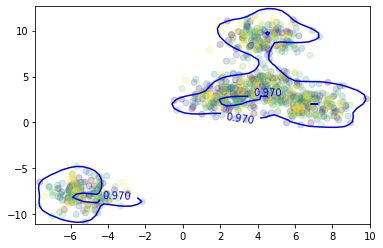

In [17]:
plot_contour(debug_model, colors)

In [18]:
print_report(debug_model, X)

c: 0.5289990973127252, q: 0.26710670639663525
Support vectors are 127, over 1000 candidates
Mistakes 207/1000 = 20.7%


**How does the mistakes ratio change during optimization?**

At each round we collect data about the mistakes of the model over the whole dataset

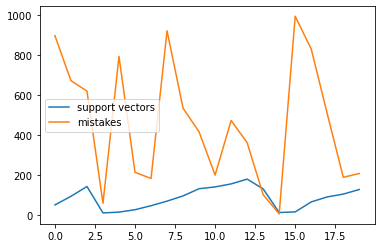

In [19]:
plt.plot([len(s['betas']) for s in debug_models], label='support vectors')
plt.plot(mistakes, label='mistakes')
plt.legend()
plt.show()

In [20]:
print(f'Average mistakes: {np.average(mistakes)}')
print(f'Std mistakes: {np.std(mistakes)}')

Average mistakes: 458.0
Std mistakes: 305.22319702145836


Usually the standard deviation is very high, probabily keeping track of the best model so far is a good idea.

How can we evaluate which model is the best in so far in production since we have limited view about the dataset?

### How does the best classifier found during the process work?

In [21]:
best_mistakes = min(mistakes)
best_mistakes_index = mistakes.index(best_mistakes)

print(f'Best mistakes {best_mistakes}/{len(X)} = {best_mistakes/len(X)*100}% at round {best_mistakes_index}/{number_of_rounds}')

Best mistakes 5/1000 = 0.5% at round 14/20


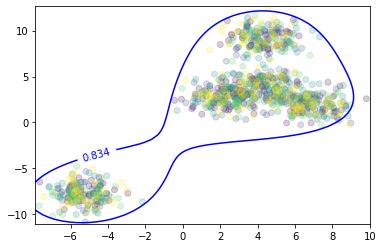

In [22]:
plot_contour(debug_sk_models[best_mistakes_index], colors)

## Federated Learning simulation with multiple pass on data

Does seing the data multiple times reduce mistakes? It's a sort of overfit
So at line 17, instead of taking the following slice of data, we sample the client's data randomly at each iteration.

It can happen that the same data is seen multiple times.

In [23]:
number_of_rounds_sampling = 70

server_model_sampling = init_server_model()

# Metrics
debug_sk_models_sampling = []
debug_models_sampling = []
mistakes_sampling = []

client_updates = []

points_per_round_sampling = points_per_round

def client_worker_sampling(client, round_ix):
    dataset = k[client]
    # Randomly sample the client data
    random_batch = np.random.choice(dataset.shape[0], points_per_round_sampling) 
    dataset = dataset[random_batch]
    
    update = client_compute_update(server_model_sampling, dataset)
    update = np.array(list(update))
    if update.size > 0:
        client_updates.put(update)

for r in tqdm(range(number_of_rounds_sampling)):
    client_updates = []
    threads = []
    for client in range(clients):
        t = threading.Thread(target=client_worker_sampling, args=(client, r))
        threads.append(t)
        t.start()
        
    for t in threads:
        t.join()
        
    server_model_sampling, debug_model = global_combine(server_model, client_updates)
    mistakes_sampling.append(sum(debug_model.predict(X)))
    debug_models_sampling.append(server_model)
    debug_sk_models_sampling.append(debug_model)

  0%|          | 0/70 [00:00<?, ?it/s]

Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
Changed value of parameter NumericFocus to 3
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Changed value of parameter NonConvex to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex

   7   8.49613495e-01  3.06658330e+00  1.26e-03 8.16e-14  1.11e-01     0s
   4   2.03980253e+00  5.27265635e+02  1.37e+00 8.27e-11  6.23e+01     0s
   6   8.62320533e-01  1.86626520e+01  1.12e-02 2.61e-12  9.01e-01     0s
   4   1.99422893e+00  5.25791525e+02  1.32e+00 8.05e-11  6.09e+01     0s
   5   1.00018160e+00  2.14464700e+02  1.35e-01 8.19e-12  1.21e+01     0s
   8   8.56728777e-01  1.14714382e+00  1.34e-04 8.63e-15  1.45e-02     0s
   9   8.64794317e-01  9.23787487e-01  1.95e-05 1.28e-15  2.95e-03     0s
   7   8.53994362e-01  2.72911637e+00  1.15e-03 2.68e-13  9.39e-02     0s
   5   9.93952480e-01  2.09586530e+02  1.31e-01 7.98e-12  1.18e+01     0s
   8   8.61329449e-01  1.10555582e+00  1.19e-04 2.77e-14  1.22e-02     0s
   9   8.65357565e-01  9.03829748e-01  1.39e-05 8.88e-16  1.92e-03     0s
   6   8.85419056e-01  2.41772405e+01  1.30e-02 7.91e-13  1.18e+00     0s
  10   8.67451136e-01  8.75519521e-01  2.06e-06 1.39e-16  4.04e-04     0s
   6   8.87618900e-01  2.48844058e+01 

Exception in thread Thread-107:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-110:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x55b46d70
Model has 8128 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-06, 4e+00]
  Bounds range     [3e-01, 3e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 8128 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 82
 AA' NZ     : 3.403e+03
 Factor NZ  : 3.486e+03
 Factor Ops : 1.941e+05 (less than 1 second per iteration)
 T

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished


Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter ObjScale to -0.5
Changed value of parameter NonConvex to 2
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NonConvex to 2
Changed value of parameter NumericFocus to 3
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter NumericFocus to 3
   Prev: -1  Min: -1  Max: 2  Default: -1
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NumericFocus to 3
Gurobi Optimizer version 9.1.2

   8   7.07657317e-01  3.33517889e+00  2.27e-04 1.14e-05  5.98e-02     0s
   6   7.38007465e-01  1.51779384e+02  1.51e-02 3.78e-04  3.50e+00     0s
   7   7.14466971e-01  1.78909264e+01  1.62e-03 3.82e-05  3.91e-01     0s
   7   6.77149164e-01  1.57503010e+01  1.55e-03 4.77e-05  3.43e-01     0s
   9   7.17624869e-01  1.22530770e+00  4.16e-05 2.10e-06  1.15e-02     0s
   7   7.17000698e-01  1.79534330e+01  1.62e-03 5.11e-05  3.93e-01     0s
   8   7.13280757e-01  2.59424465e+00  1.73e-04 4.09e-06  4.28e-02     0s
   7   7.11134661e-01  1.59941064e+01  1.52e-03 3.81e-05  3.48e-01     0s
   8   6.83510850e-01  2.62479513e+00  2.00e-04 6.14e-06  4.41e-02     0s
  10   7.37667087e-01  8.35107854e-01  4.78e-06 2.41e-07  2.21e-03     0s
   8   7.17582250e-01  2.60746277e+00  1.70e-04 5.36e-06  4.30e-02     0s
   9   7.24738891e-01  1.01734311e+00  2.37e-05 5.60e-07  6.65e-03     0s
   8   7.10684942e-01  2.45470765e+00  1.74e-04 4.35e-06  3.97e-02     0s
   9   7.21300472e-01  1.08618904e+00 

Exception in thread Thread-114:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-115:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'
Exception in thread Thread-

Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0xe56f141e
Model has 6883 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [4e-01, 4e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 6883 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 116
 AA' NZ     : 6.532e+03
 Factor NZ  : 6.903e+03
 Factor Ops : 5.407e+05 (less than 1 second per iteration)
 

 Factor NZ  : 1.128e+03

 Factor Ops : 4.042e+04 (less than 1 second per iteration)

                  Objective                Residual
 Factor Ops : 3.572e+04 (less than 1 second per iteration)
 Threads    : 1
                  Objective                Residual
   0  -2.81298543e+05  3.56990738e+05  1.40e+04 6.72e+02  1.00e+06     0s
Iter       Primal          Dual         Primal    Dual     Compl     Time
 Threads    : 1
Iter       Primal          Dual         Primal    Dual     Compl     Time

   0  -3.55264517e+05  4.25584777e+05  2.50e+04 8.09e+02  1.00e+06     0s
   1   2.22318231e+03  2.30611888e+04  1.40e+03 6.73e+01  1.00e+05     0s
                  Objective                Residual
   0  -9.40352701e+04  1.63483444e+05  4.85e+04 2.83e+02  1.00e+06     0s

   2   5.35501700e+02  1.95929174e+04  1.43e+02 6.86e+00  1.04e+04     0s
                  Objective                Residual
   1   9.47843554e+02  2.43584621e+04  2.50e+03 8.09e+01  1.00e+05     0s
Iter       Primal     

Optimal objective 9.04802356e-01
Optimal objective 9.04172363e-01
  19   9.04024721e-01  9.04024723e-01  1.66e-14 6.66e-16  2.44e-11     0s




Barrier solved model in 19 iterations and 0.04 seconds
Optimal objective 9.04024721e-01



Exception in thread Thread-119:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-118:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    2.4s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0xb4ac266d
Model has 3627 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [5e-01, 5e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 3627 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 125
 AA' NZ     : 4.940e+03
 Factor NZ  : 5.213e+03
 Factor Ops : 3.121e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 130 columns and 130 nonzeros
Model fingerprint: 0x8ed9ac0c
Model has 3837 quadratic objective terms
Changed value of parameter ObjScale to -0.5
Coefficient statistics:
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
  Matrix range     [1e+00, 1e+00]
Changed value of parameter ObjScale to -0.5
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
  Objective range  [1e+00, 1e+00]
Changed value of parameter NumericFocus to 3
Changed value of parameter NonConvex to 2
  QObjective range [1e-13, 4e+00

   4  -2.85463679e+02  4.04704257e+04  3.30e+00 1.39e-01  3.61e+02     0s
  15   9.76145213e-01  9.76727424e-01  1.19e-09 5.55e-11  2.24e-06     0s
 Threads    : 1
   7   9.64290324e-01  9.73885274e+01  7.00e-03 9.41e-05  3.73e-01     0s
   5  -1.31413479e+02  2.74486840e+04  1.63e+00 7.25e-02  1.95e+02     0s
  16   9.76225562e-01  9.76397068e-01  2.06e-10 9.65e-12  6.60e-07     0s
   5  -1.78131670e+02  2.24357199e+04  1.07e+00 4.50e-02  1.49e+02     0s

   8   9.51913300e-01  1.07484074e+01  7.04e-04 9.46e-06  3.77e-02     0s
   6   5.17512636e+00  6.31163476e+03  2.20e-01 9.80e-03  3.90e+01     0s
  17   9.76249771e-01  9.76302095e-01  4.39e-11 2.05e-12  2.01e-07     0s
                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   7   1.34129939e+00  1.14401426e+03  2.18e-02 9.72e-04  5.37e+00     0s
   6   3.45301671e+00  3.74982059e+03  1.06e-01 4.47e-03  2.27e+01     0s
   9   9.52777294e-01  2.04733772e+00  7.55

Exception in thread Thread-123:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-122:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    2.2s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0xa0bd1a14
Model has 6021 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [2e-01, 2e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 6021 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 117
 AA' NZ     : 6.300e+03
 Factor NZ  : 6.432e+03
 Factor Ops : 4.445e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
Changed value of parameter ObjScale to -0.5
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NumericFocus to 3
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Changed value of parameter ObjScale to -0.5
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Optimize a model with 1 rows, 112 columns and 112 nonzeros
Changed value of param

   9   8.13144841e-01  2.05143197e+00  9.46e-05 1.03e-06  5.53e-03     0s
   8   7.87385664e-01  9.79037743e+00  7.93e-04 3.76e-06  4.02e-02     0s
   6   9.27039457e-01  7.94608245e+02  7.65e-02 9.88e-04  3.82e+00     0s
   2   1.10835083e+03  2.54217039e+04  5.70e+02 6.65e+00  1.02e+04     0s
  10   8.77528732e-01  1.11588768e+00  1.05e-05 1.14e-07  1.06e-03     0s
   4   1.63985416e+01  1.63057977e+04  7.83e+00 7.71e-02  1.85e+02     0s
   3   1.17680114e+02  2.44667466e+04  5.86e+01 6.83e-01  1.13e+03     0s
   9   8.15663619e-01  2.07246402e+00  9.66e-05 4.58e-07  5.61e-03     0s
  11   9.06820333e-01  9.59238366e-01  1.14e-06 1.24e-08  2.34e-04     0s
   7   7.89987823e-01  8.53025522e+01  7.58e-03 9.79e-05  3.80e-01     0s
   5   2.32659647e+00  4.78914132e+03  7.76e-01 7.64e-03  2.88e+01     0s
   4   1.63186584e+01  1.62365210e+04  7.79e+00 9.08e-02  1.84e+02     0s
  10   8.77368656e-01  1.12232999e+00  1.14e-05 5.40e-08  1.09e-03     0s
   8   7.79849697e-01  9.80376478e+00 

Exception in thread Thread-128:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-127:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1715s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    2.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.7s remaining:    0.1s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0xcfb7c64b
Model has 5490 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [3e-01, 3e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 5490 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 124
 AA' NZ     : 5.639e+03
 Factor NZ  : 5.787e+03
 Factor Ops : 3.595e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
   Prev: -1  Min: -1  Max: 2  Default: -1
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x6d6de9b5
Model has 5637 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [3e-01, 3e-01]
  RHS range        [1e+00, 1e+00]
Gurobi Optimizer version 

   0  -1.30033591e+05  2.97959427e+05  1.26e+05 5.11e+02  1.00e+06     0s
Iter       Primal          Dual         Primal    Dual     Compl     Time
  16   9.36459042e-01  9.36477694e-01  3.88e-11 1.59e-13  7.34e-08     0s
   2   1.23694915e+03  4.17151687e+04  1.26e+03 4.68e+00  1.01e+04     0s
  12   9.35536618e-01  9.43273941e-01  1.85e-07 4.62e-10  3.05e-05     0s
   0  -2.87069441e+04  1.96632645e+05  1.26e+05 3.08e+02  1.00e+06     0s
   1   1.00392004e+04  4.44891468e+04  1.26e+04 5.11e+01  1.00e+05     0s
  17   9.36463698e-01  9.36467477e-01  3.85e-12 1.58e-14  1.49e-08     0s
   1   1.10521119e+04  4.34758482e+04  1.26e+04 3.08e+01  1.00e+05     0s
   3   1.26169884e+02  3.94420652e+04  1.26e+02 4.67e-01  1.12e+03     0s
  13   9.36262013e-01  9.37399376e-01  2.03e-08 5.08e-11  4.48e-06     0s
   2   1.23478905e+03  4.17173492e+04  1.26e+03 5.11e+00  1.01e+04     0s
  18   9.36464790e-01  9.36465239e-01  4.28e-13 1.60e-15  1.77e-09     0s
   4   1.33095771e+01  2.46107403e+04 

Exception in thread Thread-133:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-132:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1898s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.2s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x39f1a5be
Model has 5700 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [5e-01, 5e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 5700 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 119
 AA' NZ     : 5.359e+03
 Factor NZ  : 5.600e+03
 Factor Ops : 3.541e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter ObjScale to -0.5
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 111 columns and 111 nonzeros
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter ObjScale to -0.5
Model fingerprint: 0x0ce6f97f
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NonConvex to 2
Changed value of parameter ObjScale to -0.5
Model has 4865 quadratic objective terms
Changed value of parameter NumericFocus to 3
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter ObjSc

   5   2.21566189e+00  5.38124887e+03  3.72e-01 1.14e-02  3.05e+01     0s
   2   1.14181373e+03  5.12613137e+04  3.25e+02 9.74e+00  1.06e+04     0s
   5   2.28845734e+00  5.77565362e+03  7.41e-01 3.84e-03  3.26e+01     0s
  12   9.23091229e-01  9.34627546e-01  8.50e-08 2.20e-09  5.20e-05     0s
   5   2.29311719e+00  5.77532065e+03  7.41e-01 3.80e-03  3.26e+01     0s
   6   9.57078793e-01  8.20301253e+02  3.69e-02 1.13e-03  3.93e+00     0s
   3   1.38785097e+02  4.72418418e+04  3.82e+01 1.14e+00  1.38e+03     0s
   6   9.55193159e-01  8.72906545e+02  7.34e-02 3.77e-04  4.19e+00     0s
   6   9.50273549e-01  8.72970866e+02  7.34e-02 3.80e-04  4.19e+00     0s
  13   9.24492728e-01  9.26744883e-01  1.07e-08 2.78e-10  1.01e-05     0s
   7   8.32282323e-01  8.69973401e+01  3.65e-03 1.12e-04  3.91e-01     0s
   4   1.48732453e+01  2.94405993e+04  3.84e+00 1.15e-01  2.30e+02     0s
   7   8.17860827e-01  9.26938373e+01  7.28e-03 3.77e-05  4.17e-01     0s
   7   8.22799679e-01  9.26904461e+01 

Exception in thread Thread-138:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-139:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1720s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.2s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0xb7b26e1d
Model has 8128 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e-03, 4e+00]
  Bounds range     [8e-01, 8e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 8128 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 69
 AA' NZ     : 2.415e+03
 Factor NZ  : 2.485e+03
 Factor Ops : 1.168e+05 (less than 1 second per iteration)
 T

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter ObjScale to -0.5
Changed value of parameter NumericFocus to 3
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter ObjScale to -0.5
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
Changed value of parameter NonConvex to 2
Changed value of parameter NonConvex to 2
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
   Prev: -1  Min: -1  Max: 2  Default: -1
   Prev: 0  Mi

   5   2.77344201e-01  1.75682246e+03  5.73e-01 1.15e-02  7.54e+01     0s
  11   6.47137931e-01  7.14949183e-01  2.09e-06 1.12e-07  1.70e-03     0s
   7   6.39390916e-01  4.82532005e+01  3.58e-03 2.60e-04  1.22e+00     0s
   4  -6.34702708e+00  6.36435239e+03  3.33e+00 5.49e-02  3.20e+02     0s
   8   5.80395119e-01  5.93489691e+00  5.76e-04 1.05e-05  1.34e-01     0s
   6   7.27968409e-01  4.40433290e+02  5.68e-02 1.14e-03  1.26e+01     0s
  12   6.61225802e-01  6.78359452e-01  3.93e-07 2.10e-08  4.29e-04     0s
   9   5.96281842e-01  1.42155874e+00  8.83e-05 1.61e-06  2.06e-02     0s
   8   6.03622730e-01  5.76199460e+00  3.84e-04 2.79e-05  1.29e-01     0s
   5   3.08232487e-01  1.54809734e+03  5.08e-01 8.39e-03  6.17e+01     0s
  10   6.25712372e-01  8.19681978e-01  1.94e-05 3.55e-07  4.85e-03     0s
   6   5.88098811e-01  3.59462369e+02  5.04e-02 8.32e-04  1.01e+01     0s
   9   6.06643237e-01  1.48575105e+00  6.53e-05 4.74e-06  2.20e-02     0s
   7   5.92593016e-01  5.33901797e+01 

Exception in thread Thread-145:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1862s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      |

Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0xb02622d1
Model has 4582 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 4582 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 125
 AA' NZ     : 5.301e+03
 Factor NZ  : 5.427e+03
 Factor Ops : 3.453e+05 (less than 1 second per iteration)
 

Presolve time: 0.01s
   9   9.20583740e-01  3.07959131e+00  5.61e-05 1.85e-06  8.06e-03     0s
  QObjective range [1e-13, 4e+00]
   1   8.18405784e+03  1.42676999e+05  1.85e+03 7.80e+01  1.01e+05     0s
Presolve time: 0.01s
Presolved: 1 rows, 134 columns, 134 nonzeros
  10   9.38786044e-01  1.28588324e+00  8.07e-06 2.66e-07  1.30e-03     0s
  Bounds range     [1e+00, 1e+00]
Presolved: 1 rows, 134 columns, 134 nonzeros
   2   1.42011398e+03  1.34396985e+05  1.99e+02 8.38e+00  1.12e+04     0s
Presolved model has 5272 quadratic objective terms
  RHS range        [1e+00, 1e+00]
Presolved model has 5195 quadratic objective terms
  11   9.57832074e-01  1.02018579e+00  8.35e-07 2.76e-08  2.33e-04     0s
   3   1.93607512e+02  1.16065821e+05  3.27e+01 1.38e+00  2.07e+03     0s
Ordering time: 0.00s
  12   9.63072902e-01  9.74418813e-01  1.01e-07 3.35e-09  4.23e-05     0s
Presolve time: 0.01s
   4   2.74067561e+01  6.67541364e+04  3.49e+00 1.47e-01  4.06e+02     0s
Presolved: 1 rows, 134 columns

  17   9.64149289e-01  9.64159297e-01  1.14e-11 1.72e-13  3.73e-08     0s
  21   9.64009342e-01  9.64009346e-01  3.17e-15 2.39e-15  1.45e-11     0s
  18   9.64448041e-01  9.64448351e-01  1.90e-13 5.34e-15  1.16e-09     0s
  19   9.64448143e-01  9.64448175e-01  1.94e-14 6.66e-16  1.20e-10     0s

  18   9.64151296e-01  9.64154511e-01  3.45e-12 5.11e-14  1.20e-08     0s
Barrier solved model in 21 iterations and 0.09 seconds
  20   9.64448154e-01  9.64448157e-01  2.14e-15 2.66e-15  1.29e-11     0s
  19   9.64152236e-01  9.64152961e-01  3.42e-13 4.13e-15  2.71e-09     0s
Optimal objective 9.64009342e-01

  20   9.64152434e-01  9.64152511e-01  3.49e-14 1.33e-15  2.88e-10     0s
Barrier solved model in 20 iterations and 0.10 seconds

Optimal objective 9.64448154e-01
  21   9.64152455e-01  9.64152463e-01  3.20e-15 4.16e-15  2.89e-11     0s


Barrier solved model in 21 iterations and 0.10 seconds
Optimal objective 9.64152455e-01



Exception in thread Thread-151:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-150:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1927s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.2s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1


[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished


Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x62990f51
Model has 6410 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [3e-02, 3e-02]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 6410 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 117
 AA' NZ     : 6.903e+03
 Factor NZ  : 7.021e+03
 Factor Ops : 5.547e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.55724370e+05  2.88689202e+05  4.54e+04 5.66e+02  1.00e+06     0s
   1   1.00997255e+04  6.33095998e+03  4.54e


   0  -2.77799083e+05  3.45555820e+05  3.30e+04 6.86e+02  1.00e+06     0s

Iter       Primal          Dual         Primal    Dual     Compl     Time
                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
                  Objective                Residual
   1   3.15299659e+03  5.21184186e+03  3.30e+03 6.87e+01  1.00e+05     0s
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.96971519e+05  3.64255465e+05  3.28e+04 7.23e+02  1.00e+06     0s
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.46738766e+05  4.14495507e+05  3.30e+04 8.24e+02  1.00e+06     0s
   0  -9.35966012e+04  1.61353343e+05  3.30e+04 3.18e+02  1.00e+06     0s
   1   2.91653986e+03  5.42436461e+03  3.28e+03 7.24e+01  1.00e+05     0s
   1   2.46361788e+03  5.89880149e+03  3.30e+03 8.25e+01  1.00e+05     0s
   1   5.00467221e+03  3.35632307e+03  3.30e+03 3.18e+01  1.00e+05     0s
   2  

Exception in thread Thread-153:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-154:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1830s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.2s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x88ceb7aa
Model has 5543 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [5e-01, 5e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 5543 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 123
 AA' NZ     : 5.643e+03
 Factor NZ  : 5.798e+03
 Factor Ops : 3.624e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
Changed value of parameter ObjScale to -0.5
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0  Min: 0  Max: 3  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Changed value of parameter NumericFocus to 3
Changed value of parameter NonConvex to 2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Changed value of parameter ObjScale to -0.5
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Optimize a model with 1 rows, 91 columns and 91 nonzeros
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of paramet

   4   9.75896913e+00  2.21291230e+04  8.90e+00 5.18e-02  1.92e+02     0s
   1   6.38092217e+03  5.11500089e+04  9.00e+03 5.23e+01  1.00e+05     0s
   7   8.48254703e-01  5.45457288e+01  8.68e-03 4.23e-05  2.96e-01     0s
  10   9.14433844e-01  1.05915792e+00  1.21e-05 7.14e-08  7.95e-04     0s
   8   8.44197117e-01  6.60955390e+00  9.12e-04 4.44e-06  3.17e-02     0s
   8   8.45209467e-01  6.62331782e+00  9.13e-04 4.56e-06  3.18e-02     0s
  11   9.29978155e-01  9.57525903e-01  1.27e-06 7.48e-09  1.51e-04     0s
   5   1.72683725e+00  3.71181166e+03  8.82e-01 5.14e-03  2.48e+01     0s
   2   8.74600657e+02  4.81133999e+04  9.00e+02 5.23e+00  1.02e+04     0s
   9   8.73019713e-01  1.67793193e+00  1.11e-04 5.40e-07  4.42e-03     0s
   9   8.72806349e-01  1.70467833e+00  1.16e-04 5.78e-07  4.57e-03     0s
   6   9.26190390e-01  5.27634676e+02  8.74e-02 5.09e-04  3.01e+00     0s
   3   9.04963271e+01  4.39837347e+04  8.99e+01 5.22e-01  1.19e+03     0s
  12   9.33139391e-01  9.37941794e-01 

Exception in thread Thread-159:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-157:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    2.3s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x8c6b2f45
Model has 5353 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 5353 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 125
 AA' NZ     : 5.970e+03


[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished


 Factor NZ  : 6.139e+03
 Factor Ops : 4.215e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.98275607e+05  4.51282093e+05  1.26e+05 6.46e+02  1.00e+06     0s
   1   9.30749436e+03  1.30527160e+05  1.26e+04 6.46e+01  1.00e+05     0s
   2   1.22373026e+03  1.25091602e+05  1.26e+03 6.46e+00  1.04e+04     0s
   3   1.26098469e+02  1.05721824e+05  1.26e+02 6.47e-01  1.33e+03     0s
   4   1.32876490e+01  3.52355149e+04  1.25e+01 6.41e-02  2.02e+02     0s
   5   2.11270530e+00  4.74593155e+03  1.24e+00 6.36e-03  2.32e+01     0s
   6   9.93890847e-01  7.09637913e+02  1.22e-01 6.30e-04  2.95e+00     0s
   7   8.83056331e-01  7.46164831e+01  1.21e-02 6.24e-05  2.92e-01     0s
   8   8.73471190e-01  8.61242413e+00  1.25e-03 6.46e-06  3.05e-02     0s
   9   8.85755061e-01  1.90626914e+00  1.49e-04 7.69e-07  4.02e-03     0s
  10   9.21952053e-01  1.10153696e

   1   7.91731108e+03  9.95429225e+04  9.55e+03 3.21e+01  1.00e+05     0s
 Factor NZ  : 4.194e+03
 AA' NZ     : 4.195e+03
 Factor Ops : 2.487e+05 (less than 1 second per iteration)
   5   1.82038213e+00  3.82386209e+03  9.38e-01 4.88e-03  2.40e+01     0s
   2   9.37913375e+02  9.62125502e+04  9.56e+02 3.21e+00  1.04e+04     0s
   5   1.83182548e+00  3.54845812e+03  9.47e-01 3.22e-03  2.26e+01     0s
 Factor NZ  : 4.352e+03
 Threads    : 1
   3   9.60782633e+01  8.13073581e+04  9.58e+01 3.22e-01  1.34e+03     0s
   6   9.66994856e-01  5.52932431e+02  9.30e-02 4.83e-04  2.97e+00     0s
   6   9.68944478e-01  5.39252675e+02  9.38e-02 3.19e-04  2.91e+00     0s
 Factor Ops : 2.652e+05 (less than 1 second per iteration)

 Threads    : 1
   7   8.82499377e-01  5.73881350e+01  9.22e-03 4.79e-05  2.93e-01     0s
   7   8.83500733e-01  5.60985650e+01  9.30e-03 3.16e-05  2.86e-01     0s
   4   1.03057630e+01  2.71482699e+04  9.49e+00 3.19e-02  2.03e+02     0s
                  Objective          

Exception in thread Thread-166:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-165:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1879s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.1s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x2fec5bb7
Model has 7169 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [9e-01, 9e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 7169 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 114
 AA' NZ     : 6.112e+03
 Factor NZ  : 6.358e+03
 Factor Ops : 4.534e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Changed value of parameter ObjScale to -0.5
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 40 columns and 40 nonzeros
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Model fingerprint: 0x66230890
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter ObjScale to -0.5
Model has 698 quadratic objective terms
Changed value of parameter NonConvex to 2
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Coefficient statistics:
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: -1 

   5   1.22960996e+00  1.89127844e+03  3.93e-01 3.41e-03  2.70e+01     0s
   2   3.60770667e+02  3.44722653e+04  4.00e+02 7.83e+00  1.03e+04     0s
   7   8.57285971e-01  2.31546616e+01  3.87e-03 3.63e-05  2.79e-01     0s
  12   8.98126319e-01  9.02010600e-01  2.18e-07 1.99e-09  4.86e-05     0s
   4   4.76756656e+00  1.14720617e+04  3.94e+00 5.36e-02  2.06e+02     0s
   6   8.73939583e-01  2.30892553e+02  3.89e-02 3.38e-04  2.93e+00     0s
  13   8.98776055e-01  8.99420721e-01  2.25e-08 2.05e-10  8.06e-06     0s
   8   8.56967582e-01  3.33964537e+00  4.17e-04 3.91e-06  3.10e-02     0s
   3   4.00336442e+01  2.98772746e+04  3.96e+01 7.76e-01  1.29e+03     0s
   5   1.22158395e+00  1.79959013e+03  3.91e-01 5.31e-03  2.58e+01     0s
  14   8.98895679e-01  8.99030977e-01  4.37e-09 3.99e-11  1.69e-06     0s
   9   8.77007402e-01  1.25149428e+00  5.68e-05 5.32e-07  4.68e-03     0s
   7   8.39237785e-01  2.42210175e+01  3.91e-03 3.40e-05  2.93e-01     0s
   4   4.75657022e+00  1.14422251e+04 

Exception in thread Thread-170:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-171:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'
Exception in thread Thread-

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1962s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    2.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x9c3c1d1a
Model has 5036 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [5e-01, 5e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 5036 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 125
 AA' NZ     : 5.301e+03
 Factor NZ  : 5.427e+03
 Factor Ops : 3.453e+05 (less than 1 second per iteration)
 



   0   3.64782638e+07  5.86840047e+05  1.06e+04 5.89e+02  1.00e+06     0s
Barrier statistics:
Iter       Primal          Dual         Primal    Dual     Compl     Time

Barrier statistics:
   1   3.69890020e+06  3.66578930e+04  1.06e+03 5.89e+01  1.00e+05     0s
 Free vars  : 116
   0   6.88345903e+07  4.27063950e+05  1.46e+04 4.65e+02  1.00e+06     0s
 Free vars  : 116
                  Objective                Residual
 AA' NZ     : 4.467e+03
 AA' NZ     : 4.526e+03
   2   3.72005263e+05  3.09622602e+04  1.07e+02 5.91e+00  1.02e+04     0s
 Factor NZ  : 4.628e+03
   1   6.92240958e+06  3.31307417e+04  1.46e+03 4.66e+01  1.00e+05     0s
Iter       Primal          Dual         Primal    Dual     Compl     Time
 Factor NZ  : 4.695e+03
   0   4.73077644e+07  6.76008232e+05  1.09e+04 9.11e+02  1.00e+06     0s
   2   6.96297334e+05  2.90055874e+04  1.47e+02 4.68e+00  1.02e+04     0s
 Factor Ops : 2.700e+05 (less than 1 second per iteration)
   3   3.80943595e+04  2.93477468e+04  1.09e+01 

  22   9.56664176e-01  9.56664665e-01  1.66e-14 1.82e-12  2.04e-09     0s
  22   9.56680348e-01  9.56680641e-01  1.15e-14 3.63e-12  1.22e-09     0s
  17   9.56571916e-01  9.56846142e-01  3.15e-10 1.35e-11  1.15e-06     0s
  23   9.56664278e-01  9.56664327e-01  1.65e-15 1.79e-11  2.07e-10     0s
  18   9.56604684e-01  9.56604894e-01  2.92e-13 1.26e-15  8.73e-10     0s
  22   9.56623003e-01  9.56623920e-01  8.80e-14 4.55e-13  3.82e-09     0s
  23   9.56680426e-01  9.56680456e-01  1.12e-15 9.09e-13  1.26e-10     0s
  24   9.56664288e-01  9.56664293e-01  3.96e-16 2.73e-12  2.07e-11     0s
  18   9.56599828e-01  9.56693765e-01  7.55e-11 9.09e-12  3.93e-07     0s
  23   9.56623247e-01  9.56623353e-01  8.74e-15 4.52e-12  4.43e-10     0s
  19   9.56604743e-01  9.56604765e-01  2.71e-14 6.66e-16  8.93e-11     0s

  20   9.56604749e-01  9.56604752e-01  6.12e-15 8.88e-16  9.63e-12     0s
Barrier solved model in 24 iterations and 0.06 seconds
  24   9.56680434e-01  9.56680437e-01  5.20e-16 9.09e-13

Exception in thread Thread-174:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-176:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1966s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    2.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x27d3ee9a
Model has 4579 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [4e-01, 4e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 4579 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 125
 AA' NZ     : 5.301e+03
 Factor NZ  : 5.427e+03
 Factor Ops : 3.453e+05 (less than 1 second per iteration)
 

  17   9.64370033e-01  9.64377906e-01  4.63e-12 1.49e-13  2.87e-08     0s

Model fingerprint: 0xd474aa30
Model fingerprint: 0x57aab913
Ordering time: 0.00s
                  Objective                Residual
  18   9.64371687e-01  9.64373612e-01  5.83e-13 2.02e-14  7.03e-09     0s
Model has 5304 quadratic objective terms
Model has 5329 quadratic objective terms
Iter       Primal          Dual         Primal    Dual     Compl     Time

Coefficient statistics:
Coefficient statistics:
   0  -3.85886481e+05  6.04883280e+05  2.04e+04 5.91e+02  1.00e+06     0s
Barrier statistics:
  Matrix range     [1e+00, 1e+00]
  Matrix range     [1e+00, 1e+00]
 Free vars  : 134
  Objective range  [1e+00, 1e+00]
   1   1.04986987e+04  6.49516048e+04  2.04e+03 5.91e+01  1.00e+05     0s
  19   9.64372116e-01  9.64372375e-01  6.09e-14 3.91e-15  9.46e-10     0s
  Objective range  [1e+00, 1e+00]
 AA' NZ     : 6.237e+03
  QObjective range [1e-13, 4e+00]
  QObjective range [1e-13, 4e+00]
   2   1.56714880e+03  5.

  16   9.64245628e-01  9.64295410e-01  6.05e-11 1.22e-12  1.82e-07     0s
  17   9.64510003e-01  9.64517061e-01  6.67e-12 2.23e-13  2.58e-08     0s
  18   9.64511853e-01  9.64513644e-01  6.81e-13 1.09e-14  6.53e-09     0s
  17   9.64255612e-01  9.64269157e-01  1.33e-11 2.70e-13  4.94e-08     0s
  18   9.64258723e-01  9.64261241e-01  1.76e-12 3.57e-14  9.19e-09     0s
  19   9.64512298e-01  9.64512481e-01  6.78e-14 9.98e-15  6.67e-10     0s
  19   9.64259419e-01  9.64259811e-01  1.75e-13 5.66e-15  1.43e-09     0s
  20   9.64512345e-01  9.64512363e-01  6.80e-15 2.31e-15  6.80e-11     0s
  20   9.64259530e-01  9.64259570e-01  1.75e-14 6.99e-15  1.45e-10     0s

Barrier solved model in 20 iterations and 0.11 seconds
  21   9.64259542e-01  9.64259546e-01  2.48e-15 1.78e-15  1.48e-11     0s
Optimal objective 9.64512345e-01


Barrier solved model in 21 iterations and 0.12 seconds
Optimal objective 9.64259542e-01



Exception in thread Thread-180:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-177:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    2.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.8s remaining:    0.1s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0xdc9a28a2
Model has 6363 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [2e-01, 2e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 6363 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 115
 AA' NZ     : 6.670e+03
 Factor NZ  : 6.786e+03
 Factor Ops : 5.270e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Changed value of parameter NumericFocus to 3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
   Prev: 0  Min: 0  Max: 3  Default: 0
Optimize a model with 1 rows, 63 columns and 63 nonzeros
Changed value of parameter NonConvex to 2
Model fingerprint: 0xe1f391b8
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Model has 1736 quadratic objective terms
   Prev: 0.0  Min: -1.0  Max: inf  Defaul

   4   8.45247227e+00  8.25593989e+03  3.85e+00 6.80e-02  1.65e+02     0s
   5   1.53143554e+00  2.76455287e+03  3.78e-01 5.75e-03  2.79e+01     0s
   6   8.64749106e-01  6.24463968e+02  4.92e-02 6.39e-04  5.26e+00     0s
  12   9.10328201e-01  9.19538693e-01  1.03e-07 4.68e-09  7.31e-05     0s
   3   7.82137711e+01  1.10173968e+04  2.32e+01 6.78e-01  1.19e+03     0s
   5   1.53626050e+00  2.76748739e+03  3.81e-01 6.74e-03  2.79e+01     0s
   6   8.47076927e-01  4.28362261e+02  3.75e-02 5.69e-04  3.54e+00     0s
   6   8.53392121e-01  4.23191589e+02  3.78e-02 6.68e-04  3.49e+00     0s
   4   1.25149776e+01  8.29004901e+03  3.70e+00 1.08e-01  2.16e+02     0s
   7   7.62473133e-01  6.65975333e+01  4.90e-03 6.37e-05  5.26e-01     0s
  13   9.11675275e-01  9.13491156e-01  1.24e-08 5.66e-10  1.44e-05     0s
   7   7.79915137e-01  4.41807988e+01  3.71e-03 5.64e-05  3.46e-01     0s
   7   7.86351750e-01  4.37072153e+01  3.75e-03 6.62e-05  3.42e-01     0s
  14   9.11924226e-01  9.12270706e-01 

Exception in thread Thread-183:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-184:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1747s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.2s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x777fcd10
Model has 4827 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [1e-01, 1e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 4827 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 125
 AA' NZ     : 5.301e+03
 Factor NZ  : 5.427e+03
 Factor Ops : 3.453e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished


   6   1.21776782e+00  1.29201190e+03  5.77e-02 7.59e-04  5.75e+00     0s
   7   9.38113479e-01  1.50730828e+02  5.72e-03 7.52e-05  5.99e-01     0s
   8   9.10668413e-01  1.61418726e+01  5.80e-04 7.62e-06  6.01e-02     0s
   9   9.10398048e-01  2.73308801e+00  6.94e-05 9.12e-07  7.18e-03     0s
  10   9.28219891e-01  1.30009877e+00  1.32e-05 1.73e-07  1.46e-03     0s
  11   9.52189898e-01  1.03132174e+00  1.40e-06 1.84e-08  3.12e-04     0s
  12   9.58703522e-01  9.75219897e-01  2.06e-07 2.70e-09  6.50e-05     0s
  13   9.60079330e-01  9.63438103e-01  2.93e-08 3.85e-10  1.32e-05     0s
  14   9.60364024e-01  9.61149928e-01  4.20e-09 5.52e-11  3.09e-06     0s
  15   9.60484432e-01  9.60660604e-01  4.31e-10 5.66e-12  6.94e-07     0s
  16   9.60518309e-01  9.60556668e-01  7.06e-11 9.26e-13  1.51e-07     0s
  17   9.60527106e-01  9.60537316e-01  1.61e-11 2.12e-13  4.02e-08     0s
  18   9.60529823e-01  9.60531660e-01  2.17e-12 2.88e-14  7.23e-09     0s
  19   9.60530326e-01  9.60530583e-01 

   4   6.73643887e+02  8.51479492e+03  8.70e-01 8.60e-02  1.41e+02     0s
 Factor Ops : 1.483e+05 (less than 1 second per iteration)
   1   1.28334095e+05  1.42947493e+04  1.76e+03 4.25e+01  1.01e+05     0s
   7   1.69337214e+00  4.66520302e+02  7.73e-03 2.66e-04  3.08e+00     0s
   3   3.21408250e+03  9.61343876e+03  1.27e+01 4.77e-01  1.17e+03     0s
 Threads    : 1
   2   1.34057105e+04  1.06224110e+04  1.79e+02 4.33e+00  1.04e+04     0s
   5   8.05607914e+01  3.70143852e+03  1.13e-01 1.12e-02  2.62e+01     0s
   8   9.61105673e-01  8.36305904e+01  7.66e-04 2.64e-05  4.35e-01     0s
   4   3.49688153e+02  8.61639210e+03  1.41e+00 5.29e-02  1.59e+02     0s
   3   1.38756585e+03  1.04412284e+04  1.86e+01 4.49e-01  1.11e+03     0s
   6   8.64567551e+00  9.85617511e+02  2.34e-02 2.31e-03  5.79e+00     0s
   9   8.77405746e-01  9.42027194e+00  7.63e-05 2.63e-06  4.30e-02     0s
   4   1.39979143e+02  9.30645295e+03  2.00e+00 4.84e-02  1.51e+02     0s

   5   4.41180473e+01  4.20090873e+0

Exception in thread Thread-189:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-190:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    2.5s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0xd8e8b00d
Model has 5509 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [3e-01, 3e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 5509 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 124
 AA' NZ     : 5.645e+03
 Factor NZ  : 5.793e+03
 Factor Ops : 3.597e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s finished


  19   9.35508604e-01  9.35508783e-01  8.29e-14 8.88e-16  7.07e-10     0s
  20   9.35508654e-01  9.35508672e-01  5.54e-15 1.75e-15  7.17e-11     0s

Barrier solved model in 20 iterations and 0.02 seconds
Optimal objective 9.35508654e-01

Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 137 columns and 137 nonzeros
Model fingerprint: 0xb8b52acb
Model has 6257 quadratic objective terms
Changed value of parameter ObjScale to -0.5
Coefficient statistics:
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
  Matrix range     [1e+00, 1e+00]
Changed value of parameter NumericFocus to 3
Changed value of parameter ObjScale to -0.5
  

  17   9.35594488e-01  9.35602769e-01  5.57e-12 4.23e-14  3.02e-08     0s
   0  -1.19457383e+05  2.94759068e+05  6.87e+04 5.12e+02  1.00e+06     0s
   7   8.66969426e-01  9.14171938e+01  8.92e-03 6.26e-05  3.34e-01     0s
                  Objective                Residual
  18   9.35596748e-01  9.35598202e-01  9.13e-13 7.38e-15  5.31e-09     0s
Iter       Primal          Dual         Primal    Dual     Compl     Time
   4   1.91039546e+01  1.94542143e+04  9.13e+00 6.39e-02  1.71e+02     0s
   8   8.52071414e-01  1.02748784e+01  9.16e-04 6.42e-06  3.44e-02     0s
  19   9.35597191e-01  9.35597358e-01  1.00e-13 1.11e-15  6.11e-10     0s
   0  -8.87230167e+04  2.64024686e+05  6.88e+04 4.51e+02  1.00e+06     0s
   1   1.11827701e+04  4.03773873e+04  6.88e+03 5.12e+01  1.00e+05     0s
   5   2.66077141e+00  5.69635784e+03  9.05e-01 6.33e-03  2.78e+01     0s
   9   8.61085624e-01  2.08976662e+00  1.09e-04 7.68e-07  4.49e-03     0s
  20   9.35597244e-01  9.35597262e-01  1.00e-14 8.88e-16  6.

Exception in thread Thread-195:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-192:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1923s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.1s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x65a20e4a
Model has 3347 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [2e-02, 2e-02]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 3347 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 125
 AA' NZ     : 4.398e+03
 Factor NZ  : 4.647e+03
 Factor Ops : 2.514e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
Changed value of parameter NumericFocus to 3
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NumericFocus to 3
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter ObjScale to -0.5
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Thread count: 8 physical cores, 8 logical processors, using up to 8 threa

   8   9.58081850e-01  8.80314758e+00  2.16e-04 5.48e-06  3.19e-02     0s
   2   2.12317409e+03  2.39037495e+03  1.07e+02 5.91e+00  1.01e+04     0s
   7   1.00990736e+00  1.54126530e+02  2.18e-03 1.46e-04  6.46e-01     0s
   9   9.57831072e-01  3.01199924e+00  2.54e-05 1.65e-06  8.36e-03     0s
   9   9.57994851e-01  1.80196441e+00  2.21e-05 5.59e-07  3.43e-03     0s
   3   1.68960204e+02  2.25279097e+03  2.11e+01 6.21e-01  1.02e+03     0s
   8   9.61085204e-01  1.65914996e+01  2.17e-04 1.45e-05  6.39e-02     0s
   3   2.19902159e+02  2.34045312e+03  1.08e+01 5.98e-01  1.03e+03     0s
  10   9.66716285e-01  1.08027456e+00  2.34e-06 5.94e-08  4.62e-04     0s
   4   1.80458737e+01  2.21425032e+03  2.14e+00 6.30e-02  1.10e+02     0s
  10   9.61913922e-01  1.21176413e+00  2.64e-06 1.72e-07  1.02e-03     0s
  11   9.75998539e-01  9.93070764e-01  2.55e-07 6.47e-09  6.94e-05     0s
   9   9.56982338e-01  2.59640391e+00  2.20e-05 1.47e-06  6.67e-03     0s
   4   2.32878247e+01  2.29929164e+03 

Exception in thread Thread-198:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-199:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1690s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x3e3ac0f4
Model has 4813 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [4e-01, 4e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 4813 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 125
 AA' NZ     : 5.301e+03
 Factor NZ  : 5.427e+03
 Factor Ops : 3.453e+05 (less than 1 second per iteration)
 

 Factor NZ  : 3.655e+03
 AA' NZ     : 3.279e+03

 AA' NZ     : 3.409e+03
 Factor NZ  : 3.459e+03
 Factor Ops : 1.910e+05 (less than 1 second per iteration)
   1   8.96859127e+04  4.04656127e+04  2.16e+03 4.18e+01  1.02e+05     0s
 Factor NZ  : 3.573e+03
 Factor Ops : 1.724e+05 (less than 1 second per iteration)
                  Objective                Residual
 Threads    : 1
 Factor Ops : 1.842e+05 (less than 1 second per iteration)
   2   9.46225234e+03  3.66027587e+04  2.20e+02 4.26e+00  1.05e+04     0s
Iter       Primal          Dual         Primal    Dual     Compl     Time
 Threads    : 1

   3   9.73360711e+02  3.50681595e+04  2.45e+01 4.74e-01  1.28e+03     0s
 Threads    : 1
   0   1.05756179e+06  3.12178670e+05  1.12e+04 2.80e+02  1.00e+06     0s

                  Objective                Residual

Iter       Primal          Dual         Primal    Dual     Compl     Time
                  Objective                Residual
   1   1.33493336e+05  3.97352069e+04  1.14e+03 2.8

  16   9.60662716e-01  9.61084349e-01  3.48e-10 1.11e-11  2.01e-06     0s
  21   9.60803284e-01  9.60804294e-01  5.32e-14 5.68e-14  4.81e-09     0s
  20   9.60806095e-01  9.60806656e-01  6.89e-14 9.47e-14  2.67e-09     0s
  22   9.60803510e-01  9.60803631e-01  5.26e-15 1.40e-13  5.78e-10     0s
  19   9.60939085e-01  9.60957164e-01  3.89e-12 3.15e-13  8.61e-08     0s
  17   9.60697680e-01  9.60792667e-01  4.05e-11 1.29e-12  4.52e-07     0s
  20   9.60942073e-01  9.60945652e-01  4.50e-13 7.22e-14  1.70e-08     0s
  23   9.60803538e-01  9.60803550e-01  1.76e-15 3.55e-14  5.79e-11     0s
  21   9.60806233e-01  9.60806293e-01  6.85e-15 2.84e-14  2.86e-10     0s
  18   9.60707948e-01  9.60732277e-01  7.20e-12 2.30e-13  1.16e-07     0s
  19   9.60711458e-01  9.60720813e-01  2.43e-12 7.76e-14  4.45e-08     0s
  22   9.60806249e-01  9.60806256e-01  2.30e-15 5.68e-14  3.20e-11     0s
  20   9.60713381e-01  9.60715201e-01  2.40e-13 1.42e-14  8.67e-09     0s

  21   9.60942669e-01  9.60943223e-01

Exception in thread Thread-206:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-204:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1801s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    2.5s remaining:    0.4s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x11e59cfd
Model has 4037 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [3e-01, 3e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 4037 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 125
 AA' NZ     : 5.283e+03
 Factor NZ  : 5.427e+03
 Factor Ops : 3.453e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
Changed value of parameter ObjScale to -0.5
   Prev: -1  Min: -1  Max: 2  Default: -1
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Changed value of parameter ObjScale to -0.5
Optimize a model with 1 rows, 100 columns and 100 nonzeros
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Model fingerprint: 0x5ca09a84
Changed value of parameter ObjScale to -0.5
Thread count: 8 physical cores, 8 logical processors, using up to 8 t

  11   9.68521574e-01  9.90190511e-01  4.82e-07 9.24e-09  1.08e-04     0s
   2   9.74964761e+02  3.13214538e+04  5.06e+02 4.48e+00  1.03e+04     0s
   9   9.51402768e-01  1.91210516e+00  7.59e-05 7.49e-07  4.80e-03     0s
   4   1.43876924e+01  1.73440429e+04  6.75e+00 6.57e-02  1.90e+02     0s
   4   1.46531639e+01  1.67886713e+04  6.87e+00 6.72e-02  1.88e+02     0s
   3   1.05819887e+02  2.97092863e+04  5.27e+01 4.66e-01  1.17e+03     0s
  10   9.60301943e-01  1.12593352e+00  1.19e-05 1.17e-07  8.28e-04     0s
   5   2.30493946e+00  4.92226549e+03  6.78e-01 6.60e-03  3.18e+01     0s
  12   9.69642464e-01  9.72989069e-01  5.49e-08 1.05e-09  1.67e-05     0s
   5   2.33652849e+00  4.82118829e+03  6.94e-01 6.78e-03  3.13e+01     0s
   4   1.46523443e+01  1.67890588e+04  6.87e+00 6.08e-02  1.88e+02     0s
   6   1.08267569e+00  7.88189218e+02  6.72e-02 6.54e-04  4.20e+00     0s
  13   9.69865738e-01  9.70446573e-01  7.11e-09 1.36e-10  2.90e-06     0s
   5   2.33321975e+00  4.82127578e+03 

Exception in thread Thread-208:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-209:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1983s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.2s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0xfbb994a9
Model has 8128 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e-03, 4e+00]
  Bounds range     [7e-01, 7e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 8128 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 70
 AA' NZ     : 2.485e+03
 Factor NZ  : 2.556e+03
 Factor Ops : 1.218e+05 (less than 1 second per iteration)
 T

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished


  10   1.18461352e+00  1.08853444e+00  3.43e-05 5.07e-07  2.31e-03     0s
  11   8.13136047e-01  8.10777024e-01  1.13e-05 1.67e-07  8.47e-04     0s
  12   6.66016482e-01  7.23529923e-01  1.12e-06 1.66e-08  3.09e-04     0s
  13   6.65771940e-01  6.85075365e-01  1.11e-07 1.64e-09  8.40e-05     0s
  14   6.70098078e-01  6.73089782e-01  1.17e-08 1.81e-10  1.26e-05     0s
  15   6.71042933e-01  6.71365559e-01  1.24e-09 1.12e-11  1.36e-06     0s
  16   6.71149674e-01  6.71182007e-01  1.25e-10 4.14e-12  1.36e-07     0s
  17   6.71160401e-01  6.71163634e-01  1.25e-11 3.64e-12  1.36e-08     0s
  18   6.71161474e-01  6.71161797e-01  1.25e-12 7.28e-12  1.36e-09     0s
  19   6.71161581e-01  6.71161613e-01  1.25e-13 7.28e-12  1.36e-10     0s
  20   6.71161592e-01  6.71161595e-01  1.25e-14 3.64e-12  1.36e-11     0s

Barrier solved model in 20 iterations and 0.02 seconds
Optimal objective 6.71161592e-01

Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Chan

   4   8.34250682e-01  5.46249060e+03  2.04e+00 8.96e-02  2.97e+02     0s
   4   3.49801153e+00  6.26502759e+03  2.00e+00 7.47e-02  3.22e+02     0s
   4   2.54736156e+00  5.74117851e+03  1.80e+00 8.20e-02  2.92e+02     0s
   3   2.70460334e+01  9.66181323e+03  1.43e+01 4.56e-01  1.38e+03     0s
   7   5.63737556e-01  2.26844081e+01  2.00e-03 1.85e-04  6.17e-01     0s
   5   7.42130896e-01  1.31221422e+03  2.02e-01 8.88e-03  4.65e+01     0s
   4   2.29566018e+00  5.52527154e+03  2.14e+00 6.83e-02  2.85e+02     0s
   5   8.09353477e-01  1.35818703e+03  1.78e-01 8.13e-03  4.62e+01     0s
   5   9.39432327e-01  1.44128735e+03  1.99e-01 7.41e-03  4.88e+01     0s
   8   5.66453437e-01  3.37533035e+00  2.54e-04 2.34e-05  7.81e-02     0s
   6   5.42800305e-01  1.94785949e+02  1.76e-02 8.05e-04  5.56e+00     0s
   6   5.79098879e-01  2.03205970e+02  1.97e-02 7.34e-04  5.79e+00     0s
   5   8.13140713e-01  1.32400773e+03  2.12e-01 6.77e-03  4.54e+01     0s
   6   5.15257990e-01  2.06327471e+02 

Exception in thread Thread-212:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-216:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0xb5412fac
Model has 7597 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [8e-01, 8e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 7597 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 105
 AA' NZ     : 5.197e+03
 Factor NZ  : 5.303e+03
 Factor Ops : 3.386e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter ObjScale to -0.5
Changed value of parameter NumericFocus to 3
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter ObjScale to -0.5
Changed value of parameter NumericFocus to 3
Changed value of parameter NonConvex to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
Changed value of parameter NonConvex to 2
Changed value of parameter NumericFocus to 3
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
   Prev: -1  Min: -1  Max

   3   3.89463500e+01  2.31408361e+04  1.94e+01 1.04e+00  1.41e+03     0s
   8   8.42643538e-01  2.99859795e+00  3.57e-04 3.10e-06  3.27e-02     0s
   7   8.41342718e-01  1.93178594e+01  3.20e-03 6.88e-05  2.80e-01     0s
   4   4.97804446e+00  1.07005905e+04  2.09e+00 1.12e-01  2.46e+02     0s
   9   8.71022314e-01  1.15995661e+00  4.30e-05 1.10e-06  4.38e-03     0s
   4   4.01566742e+00  9.51298373e+03  3.19e+00 8.12e-02  2.06e+02     0s
   9   8.71878808e-01  1.16383945e+00  4.35e-05 3.77e-07  4.42e-03     0s
  10   8.80859208e-01  9.20920351e-01  4.91e-06 1.26e-07  6.07e-04     0s
   5   1.23209344e+00  1.79965455e+03  2.07e-01 1.11e-02  3.17e+01     0s
   5   1.16032800e+00  1.59000545e+03  3.20e-01 8.16e-03  2.71e+01     0s
   8   8.42646982e-01  2.96317974e+00  3.53e-04 7.59e-06  3.21e-02     0s
  11   8.83592661e-01  8.88690977e-01  5.18e-07 1.33e-08  7.73e-05     0s
  10   8.80633673e-01  9.22628518e-01  5.26e-06 4.56e-08  6.36e-04     0s
  12   8.84252580e-01  8.84958654e-01 

Exception in thread Thread-217:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-218:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'
Exception in thread Thread-

Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x7a07b026
Model has 4612 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [2e-01, 2e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 4612 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 125
 AA' NZ     : 5.251e+03
 Factor NZ  : 5.427e+03
 Factor Ops : 3.453e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter ObjScale to -0.5
Changed value of parameter NumericFocus to 3
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter ObjScale to -0.5
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Changed value of parameter ObjScale to -0.5
Changed value of parameter NumericFocus to 3
Optimize a model with 1 rows, 137 columns and 137 nonzeros
Thread count: 8 physical cores, 8 logical processors, 

  10   9.62637847e-01  5.03888918e+00  4.05e-05 1.00e-06  1.55e-02     0s
  11   9.59022453e-01  1.01382390e+00  6.04e-07 1.11e-08  2.00e-04     0s
   0   1.56694421e+07  3.54980690e+05  1.12e+04 4.13e+02  1.00e+06     0s
   7  -9.98771621e+00  4.73693783e+02  1.55e-02 4.40e-04  2.25e+00     0s
  11   9.25680600e-01  1.54458760e+00  6.07e-06 1.50e-07  2.30e-03     0s
   1   2.22017233e+04  3.08235416e+04  2.91e+03 4.64e+01  1.01e+05     0s
   8  -6.70009724e+00  2.04969096e+02  6.32e-03 1.80e-04  1.10e+00     0s
   2   2.64545295e+03  2.62033138e+04  2.93e+02 4.67e+00  1.02e+04     0s
   1   1.59804638e+06  1.73488233e+04  1.12e+03 4.13e+01  1.00e+05     0s
  12   9.40457770e-01  1.14098594e+00  1.80e-06 4.46e-08  7.41e-04     0s
  12   9.62800062e-01  9.72097876e-01  6.97e-08 1.28e-09  3.39e-05     0s
   9   1.69685494e+00  4.89982310e+01  6.60e-04 1.88e-05  2.27e-01     0s
   2   1.60578723e+05  1.39378753e+04  1.12e+02 4.14e+00  1.01e+04     0s
  13   9.59065868e-01  1.02118441e+00 

Exception in thread Thread-225:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-223:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.2s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x673e2911
Model has 7684 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [8e-01, 8e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 7684 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 104
 AA' NZ     : 5.335e+03
 Factor NZ  : 5.445e+03
 Factor Ops : 3.692e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished


  19   8.79490806e-01  8.79702613e-01  3.22e-11 1.27e-13  8.34e-07     0s
  20   8.79565554e-01  8.79587531e-01  3.19e-12 1.82e-12  8.65e-08     0s
  21   8.79573546e-01  8.79575741e-01  3.16e-13 2.27e-13  8.65e-09     0s
  22   8.79574344e-01  8.79574563e-01  3.13e-14 8.77e-13  8.64e-10     0s
  23   8.79574423e-01  8.79574445e-01  3.10e-15 1.82e-12  8.64e-11     0s
  24   8.79574431e-01  8.79574434e-01  3.29e-16 1.82e-12  8.64e-12     0s

Barrier solved model in 24 iterations and 0.03 seconds
Optimal objective 8.79574431e-01

Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Changed value of parameter ObjScale to -0.5
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NonConvex to 2
Changed value of parameter NumericFocus to 3
   Prev: -1  Min: -1  Max: 2  Default: -1
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter Non

   1  -1.20799243e+03  2.91870243e+04  1.55e+03 8.52e+01  1.00e+05     0s
   7   8.52029807e-01  1.76731500e+01  2.90e-03 2.44e-05  2.81e-01     0s
   4   4.56078103e+00  9.96727063e+03  1.88e+00 9.05e-02  2.49e+02     0s
   4   3.78270144e+00  8.73547899e+03  2.94e+00 2.70e-02  2.07e+02     0s
   7   8.32727923e-01  2.22835550e+01  1.89e-03 5.54e-05  3.58e-01     0s
   2   2.75154327e+02  2.45864456e+04  1.59e+02 8.72e+00  1.06e+04     0s
   8   8.51986127e-01  2.76153599e+00  3.18e-04 2.67e-06  3.18e-02     0s
   5   1.13648621e+00  1.43205164e+03  2.91e-01 2.68e-03  2.68e+01     0s
   8   8.33775171e-01  3.28666753e+00  2.07e-04 6.08e-06  4.09e-02     0s
   9   8.67046226e-01  1.12891946e+00  4.06e-05 3.41e-07  4.37e-03     0s
   3   3.56475907e+01  2.14816882e+04  1.77e+01 9.71e-01  1.41e+03     0s
   6   8.74140052e-01  1.66407472e+02  2.89e-02 2.65e-04  2.80e+00     0s
   9   8.58580862e-01  1.24831757e+00  3.00e-05 8.78e-07  6.50e-03     0s
  10   8.75869204e-01  9.11049942e-01 

Exception in thread Thread-227:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-229:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x7f91064d
Model has 8024 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [2e-01, 2e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 8024 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 99
 AA' NZ     : 4.950e+03
 Factor NZ  : 5.050e+03
 Factor Ops : 3.384e+05 (less than 1 second per iteration)
 T

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s finished


   5   4.82807306e+00  1.04630407e+04  2.09e+00 2.79e-02  6.84e+01     0s
   6   1.34146110e+00  2.09996133e+03  2.07e-01 2.76e-03  1.02e+01     0s
   7   7.85875058e-01  3.13305860e+02  2.05e-02 2.74e-04  1.28e+00     0s
   8   7.29759120e-01  3.23619800e+01  2.04e-03 2.71e-05  1.25e-01     0s
   9   7.31814014e-01  4.38978288e+00  2.25e-04 2.99e-06  1.44e-02     0s
  10   7.78254434e-01  1.44408024e+00  3.76e-05 5.00e-07  2.62e-03     0s
  11   8.23222235e-01  9.76873920e-01  4.39e-06 5.84e-08  6.05e-04     0s
  12   8.46009330e-01  8.92383050e-01  8.66e-07 1.15e-08  1.83e-04     0s
  13   8.54379032e-01  8.72460468e-01  1.50e-07 2.00e-09  7.12e-05     0s
  14   8.58033235e-01  8.63190825e-01  1.64e-08 2.18e-10  2.03e-05     0s
  15   8.59245577e-01  8.60450442e-01  1.62e-09 2.16e-11  4.74e-06     0s
  16   8.59568473e-01  8.59831043e-01  3.39e-10 4.50e-12  1.03e-06     0s
  17   8.59651861e-01  8.59699087e-01  3.36e-11 4.59e-13  1.86e-07     0s
  18   8.59668674e-01  8.59673453e-01 

   3   4.39324067e+01  5.59194128e+03  1.10e+01 1.05e+00  1.14e+03     0s
   6   8.29024279e-01  1.96910373e+02  1.76e-02 5.50e-04  2.94e+00     0s
   0  -3.29625889e+05  3.73475804e+05  1.13e+04 7.31e+02  1.00e+06     0s
Iter       Primal          Dual         Primal    Dual     Compl     Time
   4   4.08886609e+00  4.78302038e+03  3.33e+00 4.90e-02  1.54e+02     0s
   1   1.17876368e+02  9.53248794e+03  1.13e+03 7.32e+01  1.00e+05     0s
   7   7.98097715e-01  2.08061022e+01  1.77e-03 5.55e-05  2.95e-01     0s
   4   6.50902547e+00  4.39151268e+03  1.47e+00 1.40e-01  1.84e+02     0s
   0  -2.98151488e+05  3.48644365e+05  1.13e+04 6.82e+02  1.00e+06     0s
   2   3.47128364e+02  5.87211632e+03  1.14e+02 7.38e+00  1.02e+04     0s
   1   1.05668832e+03  8.93948552e+03  1.13e+03 6.83e+01  1.00e+05     0s
   5   1.36945007e+00  1.87324007e+03  1.48e-01 1.40e-02  3.49e+01     0s
   8   8.00865287e-01  3.13320299e+00  1.96e-04 6.15e-06  3.43e-02     0s
   5   1.09141061e+00  1.56012276e+03 

Exception in thread Thread-235:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-234:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x8f24628b
Model has 5599 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [9e-01, 9e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 5599 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 120
 AA' NZ     : 5.394e+03
 Factor NZ  : 5.575e+03
 Factor Ops : 3.522e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
Optimize a model with 1 rows, 110 columns and 110 nonzeros
   Prev: -1  Min: -1  Max: 2  Default: -1
Model fingerprint: 0xc42f6c7b
Model has 4637 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
  QObjective range [1e-13, 4e+00]
  Bounds range     [9e-01, 9e-01]
  RH

Iter       Primal          Dual         Primal    Dual     Compl     Time
   3   1.09913248e+02  8.22803342e+04  1.09e+02 3.77e-01  1.30e+03     0s
  14   9.29675640e-01  9.29975700e-01  1.31e-09 2.09e-11  1.36e-06     0s
   2   1.08400145e+03  9.37215393e+04  1.10e+03 3.26e+00  1.03e+04     0s
  11   9.23566215e-01  9.60944994e-01  1.67e-06 5.66e-09  1.70e-04     0s
   0  -2.25549748e+04  2.28191302e+05  1.09e+05 2.63e+02  1.00e+06     0s
   3   1.10193946e+02  8.10071732e+04  1.10e+02 3.25e-01  1.29e+03     0s
   4   1.16682736e+01  3.01291875e+04  1.08e+01 3.74e-02  2.01e+02     0s
  12   9.28427767e-01  9.36169473e-01  1.66e-07 5.61e-10  3.52e-05     0s
  15   9.29735972e-01  9.29815942e-01  1.93e-10 3.07e-12  3.64e-07     0s
   4   1.16736266e+01  2.99635379e+04  1.09e+01 3.22e-02  2.00e+02     0s
   5   1.90266669e+00  4.20551495e+03  1.07e+00 3.71e-03  2.35e+01     0s
   1   9.62869458e+03  9.73229308e+04  1.10e+04 2.63e+01  1.00e+05     0s
  13   9.29274253e-01  9.30444598e-01 

Exception in thread Thread-239:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-240:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1756s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.2s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1


[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0xe7591591
Model has 8128 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [8e-01, 4e+00]
  Bounds range     [5e-01, 5e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 8128 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 40
 AA' NZ     : 8.200e+02
 Factor NZ  : 8.610e+02
 Factor Ops : 2.382e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.27000699e+05  6.41485384e+04  1.27e+05 2.95e-01  1.00e+06     0s
   1   1.27022171e+04  6.40911123e+04  1.27e+

   5   2.75113040e+00  5.23874760e+02  1.66e-01 4.40e-03  2.92e+01     0s
   0   2.86372670e+05  4.25888253e+05  9.22e+03 7.29e+02  1.00e+06     0s
   0   8.26652981e+02  2.23761654e+05  1.32e+04 4.18e+02  1.00e+06     0s
Iter       Primal          Dual         Primal    Dual     Compl     Time
Iter       Primal          Dual         Primal    Dual     Compl     Time
   6   6.14094238e-01  1.53344119e+02  2.16e-02 5.72e-04  6.01e+00     0s
   1   6.81466750e+04  4.78104464e+03  9.41e+02 7.44e+01  1.02e+05     0s
   0  -8.75829447e+04  4.40163334e+05  1.01e+04 8.16e+02  1.00e+06     0s
   1   2.02333134e+04  2.85057787e+03  1.33e+03 4.20e+01  1.00e+05     0s
   0   4.60524164e+05  3.71677595e+05  1.06e+04 6.20e+02  1.00e+06     0s
   1   8.03498294e+04  4.08148919e+03  1.08e+03 6.28e+01  1.01e+05     0s
   1   3.08986201e+04  5.03803480e+03  1.02e+03 8.20e+01  1.00e+05     0s
   2   7.30868310e+03  3.09568592e+02  9.52e+01 7.53e+00  1.03e+04     0s
   7   3.19778648e-01  2.08283805e+01 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1376s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    2.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x14fbf63b
Model has 4376 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [4e-02, 4e-02]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 4376 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 125
 AA' NZ     : 5.195e+03
 Factor NZ  : 5.427e+03
 Factor Ops : 3.453e+05 (less than 1 second per iteration)
 

Barrier statistics:
Ordering time: 0.00s
 Free vars  : 96
Ordering time: 0.00s
   4   1.59553261e+02  3.11431260e+03  6.33e-01 5.47e-02  1.28e+02     0s
 AA' NZ     : 3.100e+03
Ordering time: 0.00s

   5   1.91653176e+01  2.26398137e+03  7.46e-02 6.45e-03  2.19e+01     0s

 Factor NZ  : 3.290e+03

Barrier statistics:
Barrier statistics:
Barrier statistics:
   6   3.62975721e+00  8.46371845e+02  1.32e-02 1.14e-03  5.20e+00     0s
 Factor Ops : 1.641e+05 (less than 1 second per iteration)
 Free vars  : 98
 Free vars  : 96
 Free vars  : 96
 Threads    : 1
 AA' NZ     : 3.291e+03
 AA' NZ     : 3.105e+03
   7   1.76311524e+00  3.61326268e+02  4.71e-03 4.07e-04  2.13e+00     0s
 AA' NZ     : 2.994e+03
 Factor NZ  : 3.449e+03

 Factor NZ  : 3.290e+03
 Factor NZ  : 3.178e+03
   8   1.07157853e+00  9.12910352e+01  5.08e-04 4.39e-05  4.87e-01     0s
                  Objective                Residual
 Factor Ops : 1.767e+05 (less than 1 second per iteration)
 Factor Ops : 1.641e+05 (less than 1 

  19   9.66441050e-01  9.66441357e-01  3.01e-13 8.93e-15  1.53e-09     0s
Barrier solved model in 21 iterations and 0.05 seconds
  17   9.66458435e-01  9.66466339e-01  1.38e-11 4.26e-13  3.95e-08     0s
  17   9.67033094e-01  9.67037138e-01  8.70e-12 2.56e-13  2.02e-08     0s
Optimal objective 9.67157069e-01
  20   9.66441133e-01  9.66441164e-01  3.02e-14 8.36e-16  1.57e-10     0s

  18   9.67033831e-01  9.67034674e-01  1.08e-12 3.18e-14  4.22e-09     0s
  18   9.66459792e-01  9.66461937e-01  3.32e-12 1.03e-13  1.07e-08     0s
  19   9.67033977e-01  9.67034087e-01  1.33e-13 3.90e-15  5.49e-10     0s
  19   9.66460233e-01  9.66460502e-01  3.69e-13 1.14e-14  1.34e-09     0s
  21   9.66441142e-01  9.66441145e-01  2.82e-15 1.40e-14  1.60e-11     0s
  20   9.67033997e-01  9.67034008e-01  1.34e-14 1.86e-15  5.69e-11     0s


Barrier solved model in 21 iterations and 0.06 seconds
Barrier solved model in 20 iterations and 0.06 seconds
  20   9.66460293e-01  9.66460320e-01  3.72e-14 1.85e-15  1

Exception in thread Thread-250:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-249:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.2s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0xe736a63f
Model has 6467 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [4e-01, 4e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 6467 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 115
 AA' NZ     : 6.620e+03
 Factor NZ  : 6.786e+03
 Factor Ops : 5.270e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter NonConvex to 2
Changed value of parameter ObjScale to -0.5
   Prev: -1  Min: -1  Max: 2  Default: -1
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Thread count: 8 physical cores, 8 logical processors, using up to 8 threa

   1   4.63005483e+03  2.47900251e+04  3.00e+03 2.72e+01  1.00e+05     0s
   8   8.02319683e-01  6.23255913e+00  4.65e-04 1.03e-05  4.60e-02     0s
   4   8.33766868e+00  1.44371763e+04  2.12e+00 5.31e-02  2.17e+02     0s
   9   8.48864723e-01  1.55510503e+00  5.40e-05 1.06e-06  5.99e-03     0s
   2   5.95186142e+02  2.32815315e+04  3.04e+02 2.75e+00  1.03e+04     0s
   8   8.04814709e-01  5.24839054e+00  3.94e-04 8.73e-06  3.77e-02     0s
   9   8.38427575e-01  1.70618901e+00  6.75e-05 1.49e-06  7.36e-03     0s
   5   1.54796010e+00  3.43943817e+03  2.13e-01 5.34e-03  3.51e+01     0s
   3   6.42023660e+01  2.18304374e+04  3.18e+01 2.88e-01  1.21e+03     0s
   9   8.49246816e-01  1.53884428e+00  5.23e-05 1.16e-06  5.85e-03     0s
  10   8.91822621e-01  1.01806326e+00  5.59e-06 1.09e-07  1.07e-03     0s
  10   8.87762720e-01  1.05985501e+00  9.03e-06 1.99e-07  1.46e-03     0s
  10   8.91947757e-01  1.01573226e+00  5.53e-06 1.22e-07  1.05e-03     0s
   6   8.67365188e-01  4.90263528e+02 

Exception in thread Thread-255:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-254:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.1s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x5a9c4948
Model has 7577 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [9e-01, 9e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 7577 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 107
 AA' NZ     : 5.487e+03
 Factor NZ  : 5.652e+03
 Factor Ops : 3.822e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
   Prev: -1  Min: -1  Max: 2  Default: -1
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter ObjScale to -0.5
Changed value of parameter NumericFocus to 3
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NumericFocus to 3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Ma

   7   8.41103125e-01  1.93170713e+01  3.19e-03 8.26e-05  2.80e-01     0s
   4   4.07107726e+00  9.57189389e+03  3.24e+00 2.56e-02  2.07e+02     0s
   8   8.53287818e-01  2.86026943e+00  3.33e-04 9.08e-06  3.04e-02     0s
   6   8.88492128e-01  3.07428476e+02  2.78e-02 1.60e-03  4.78e+00     0s
   5   1.15740347e+00  1.54403861e+03  3.21e-01 2.53e-03  2.64e+01     0s
   8   8.42871274e-01  2.94963422e+00  3.49e-04 9.04e-06  3.19e-02     0s
   9   8.69006838e-01  1.15409146e+00  4.14e-05 1.13e-06  4.32e-03     0s
   5   1.25752773e+00  1.79846890e+03  2.04e-01 4.62e-03  3.16e+01     0s
   7   8.38492496e-01  3.17060563e+01  2.75e-03 1.59e-04  4.69e-01     0s
  10   8.81129993e-01  9.22177115e-01  4.54e-06 1.24e-07  6.22e-04     0s
   9   8.69068461e-01  1.16787189e+00  4.48e-05 1.16e-06  4.53e-03     0s
   6   8.68578163e-01  1.82554433e+02  3.18e-02 2.51e-04  2.80e+00     0s
   8   8.36664613e-01  4.25115687e+00  2.98e-04 1.71e-05  5.18e-02     0s
  11   8.84701729e-01  8.90603997e-01 

Exception in thread Thread-260:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-258:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    2.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.6s remaining:    0.1s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0xe11e3698
Model has 3927 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [7e-01, 7e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 3927 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 125
 AA' NZ     : 5.274e+03
 Factor NZ  : 5.427e+03
 Factor Ops : 3.453e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 101 columns and 101 nonzeros
Model fingerprint: 0xd385eb56
Model has 2484 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [7e-01, 7e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.06s
Changed value of parameter ObjScale to -0.5
Presolved: 1 rows, 101 columns, 101 nonzeros
Presolved model has 2484 quadratic objective terms
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Ordering time: 0.00s
   Prev: 0

   2   9.90754943e+02  6.54053353e+04  5.21e+02 4.92e+00  1.05e+04     0s
   0  -5.10778334e+05  7.25630934e+05  1.27e+04 8.26e+02  1.00e+06     0s
   4   1.20985261e+01  2.86965761e+04  5.61e+00 5.48e-02  2.22e+02     0s

   1   1.11200204e+04  6.87335475e+04  1.21e+03 5.56e+01  1.01e+05     0s
   3   1.13545720e+02  5.84716317e+04  5.67e+01 5.36e-01  1.34e+03     0s
   5   2.05982107e+00  4.29773417e+03  5.56e-01 5.43e-03  2.64e+01     0s
   2   1.60821382e+03  6.28491255e+04  1.25e+02 5.73e+00  1.06e+04     0s
   1   8.54468440e+03  6.94969218e+04  1.28e+03 8.29e+01  1.01e+05     0s
   4   1.21508631e+01  2.85746011e+04  5.62e+00 5.31e-02  2.21e+02     0s
   6   1.05824720e+00  6.38471814e+02  5.51e-02 5.38e-04  3.32e+00     0s
   3  -4.33799601e+01  5.90265740e+04  1.68e+01 7.71e-01  1.61e+03     0s
   2   1.48799728e+03  6.22465539e+04  1.33e+02 8.61e+00  1.07e+04     0s
   5   2.06234001e+00  4.25850212e+03  5.57e-01 5.26e-03  2.62e+01     0s
   7   9.59066125e-01  6.73225320e+01

Exception in thread Thread-264:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-266:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1918s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.1s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x7b3a7aaa
Model has 5309 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [3e-01, 3e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 5309 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 125
 AA' NZ     : 5.500e+03
 Factor NZ  : 5.649e+03
 Factor Ops : 3.666e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NumericFocus to 3
Changed value of parameter NonConvex to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter ObjScale to -0.5
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter ObjScale to -0.5
Changed value of parameter NonConvex to 2
Changed value of parameter ObjScale to -0.5
   Prev: -1  Min: -1  Max: 2  Default: -1
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0  Min: 0  Max: 3  De

   5   2.10798086e+00  3.63496782e+03  1.23e+00 7.93e-03  1.99e+01     0s
   4   1.26716397e+01  2.06708912e+04  1.18e+01 7.38e-02  1.65e+02     0s
   5   2.11411640e+00  3.63976729e+03  1.24e+00 3.04e-03  1.99e+01     0s
   7   8.85972172e-01  8.96125318e+01  7.94e-03 4.86e-05  3.70e-01     0s
   8   8.71551801e-01  7.35749153e+00  1.26e-03 7.70e-06  2.68e-02     0s
   6   9.95277788e-01  5.88976583e+02  1.22e-01 7.86e-04  2.59e+00     0s
   6   9.96161691e-01  5.90007203e+02  1.23e-01 3.01e-04  2.59e+00     0s
   8   8.72651741e-01  1.01170711e+01  8.26e-04 5.06e-06  3.82e-02     0s
   5   2.10798908e+00  3.64019925e+03  1.24e+00 7.75e-03  1.99e+01     0s
   7   8.85081115e-01  6.22764192e+01  1.21e-02 7.79e-05  2.55e-01     0s
   9   8.85617131e-01  1.76009917e+00  1.50e-04 9.16e-07  3.61e-03     0s
   7   8.85462595e-01  6.24098603e+01  1.21e-02 2.98e-05  2.56e-01     0s
   9   8.81157667e-01  2.09618707e+00  1.03e-04 6.31e-07  5.02e-03     0s
   6   9.89651667e-01  5.90111111e+02 

Exception in thread Thread-267:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-270:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1771s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0xbc60c19d
Model has 6434 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [5e-02, 5e-02]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 6434 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 115
 AA' NZ     : 6.670e+03
 Factor NZ  : 6.786e+03
 Factor Ops : 5.270e+05 (less than 1 second per iteration)
 

 AA' NZ     : 1.711e+03
 AA' NZ     : 1.711e+03
   5   1.39707885e+00  1.94961131e+03  2.99e-01 5.93e-03  2.27e+01     0s

 Free vars  : 57
 Factor NZ  : 1.770e+03
 Factor NZ  : 1.770e+03
 AA' NZ     : 1.628e+03
 Factor Ops : 7.021e+04 (less than 1 second per iteration)
   6   8.59823596e-01  3.52040713e+02  2.96e-02 5.88e-04  3.05e+00     0s
 Factor Ops : 7.021e+04 (less than 1 second per iteration)
Barrier statistics:
 Threads    : 1
 Threads    : 1
 Factor NZ  : 1.711e+03
 Free vars  : 59
   7   8.07058588e-01  3.62855369e+01  2.94e-03 5.84e-05  2.97e-01     0s
 Factor Ops : 6.673e+04 (less than 1 second per iteration)

 AA' NZ     : 1.770e+03

   8   8.08987921e-01  4.68881810e+00  3.04e-04 6.04e-06  3.24e-02     0s
                  Objective                Residual
                  Objective                Residual
 Factor NZ  : 1.830e+03
 Threads    : 1
   9   8.52849458e-01  1.41239330e+00  3.56e-05 7.07e-07  4.66e-03     0s
Iter       Primal          Dual         Primal    Du

Optimal objective 9.10605293e-01

  19   9.10235110e-01  9.10235113e-01  5.11e-15 9.40e-16  2.60e-11     0s

Barrier solved model in 19 iterations and 0.06 seconds

Optimal objective 9.10235108e-01
Barrier solved model in 19 iterations and 0.06 seconds

Optimal objective 9.10235110e-01



Exception in thread Thread-273:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-275:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1939s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    2.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x3da6b434
Model has 3921 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [2e-02, 2e-02]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 3921 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 125
 AA' NZ     : 5.275e+03
 Factor NZ  : 5.427e+03
 Factor Ops : 3.453e+05 (less than 1 second per iteration)
 

 AA' NZ     : 2.785e+03
 Free vars  : 94
 Factor NZ  : 2.919e+03

Ordering time: 0.00s
 AA' NZ     : 2.996e+03
   5   1.89325858e+00  1.48176121e+03  4.73e-01 4.55e-03  1.59e+01     0s
                  Objective                Residual
 Factor NZ  : 3.192e+03

   6   1.04038036e+00  5.20832046e+02  4.69e-02 4.51e-04  3.00e+00     0s
 Factor Ops : 1.299e+05 (less than 1 second per iteration)
Iter       Primal          Dual         Primal    Dual     Compl     Time
 Factor Ops : 1.576e+05 (less than 1 second per iteration)
Barrier statistics:
 Threads    : 1
   7   9.55882651e-01  5.64190006e+01  4.65e-03 4.47e-05  2.92e-01     0s
 Threads    : 1
 Free vars  : 91
   0  -3.39678634e+05  4.37472848e+05  4.80e+04 4.67e+02  1.00e+06     0s

   8   9.47711646e-01  6.60391847e+00  4.69e-04 4.52e-06  2.95e-02     0s

   1   5.23531617e+03  6.17033148e+03  4.81e+03 4.68e+01  1.00e+05     0s
 AA' NZ     : 2.850e+03
                  Objective                Residual
                  Objective  

Exception in thread Thread-278:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-279:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x75e68cda
Model has 5397 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [1e-01, 1e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 5397 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 125
 AA' NZ     : 6.272e+03
 Factor NZ  : 6.433e+03
 Factor Ops : 4.568e+05 (less than 1 second per iteration)
 

Iter       Primal          Dual         Primal    Dual     Compl     Time
 Factor Ops : 2.422e+05 (less than 1 second per iteration)
 Free vars  : 103
   0  -2.96748738e+05  4.15292640e+05  1.05e+05 8.01e+02  1.00e+06     0s
   0  -2.94228342e+05  4.13521599e+05  1.05e+05 7.98e+02  1.00e+06     0s
 Threads    : 1
 AA' NZ     : 4.032e+03
   1   6.54487539e+03  1.77959064e+04  1.06e+04 7.98e+01  1.00e+05     0s


Barrier statistics:
 Factor NZ  : 4.164e+03
   1   6.42942304e+03  1.80619283e+04  1.05e+04 8.01e+01  1.00e+05     0s
                  Objective                Residual
   2   1.01527288e+03  1.38026522e+04  1.05e+03 7.97e+00  1.01e+04     0s
 Free vars  : 105
 Factor Ops : 2.352e+05 (less than 1 second per iteration)
   2   1.00516360e+03  1.40522780e+04  1.04e+03 8.00e+00  1.01e+04     0s
 AA' NZ     : 4.211e+03
Iter       Primal          Dual         Primal    Dual     Compl     Time
   3   1.05352572e+02  1.34922408e+04  1.05e+02 7.93e-01  1.04e+03     0s
 Factor NZ  : 4.34


Barrier solved model in 20 iterations and 0.05 seconds
  18   9.42430673e-01  9.42430852e-01  1.75e-13 1.40e-15  8.34e-10     0s
  19   9.42434851e-01  9.42434878e-01  2.38e-14 1.11e-15  1.29e-10     0s
Optimal objective 9.42891021e-01
  20   9.42434858e-01  9.42434860e-01  2.89e-15 6.66e-16  1.29e-11     0s
  19   9.42430729e-01  9.42430749e-01  2.04e-14 6.66e-16  9.20e-11     0s


  20   9.42430735e-01  9.42430737e-01  3.40e-15 8.88e-16  9.20e-12     0s

Barrier solved model in 20 iterations and 0.06 seconds
Optimal objective 9.42434858e-01
Barrier solved model in 20 iterations and 0.06 seconds
Optimal objective 9.42430735e-01




Exception in thread Thread-285:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-286:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1823s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.2s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0xfb26648d
Model has 7620 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [4e-01, 4e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 7620 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 107
 AA' NZ     : 5.404e+03
 Factor NZ  : 5.526e+03
 Factor Ops : 3.617e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Changed value of parameter ObjScale to -0.5
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NonConvex to 2
Changed value of parameter NumericFocus to 3
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
   Prev: -1  Min: -1  Max: 2  Default: -1
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NonConvex to 2
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Changed value of parameter NumericFocus to 3
   Prev: -1  Min: -1  Max: 2  Default: -1
   Prev: 0  Mi

   4   4.11823603e+00  8.19914099e+03  3.28e+00 2.72e-02  1.91e+02     0s
   7   8.13362108e-01  2.02364958e+01  3.30e-03 5.64e-05  2.86e-01     0s
   5   1.13712549e+00  1.56558498e+03  3.30e-01 7.57e-03  2.63e+01     0s
   7   8.32629463e-01  2.01346270e+01  3.28e-03 5.28e-05  2.84e-01     0s
   7   8.13868253e-01  2.02336713e+01  3.30e-03 4.85e-05  2.86e-01     0s
   5   1.17116129e+00  1.48645041e+03  3.25e-01 2.70e-03  2.46e+01     0s
   8   8.35086039e-01  3.00321000e+00  3.52e-04 5.67e-06  3.19e-02     0s
   8   8.19193370e-01  3.09854054e+00  3.67e-04 5.39e-06  3.35e-02     0s
   6   8.77741089e-01  1.71386170e+02  3.22e-02 2.68e-04  2.55e+00     0s
   6   8.39806284e-01  1.91049790e+02  3.27e-02 7.50e-04  2.85e+00     0s
   9   8.65557257e-01  1.17737965e+00  4.39e-05 6.45e-07  4.59e-03     0s
   8   8.18568761e-01  3.10244902e+00  3.68e-04 6.28e-06  3.36e-02     0s
   9   8.61719053e-01  1.19101477e+00  4.75e-05 7.65e-07  4.84e-03     0s
   7   8.49056967e-01  1.82196749e+01 

Exception in thread Thread-291:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-288:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x36733883
Model has 4486 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [1e-01, 1e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 4486 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 125
 AA' NZ     : 5.132e+03
 Factor NZ  : 5.427e+03
 Factor Ops : 3.453e+05 (less than 1 second per iteration)
 

   0   1.21661428e+06  3.95695481e+05  2.00e+04 4.43e+02  1.00e+06     0s
   1   4.72457135e+05  1.82682308e+04  1.58e+03 8.13e+01  1.00e+05     0s
Presolved model has 4879 quadratic objective terms
Ordering time: 0.00s
Ordering time: 0.00s
   2   4.79387460e+04  1.20227714e+04  1.59e+02 8.16e+00  1.01e+04     0s
   1   1.56831156e+05  1.71935312e+04  2.01e+03 4.45e+01  1.01e+05     0s

Ordering time: 0.00s

Barrier statistics:
   3   4.90509809e+03  1.18029898e+04  1.62e+01 8.34e-01  1.06e+03     0s
Barrier statistics:
 Free vars  : 127
   2   1.61828317e+04  1.33428301e+04  2.03e+02 4.49e+00  1.02e+04     0s

 Free vars  : 130
   4   5.43046373e+02  1.04667588e+04  1.83e+00 9.39e-02  1.46e+02     0s
 AA' NZ     : 5.343e+03
Barrier statistics:
 AA' NZ     : 5.642e+03
 Free vars  : 131
   3   1.68080593e+03  1.31283320e+04  2.11e+01 4.67e-01  1.10e+03     0s
 AA' NZ     : 5.673e+03
 Factor NZ  : 5.630e+03
   5   3.71058873e+01  4.83846107e+03  2.15e-01 1.10e-02  2.65e+01     0s
 Factor


  16   9.65104538e-01  9.66051939e-01  1.58e-09 4.15e-11  3.56e-06     0s
  19   9.65149382e-01  9.65163296e-01  1.16e-12 1.71e-13  5.23e-08     0s
  15   9.65102802e-01  9.67390396e-01  3.37e-09 7.68e-11  8.60e-06     0s
  17   9.65188984e-01  9.65575720e-01  5.23e-10 1.38e-11  1.45e-06     0s
  20   9.65152007e-01  9.65154778e-01  1.15e-13 1.14e-13  1.04e-08     0s
  16   9.65280302e-01  9.66125290e-01  9.24e-10 2.11e-11  3.18e-06     0s
  18   9.65229090e-01  9.65414270e-01  2.10e-10 5.52e-12  6.96e-07     0s
  21   9.65152602e-01  9.65152891e-01  1.15e-14 2.84e-14  1.09e-09     0s
  17   9.65369501e-01  9.65669535e-01  1.29e-10 2.95e-12  1.13e-06     0s
  19   9.65259161e-01  9.65311131e-01  2.43e-11 6.39e-13  1.95e-07     0s
  22   9.65152665e-01  9.65152694e-01  1.15e-15 4.92e-13  1.09e-10     0s
  20   9.65268074e-01  9.65277949e-01  3.86e-12 1.14e-13  3.71e-08     0s
  23   9.65152671e-01  9.65152674e-01  1.57e-15 5.68e-14  1.09e-11     0s
  18   9.65405500e-01  9.65487292e-01

Exception in thread Thread-294:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-295:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.2s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x36e43ab4
Model has 6228 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [6e-01, 6e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 6228 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 116
 AA' NZ     : 6.736e+03
 Factor NZ  : 6.903e+03
 Factor Ops : 5.407e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished


  13   9.13161288e-01  9.16495608e-01  9.41e-09 1.72e-10  1.31e-05     0s
  14   9.13763711e-01  9.14610013e-01  1.66e-09 3.04e-11  3.33e-06     0s
  15   9.13995824e-01  9.14251564e-01  1.97e-10 3.60e-12  1.01e-06     0s
  16   9.14070696e-01  9.14128651e-01  1.95e-11 3.56e-13  2.28e-07     0s
  17   9.14090426e-01  9.14102243e-01  2.26e-12 4.20e-14  4.65e-08     0s
  18   9.14094608e-01  9.14096037e-01  2.62e-13 4.79e-15  5.63e-09     0s
  19   9.14095127e-01  9.14095271e-01  2.61e-14 3.80e-16  5.66e-10     0s
  20   9.14095180e-01  9.14095195e-01  4.44e-15 4.44e-16  5.66e-11     0s

Barrier solved model in 20 iterations and 0.02 seconds
Optimal objective 9.14095180e-01

Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
 

   5   1.98560631e+00  5.63108252e+03  4.89e-01 1.31e-02  4.13e+01     0s
   5   1.67476824e+00  3.61729831e+03  4.58e-01 3.93e-03  2.67e+01     0s
   4   1.00203777e+01  2.34977127e+04  4.62e+00 4.95e-02  2.21e+02     0s
   3   9.36520140e+01  4.75910341e+04  4.66e+01 4.06e-01  1.34e+03     0s
   4   1.00136541e+01  2.34966037e+04  4.62e+00 4.07e-02  2.21e+02     0s
   6   8.88106374e-01  8.18981038e+02  4.84e-02 1.30e-03  5.19e+00     0s
   5   1.68289647e+00  3.61806839e+03  4.58e-01 4.91e-03  2.67e+01     0s
   4   1.00167382e+01  2.34939627e+04  4.62e+00 4.03e-02  2.21e+02     0s
   6   8.48719979e-01  5.24104301e+02  4.53e-02 3.89e-04  3.29e+00     0s
   7   7.79461976e-01  8.62094384e+01  4.84e-03 1.30e-04  5.18e-01     0s
   6   8.56696005e-01  5.24251207e+02  4.54e-02 4.86e-04  3.29e+00     0s
   7   7.67419403e-01  5.42811871e+01  4.49e-03 3.86e-05  3.24e-01     0s
   5   1.67324548e+00  3.61789044e+03  4.58e-01 4.03e-03  2.67e+01     0s
   5   1.68577871e+00  3.61731755e+03 

Exception in thread Thread-299:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-297:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    2.3s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x65e83822
Model has 5373 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 5373 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 125
 AA' NZ     : 5.976e+03
 Factor NZ  : 6.139e+03
 Factor Ops : 4.215e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 115 columns and 115 nonzeros
Model fingerprint: 0xeb41a6da
Model has 4435 quadratic objective terms
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Coefficient statistics:
Changed value of parameter ObjScale to -0.5
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
  Matrix range     [1e+00, 1e+00]
Changed value of parameter NonConvex to 2
  Objective range  [1e+00, 1e+00]
Changed value of parameter NumericFocus to 3
   Prev: -1  Min: -1  Max: 2  De

   6   1.00163881e+00  7.64112500e+02  6.40e-02 1.07e-03  3.52e+00     0s
   4   1.44184966e+01  3.77573111e+04  6.79e+00 1.13e-01  2.44e+02     0s
  14   9.44073288e-01  9.44267792e-01  1.30e-09 2.15e-11  8.46e-07     0s
   3   1.31591796e+02  9.46350200e+04  6.56e+01 6.31e-01  1.45e+03     0s
   5   2.21442103e+00  5.12186417e+03  6.73e-01 1.12e-02  2.79e+01     0s
   2   1.14700860e+03  1.14129137e+05  5.97e+02 9.90e+00  1.08e+04     0s
   7   8.85497387e-01  8.06368444e+01  6.35e-03 1.06e-04  3.49e-01     0s
  15   9.44110755e-01  9.44165801e-01  1.97e-10 3.27e-12  2.39e-07     0s
   3   1.31387773e+02  9.46362289e+04  6.56e+01 1.09e+00  1.45e+03     0s
   6   9.97818017e-01  7.74632237e+02  6.67e-02 1.11e-03  3.57e+00     0s
   4   1.38365810e+01  3.64590443e+04  6.50e+00 6.25e-02  2.35e+02     0s
   8   8.75269347e-01  9.18532627e+00  6.52e-04 1.09e-05  3.62e-02     0s
   4   1.38319234e+01  3.64584444e+04  6.50e+00 1.08e-01  2.35e+02     0s
  16   9.44124293e-01  9.44137901e-01 

Exception in thread Thread-304:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-305:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1782s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    2.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x7a047ef1
Model has 8118 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [3e-01, 3e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 8118 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 95
 AA' NZ     : 4.560e+03
 Factor NZ  : 4.656e+03
 Factor Ops : 2.995e+05 (less than 1 second per iteration)
 T

 Factor NZ  : 7.030e+02
 Threads    : 1
   0  -2.78846934e+05  3.43004045e+05  1.35e+04 6.15e+02  1.00e+06     0s

 Factor Ops : 1.758e+04 (less than 1 second per iteration)
   1   1.72424168e+03  1.40076693e+04  1.40e+03 6.36e+01  1.03e+05     0s

 Threads    : 1
                  Objective                Residual
 Threads    : 1
   2   5.26183120e+02  1.01517032e+04  1.42e+02 6.49e+00  1.07e+04     0s
                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time

Iter       Primal          Dual         Primal    Dual     Compl     Time

   3   5.73094028e+01  9.78069454e+03  1.55e+01 7.06e-01  1.25e+03     0s
   0  -3.48083932e+05  4.07793063e+05  1.22e+04 7.65e+02  1.00e+06     0s
                  Objective                Residual
                  Objective                Residual
   0  -3.95500694e+05  4.52261941e+05  1.14e+04 8.52e+02  1.00e+06     0s
Iter       Primal          Dual         Primal    Dual     Compl 



Optimal objective 8.43847398e-01

Barrier solved model in 19 iterations and 0.05 seconds

Barrier solved model in 19 iterations and 0.05 seconds
Optimal objective 8.43847396e-01

Optimal objective 8.43847395e-01

Fitting 2 folds for each of 50 candidates, totalling 100 fits

Exception in thread Thread-307:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-309:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

[Parallel(n_jobs=-1)]: Batch computation too fast (0.1774s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    2.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.7s remaining:    0.1s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x5974e5af
Model has 5024 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [9e-01, 9e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 5024 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 125
 AA' NZ     : 5.301e+03
 Factor NZ  : 5.427e+03
 Factor Ops : 3.453e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Changed value of parameter ObjScale to -0.5
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Optimize a model with 1 rows, 137 columns and 137 nonzeros
   Prev: 0  Min: 0  Max: 3  Default: 0
Model fingerprint: 0x86c1e7cd
Changed value of parameter NonConvex to 2
Model has 5861 quadratic objective terms
   Prev: -1  Min: -1  Max: 2  Default: -1
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [9e-01, 9e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.06s
Guro

   0  -2.45394016e+05  5.30076255e+05  2.44e+04 4.12e+02  1.00e+06     0s
  16   9.57011595e-01  9.57066901e-01  3.48e-11 4.83e-13  2.02e-07     0s
   5   5.35377850e+00  1.51668754e+04  6.52e-01 1.12e-02  7.48e+01     0s
   1   1.40348186e+04  1.20323213e+05  3.44e+03 4.15e+01  1.01e+05     0s
   7   9.49318444e-01  2.79569866e+02  7.10e-03 1.58e-04  1.04e+00     0s
   6   1.35335093e+00  2.18837107e+03  6.46e-02 1.11e-03  9.24e+00     0s
   1   1.25748930e+04  1.21695805e+05  2.44e+03 4.14e+01  1.01e+05     0s
  17   9.57023136e-01  9.57034502e-01  3.82e-12 5.07e-14  4.15e-08     0s
   2   1.72763637e+03  1.15283575e+05  3.58e+02 4.31e+00  1.08e+04     0s
   8   9.03756258e-01  2.89511873e+01  7.05e-04 1.57e-05  1.03e-01     0s
  18   9.57025442e-01  9.57028387e-01  8.54e-13 1.23e-14  1.07e-08     0s
   2   1.64413698e+03  1.15940323e+05  2.53e+02 4.29e+00  1.07e+04     0s
   7   9.46645572e-01  2.77401325e+02  6.40e-03 1.10e-04  1.03e+00     0s
  19   9.57026151e-01  9.57026644e-01 

Exception in thread Thread-316:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-314:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1953s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.1s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0xa2fdc4ac
Model has 8121 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e-13, 4e+00]
  Bounds range     [9e-01, 9e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 8121 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 95
 AA' NZ     : 4.560e+03
 Factor NZ  : 4.656e+03
 Factor Ops : 2.995e+05 (less than 1 second per iteration)
 T

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter ObjScale to -0.5
Changed value of parameter NumericFocus to 3
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NumericFocus to 3
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NonConvex to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NumericFocus to 3
Changed value of parameter NonConvex to 2
Changed value of parameter NumericFocus to 3
   Prev: -1  Min: -1  Max: 2  Default: -1
   Prev: -1  Min: -1  Max: 2  Default: -1
   Prev: 0  Min: 0  Max: 3  De

   4   5.12415067e+00  1.18304470e+04  2.19e+00 8.77e-02  2.44e+02     0s
   5   1.10157519e+00  1.65586384e+03  3.51e-01 3.30e-03  2.62e+01     0s
   9   8.16289278e-01  1.14525834e+00  4.55e-05 4.94e-07  4.57e-03     0s
   5   1.19978238e+00  1.91059824e+03  2.17e-01 8.70e-03  3.08e+01     0s
   6   8.26288653e-01  4.35472128e+02  2.10e-02 9.40e-04  6.32e+00     0s
   6   8.06205667e-01  3.28285845e+02  2.92e-02 1.06e-03  4.68e+00     0s
   6   7.85779998e-01  1.99088810e+02  3.48e-02 3.27e-04  2.80e+00     0s
  10   8.33038267e-01  8.83880744e-01  4.72e-06 5.13e-08  7.06e-04     0s
   7   7.55452603e-01  2.10398455e+01  3.51e-03 3.30e-05  2.82e-01     0s
   7   7.53767922e-01  3.38170403e+01  2.90e-03 1.05e-04  4.61e-01     0s
   7   7.50837489e-01  4.51536144e+01  2.08e-03 9.31e-05  6.20e-01     0s
   6   8.10384155e-01  2.47332396e+02  2.15e-02 8.62e-04  3.50e+00     0s
  11   8.38888300e-01  8.47261526e-01  5.18e-07 5.62e-09  1.16e-04     0s
   7   7.72355262e-01  2.57290882e+01 

Exception in thread Thread-317:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-321:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1


[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x5a6a6a23
Model has 5133 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [2e-01, 2e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 5133 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 125
 AA' NZ     : 5.301e+03
 Factor NZ  : 5.427e+03
 Factor Ops : 3.453e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.82523266e+05  3.27612278e+05  1.26e+05 3.15e+02  1.00e+06     0s
   1   9.46733042e+03  2.26820057e+04  1.26e

 Threads    : 1
Presolved: 1 rows, 137 columns, 137 nonzeros
Presolved: 1 rows, 137 columns, 137 nonzeros

Presolved model has 5775 quadratic objective terms
                  Objective                Residual
  13   9.53819146e-01  9.54971491e-01  1.14e-08 1.38e-10  4.21e-06     0s
Presolved model has 5904 quadratic objective terms
Ordering time: 0.00s
Iter       Primal          Dual         Primal    Dual     Compl     Time

  14   9.53952885e-01  9.54200644e-01  1.46e-09 1.76e-11  9.04e-07     0s
Barrier statistics:
Ordering time: 0.00s
Ordering time: 0.00s
 Free vars  : 133
  15   9.53993273e-01  9.54053799e-01  2.21e-10 2.67e-12  2.21e-07     0s
 AA' NZ     : 5.895e+03
   0  -1.58907106e+05  3.16201703e+05  1.36e+05 3.01e+02  1.00e+06     0s


Barrier statistics:
Barrier statistics:
  16   9.54007248e-01  9.54022208e-01  3.22e-11 3.90e-13  5.46e-08     0s
 Free vars  : 134
 Factor NZ  : 6.029e+03
 Free vars  : 133
 AA' NZ     : 5.888e+03
   1   1.06934948e+04  2.37621153e+04  1.37

Barrier solved model in 21 iterations and 0.09 seconds
Optimal objective 9.54173918e-01
Optimal objective 9.54057981e-01
Optimal objective 9.54478650e-01





Exception in thread Thread-325:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-322:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1750s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.1s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0xa699b4c8
Model has 7784 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [3e-01, 3e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 7784 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 104
 AA' NZ     : 5.263e+03
 Factor NZ  : 5.445e+03
 Factor Ops : 3.687e+05 (less than 1 second per iteration)


[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   9.00437334e+04  1.64668074e+05  4.88e+04 2.46e+02  1.00e+06     0s
   1   2.04425220e+04  3.89862204e+04  4.88e+03 2.46e+01  1.00e+05     0s
   2   2.17097975e+03  3.75320242e+04  4.92e+02 2.48e+00  1.02e+04     0s
   3   1.56579145e+02  3.60789839e+04  5.69e+01 2.87e-01  1.28e+03     0s
   4  -4.04591017e+01  2.64357375e+04  9.56e+00 4.82e-02  2.71e+02     0s
   5   3.58000500e+00  6.42250034e+03  9.47e-01 4.78e-03  4.00e+01     0s
   6   1.13878815e+00  1.15028478e+03  9.40e-02 4.74e-04  5.42e+00     0s
   7   7.83085533e-01  1.57628563e+02  9.31e-03 4.70e-05  6.33e-01     0s
   8   7.47706992e-01  1.69520715e+01  9.49e-04 4.78e-06  6.40e-02     0s
   9   7.51210797e-01  2.87335401e+00  1.20e-04 6.05e-07  8.36e-03     0s
  10   7.76050766e-01  1.38330049e+00  3.29e-05 1.66e-07  2.39e-03     0s
  11   8.31340650e-01  1.04142148e+00  5.15

   0  -4.79278692e+05  5.20589569e+05  1.55e+04 9.76e+02  1.00e+06     0s
   0  -3.76266630e+05  4.17428504e+05  1.53e+04 8.07e+02  1.00e+06     0s
   1  -1.13135517e+03  1.45440919e+04  1.55e+03 8.25e+01  1.00e+05     0s
   1  -2.19417355e+03  1.56295210e+04  1.57e+03 9.86e+01  1.01e+05     0s
   2   2.60980265e+02  1.04659177e+04  2.99e+02 7.69e+00  1.01e+04     0s
   1  -1.02816185e+03  1.47345136e+04  1.53e+03 8.07e+01  1.00e+05     0s
   2   2.69867241e+02  1.02976416e+04  1.56e+02 8.65e+00  1.02e+04     0s
   2   2.71418140e+02  1.02958596e+04  1.56e+02 8.31e+00  1.02e+04     0s
   3   3.00882392e+01  9.90764252e+03  2.97e+01 7.63e-01  1.12e+03     0s
   2   2.61527266e+02  1.03039189e+04  1.57e+02 9.89e+00  1.03e+04     0s
   2   2.67855662e+02  1.06402839e+04  1.54e+02 8.14e+00  1.02e+04     0s
   4   3.76954620e+00  6.44290655e+03  2.94e+00 7.56e-02  1.82e+02     0s
   3   3.27900952e+01  9.75840792e+03  1.63e+01 1.02e+00  1.18e+03     0s
   3   3.23108900e+01  1.00684254e+04 

Exception in thread Thread-329:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-331:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

[Parallel(n_jobs=-1)]: Usi

Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x56e58ae7
Model has 4167 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [6e-01, 6e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 4167 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 125
 AA' NZ     : 5.290e+03
 Factor NZ  : 5.427e+03
 Factor Ops : 3.453e+05 (less than 1 second per iteration)
 

   4   2.06800916e+01  4.42352205e+04  4.98e+00 1.04e-01  2.88e+02     0s
Presolved model has 4586 quadratic objective terms
   1   9.14269407e+03  8.97608677e+04  3.42e+03 4.75e+01  1.00e+05     0s
Presolve time: 0.01s

   5   2.92057988e+00  8.52523047e+03  4.94e-01 1.03e-02  4.08e+01     0s
Presolved: 1 rows, 132 columns, 132 nonzeros
Ordering time: 0.00s
   2   1.35002843e+03  8.43733605e+04  3.53e+02 4.90e+00  1.06e+04     0s
Barrier statistics:
Presolved model has 4609 quadratic objective terms
   6   1.13502114e+00  1.27398923e+03  4.89e-02 1.03e-03  5.22e+00     0s
 Free vars  : 128
   3   1.69836532e+02  7.61940914e+04  4.81e+01 6.68e-01  1.62e+03     0s

 AA' NZ     : 5.515e+03
 Factor NZ  : 5.658e+03
   7   9.57541992e-01  1.39077581e+02  4.85e-03 1.02e-04  5.28e-01     0s
Barrier statistics:
   4   2.02878698e+01  4.39917614e+04  4.95e+00 6.88e-02  2.82e+02     0s
Ordering time: 0.00s
 Free vars  : 127
 Factor Ops : 3.667e+05 (less than 1 second per iteration)
   8   9.4018

  16   9.69349073e-01  9.69398568e-01  1.59e-10 2.53e-12  1.87e-07     0s
  19   9.68662691e-01  9.68669155e-01  1.82e-12 3.30e-14  2.45e-08     0s
  20   9.68664096e-01  9.68665174e-01  2.87e-13 1.14e-13  4.09e-09     0s

  17   9.69356634e-01  9.69368319e-01  2.60e-11 4.13e-13  4.43e-08     0s
Barrier solved model in 20 iterations and 0.07 seconds
  21   9.68664352e-01  9.68664491e-01  3.55e-14 2.24e-13  5.24e-10     0s
  18   9.69358627e-01  9.69361448e-01  2.58e-12 3.73e-14  1.07e-08     0s
Optimal objective 9.68680437e-01
  22   9.68664387e-01  9.68664401e-01  3.90e-15 7.11e-15  5.38e-11     0s
  19   9.69359149e-01  9.69359490e-01  2.91e-13 5.39e-15  1.29e-09     0s


  20   9.69359215e-01  9.69359249e-01  2.87e-14 4.89e-15  1.30e-10     0s
Barrier solved model in 22 iterations and 0.08 seconds
  21   9.69359222e-01  9.69359225e-01  2.72e-15 1.55e-15  1.30e-11     0s
Optimal objective 9.68664387e-01

Barrier solved model in 21 iterations and 0.08 seconds

Optimal objective 9.6935

Exception in thread Thread-334:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-335:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1715s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.2s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x0773fc3e
Model has 5161 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [4e-01, 4e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 5161 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 125
 AA' NZ     : 5.301e+03
 Factor NZ  : 5.427e+03
 Factor Ops : 3.453e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
Changed value of parameter ObjScale to -0.5
   Prev: -1  Min: -1  Max: 2  Default: -1
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Changed value of parameter ObjScale to -0.5
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NonConvex to 2
Changed value of parameter NumericFocus to 3
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Changed value of parameter NonConvex to 2
Changed value of parameter ObjScale to -0.5
   Prev: -1  Min: -1  Max: 2  Default: -1
Optimize a model with 1 rows, 137 columns and

   3   1.35485027e+02  5.60106223e+04  1.35e+02 3.65e-01  1.16e+03     0s
   8   8.94160606e-01  1.11013717e+01  7.54e-04 9.40e-06  3.73e-02     0s
   2   1.31800558e+03  6.02390219e+04  6.93e+02 9.80e+00  1.04e+04     0s
   6   1.03681924e+00  9.09148002e+02  7.26e-02 8.91e-04  3.53e+00     0s
  11   9.46001503e-01  1.02130024e+00  2.04e-06 2.75e-08  2.75e-04     0s
   4   1.42678433e+01  3.05171019e+04  1.34e+01 3.61e-02  1.85e+02     0s
   9   8.99327938e-01  2.21816791e+00  9.37e-05 1.17e-06  4.81e-03     0s
   7   9.05604174e-01  9.64270106e+01  7.20e-03 8.83e-05  3.51e-01     0s
   3   1.43646566e+02  5.57721798e+04  7.18e+01 1.02e+00  1.22e+03     0s
  12   9.51913805e-01  9.64860057e-01  2.02e-07 2.73e-09  4.73e-05     0s
   5   2.22430743e+00  4.64623011e+03  1.33e+00 3.59e-03  2.16e+01     0s
  10   9.26142252e-01  1.20113965e+00  1.59e-05 1.98e-07  1.00e-03     0s
   4   1.56482841e+01  3.10173013e+04  7.39e+00 1.04e-01  1.95e+02     0s
  13   9.52802274e-01  9.55288990e-01 

Exception in thread Thread-341:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-340:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1792s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.1s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0xca40d3ac
Model has 7804 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [8e-01, 8e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 7804 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 104
 AA' NZ     : 5.460e+03
 Factor NZ  : 5.565e+03
 Factor Ops : 3.914e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Changed value of parameter ObjScale to -0.5
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Changed value of parameter ObjScale to -0.5
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
Changed value of parameter NonConvex to 2
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter NumericFocus to 3
   Prev: -1  Min: -1  Max: 2  Default: -1
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
Gurobi Optimizer version 9.1.2

   3   4.16384931e+01  2.51639060e+04  2.07e+01 8.23e-01  1.42e+03     0s
   6   8.49480568e-01  2.43057287e+02  2.13e-02 7.56e-04  3.54e+00     0s
   7   8.32003751e-01  3.31991630e+01  2.81e-03 6.05e-05  4.64e-01     0s
   8   8.16373571e-01  3.56127887e+00  2.29e-04 7.46e-06  3.92e-02     0s
   6   8.21449322e-01  1.93250118e+02  3.37e-02 6.11e-04  2.80e+00     0s
   7   8.11743921e-01  2.54016726e+01  2.13e-03 7.58e-05  3.52e-01     0s
   8   8.29297411e-01  4.31362651e+00  2.97e-04 6.37e-06  4.98e-02     0s
   4   5.12286140e+00  1.14077674e+04  2.17e+00 8.63e-02  2.45e+02     0s
   9   8.42923578e-01  1.28091358e+00  3.25e-05 1.06e-06  6.26e-03     0s
   9   8.45433837e-01  1.32749506e+00  3.60e-05 7.73e-07  6.89e-03     0s
   8   8.13075506e-01  3.61700972e+00  2.33e-04 8.29e-06  4.01e-02     0s
   7   7.92260953e-01  2.05479426e+01  3.42e-03 6.19e-05  2.83e-01     0s
   5   1.23838645e+00  1.87655137e+03  2.15e-01 8.55e-03  3.12e+01     0s
  10   8.63935808e-01  9.34243438e-01 

Exception in thread Thread-344:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-346:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x040b7806
Model has 7145 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [8e-01, 8e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 7145 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 113
 AA' NZ     : 6.012e+03
 Factor NZ  : 6.357e+03
 Factor Ops : 4.612e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter ObjScale to -0.5
Changed value of parameter NumericFocus to 3
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter ObjScale to -0.5
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NumericFocus to 3
Changed value of parameter NonConvex to 2
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter ObjScale to -0.5
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: -1  Min: -1  Max: 2  Default: -1
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NonConvex to 2
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonCon

   4   5.19013669e+00  1.26462241e+04  4.38e+00 2.58e-02  2.04e+02     0s
   6   8.57547742e-01  2.47166036e+02  4.34e-02 6.79e-04  2.80e+00     0s
   7   8.24119101e-01  2.57766595e+01  4.33e-03 3.37e-05  2.78e-01     0s
   6   8.71433885e-01  2.57709344e+02  4.36e-02 2.46e-04  2.91e+00     0s
   7   8.31441738e-01  2.71480376e+01  4.34e-03 3.33e-05  2.93e-01     0s
   5   1.23952296e+00  2.05175396e+03  4.36e-01 2.57e-03  2.63e+01     0s
   8   8.33667687e-01  3.83045827e+00  4.79e-04 3.68e-06  3.33e-02     0s
   7   8.19331362e-01  2.58828437e+01  4.35e-03 6.82e-05  2.79e-01     0s
   7   8.32556415e-01  2.68757327e+01  4.36e-03 2.46e-05  2.90e-01     0s
   8   8.28226200e-01  3.60679416e+00  4.59e-04 3.56e-06  3.09e-02     0s
   6   8.44184155e-01  2.55820584e+02  4.32e-02 2.55e-04  2.89e+00     0s
   9   8.64495116e-01  1.36389784e+00  7.21e-05 5.53e-07  5.55e-03     0s
   7   8.06006427e-01  2.67860293e+01  4.34e-03 2.56e-05  2.89e-01     0s
   8   8.34666459e-01  3.77359111e+00 

Exception in thread Thread-350:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-351:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x7caf7295
Model has 6265 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [4e-01, 4e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 6265 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 115
 AA' NZ     : 6.670e+03
 Factor NZ  : 6.786e+03
 Factor Ops : 5.270e+05 (less than 1 second per iteration)
 

Iter       Primal          Dual         Primal    Dual     Compl     Time
 Free vars  : 60

 AA' NZ     : 1.887e+03
 AA' NZ     : 1.814e+03
   1   3.63469701e+03  3.07334913e+04  3.15e+03 5.31e+01  1.00e+05     0s
                  Objective                Residual
   0  -3.21131035e+05  4.12349884e+05  3.20e+04 7.68e+02  1.00e+06     0s
 Factor NZ  : 1.953e+03
 Factor NZ  : 1.891e+03
Iter       Primal          Dual         Primal    Dual     Compl     Time
   2   6.14126894e+02  2.78883515e+04  3.20e+02 5.39e+00  1.03e+04     0s
 Factor Ops : 8.138e+04 (less than 1 second per iteration)
 Factor Ops : 7.753e+04 (less than 1 second per iteration)
   1   2.54675373e+03  3.10520941e+04  3.20e+03 7.68e+01  1.00e+05     0s
   0  -3.30870232e+05  4.26589088e+05  1.87e+04 7.95e+02  1.00e+06     0s
 Threads    : 1
 Threads    : 1
   3   6.83103099e+01  2.59212220e+04  3.39e+01 5.71e-01  1.24e+03     0s
   2   6.11883472e+02  2.70432653e+04  3.25e+02 7.80e+00  1.03e+04     0s
   1   2.84246657e

  18   9.13419291e-01  9.13419540e-01  2.83e-13 1.17e-14  1.97e-09     0s
Barrier solved model in 20 iterations and 0.05 seconds
Optimal objective 9.13380560e-01
  19   9.13419358e-01  9.13419383e-01  2.83e-14 2.18e-15  1.97e-10     0s
  19   9.13379971e-01  9.13379993e-01  3.71e-14 4.44e-16  1.74e-10     0s

  20   9.13419365e-01  9.13419367e-01  2.69e-15 1.36e-15  1.97e-11     0s
  20   9.13379978e-01  9.13379980e-01  9.08e-15 6.66e-16  1.74e-11     0s


Barrier solved model in 20 iterations and 0.04 seconds
Barrier solved model in 20 iterations and 0.04 seconds
Optimal objective 9.13419365e-01
Optimal objective 9.13379978e-01




Exception in thread Thread-355:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-356:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    2.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.7s remaining:    0.1s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x9f20a4cb
Model has 5315 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [4e-01, 4e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 5315 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 125
 AA' NZ     : 5.504e+03
 Factor NZ  : 5.649e+03
 Factor Ops : 3.666e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NumericFocus to 3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Optimize a model with 1 rows, 112 columns and 112 nonzeros
Changed value of parameter NonConvex to 2
   Prev: 0 

   8   8.71343582e-01  7.07923151e+00  1.16e-03 9.47e-06  2.77e-02     0s
   4   1.17969844e+01  2.38126430e+04  1.09e+01 8.96e-02  1.81e+02     0s
   9   8.89330735e-01  1.72958841e+00  1.38e-04 1.13e-06  3.75e-03     0s
   5   2.01324258e+00  3.72092956e+03  1.13e+00 3.91e-03  2.11e+01     0s
   5   2.01557986e+00  3.72215795e+03  1.14e+00 9.12e-03  2.11e+01     0s
   7   8.77961530e-01  5.95203498e+01  1.12e-02 4.94e-05  2.63e-01     0s
   5   2.00781333e+00  3.72077739e+03  1.13e+00 9.30e-03  2.11e+01     0s
  10   9.27728921e-01  1.07498616e+00  1.44e-05 1.18e-07  6.57e-04     0s
   6   9.87747194e-01  5.67206875e+02  1.12e-01 3.88e-04  2.67e+00     0s
   6   9.85170769e-01  5.67157297e+02  1.13e-01 9.04e-04  2.67e+00     0s
   6   9.81757071e-01  5.67214213e+02  1.12e-01 9.22e-04  2.67e+00     0s
  11   9.43790459e-01  9.71531126e-01  1.45e-06 1.18e-08  1.24e-04     0s
   7   8.83143523e-01  5.95227666e+01  1.12e-02 8.96e-05  2.63e-01     0s
   8   8.69929025e-01  7.08576315e+00 

Exception in thread Thread-359:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-360:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    2.5s remaining:    0.4s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x287b77ad
Model has 7739 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [4e-01, 4e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 7739 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 104
 AA' NZ     : 5.258e+03
 Factor NZ  : 5.385e+03
 Factor Ops : 3.583e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished


Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Changed value of parameter ObjScale to -0.5
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NumericFocus to 3
Changed value of parameter NonConvex to 2
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter ObjScale to -0.5
   Prev: -1  Min: -1  Max: 2  Default: -1
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NonConvex to 2
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0  Min: 0  Max: 3  Defau

   8   8.14168608e-01  4.59005957e+00  3.46e-04 1.14e-05  6.30e-02     0s
   5   1.33458631e+00  1.83300173e+03  2.49e-01 1.49e-02  3.70e+01     0s
   5   1.32543417e+00  1.83311552e+03  2.48e-01 6.87e-03  3.70e+01     0s
   6   8.85285455e-01  2.52969841e+02  2.43e-02 8.04e-04  4.32e+00     0s
   6   9.09873109e-01  3.34339019e+02  2.03e-02 1.07e-03  5.79e+00     0s
   9   8.43196363e-01  1.41714929e+00  4.61e-05 1.51e-06  9.57e-03     0s
   6   8.80187971e-01  2.55210660e+02  2.46e-02 6.80e-04  4.36e+00     0s
   6   8.89344144e-01  2.55500504e+02  2.46e-02 1.47e-03  4.37e+00     0s
   7   8.41712471e-01  2.62383457e+01  2.42e-03 7.98e-05  4.25e-01     0s
   7   8.44133573e-01  3.46898306e+01  2.01e-03 1.06e-04  5.67e-01     0s
  10   8.67712180e-01  9.60871909e-01  5.16e-06 1.69e-07  1.55e-03     0s
   7   8.45333773e-01  2.64748226e+01  2.45e-03 1.46e-04  4.28e-01     0s
   8   8.39615307e-01  3.62810998e+00  2.60e-04 8.57e-06  4.65e-02     0s
   7   8.36325913e-01  2.65237644e+01 

Exception in thread Thread-363:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-365:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x080e68dd
Model has 7825 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [3e-01, 3e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 7825 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 104
 AA' NZ     : 5.460e+03
 Factor NZ  : 5.565e+03
 Factor Ops : 3.914e+05 (less than 1 second per iteration)
 

Ordering time: 0.00s

Iter       Primal          Dual         Primal    Dual     Compl     Time
 Factor NZ  : 7.800e+02
   1   2.34270084e+03  1.50359688e+04  2.00e+03 3.27e+01  1.00e+05     0s
                  Objective                Residual
 Factor Ops : 2.054e+04 (less than 1 second per iteration)
   0  -2.54211871e+05  3.06771685e+05  3.90e+04 5.85e+02  1.00e+06     0s

   2   3.88113651e+02  1.33240242e+04  2.02e+02 3.31e+00  1.02e+04     0s
Iter       Primal          Dual         Primal    Dual     Compl     Time
Barrier statistics:
   3   4.24785593e+01  1.26364638e+04  2.09e+01 3.43e-01  1.18e+03     0s
 Threads    : 1
   1   9.62857355e+02  1.64893380e+04  3.90e+03 5.85e+01  1.00e+05     0s
   0  -2.11874095e+05  2.64955143e+05  1.95e+04 5.00e+02  1.00e+06     0s
   4   7.32199463e+00  8.04428016e+03  3.29e+00 5.38e-02  2.29e+02     0s
 Free vars  : 38

   2   3.60656318e+02  1.35085376e+04  3.89e+02 5.84e+00  1.01e+04     0s
 AA' NZ     : 7.410e+02
   1   1.39130205e+03  1

Optimal objective 8.72978722e-01


Barrier solved model in 18 iterations and 0.05 seconds
Optimal objective 8.72978722e-01



Exception in thread Thread-371:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-369:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1987s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x0b3fa7a4
Model has 4457 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [4e-01, 4e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 4457 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 125
 AA' NZ     : 5.129e+03
 Factor NZ  : 5.427e+03
 Factor Ops : 3.453e+05 (less than 1 second per iteration)
 


Iter       Primal          Dual         Primal    Dual     Compl     Time
                  Objective                Residual
 AA' NZ     : 3.819e+03
 Free vars  : 108
   0   4.91585602e+06  4.91136539e+05  1.30e+04 4.69e+02  1.00e+06     0s
Barrier statistics:
Iter       Primal          Dual         Primal    Dual     Compl     Time
 Factor NZ  : 4.080e+03
 AA' NZ     : 3.942e+03
 Free vars  : 107
 Factor Ops : 2.271e+05 (less than 1 second per iteration)
   0  -3.57987973e+05  5.15377489e+05  2.81e+04 4.72e+02  1.00e+06     0s
   1   5.33258845e+05  3.60890722e+04  1.30e+03 4.69e+01  1.00e+05     0s
 Factor NZ  : 4.168e+03
 AA' NZ     : 3.762e+03
 Threads    : 1
   2   5.42261840e+04  3.13689950e+04  1.31e+02 4.73e+00  1.02e+04     0s
   1   6.53037516e+03  4.95903449e+04  2.82e+03 4.72e+01  1.00e+05     0s
 Factor Ops : 2.348e+05 (less than 1 second per iteration)
 Threads    : 1
 Factor NZ  : 4.016e+03

   3   5.68468484e+03  3.00676481e+04  1.38e+01 4.99e-01  1.17e+03     0s
   2

Barrier solved model in 20 iterations and 0.06 seconds
  18   9.65464299e-01  9.65466242e-01  7.47e-13 2.81e-14  8.83e-09     0s
  23   9.65600190e-01  9.65600204e-01  8.05e-16 2.27e-13  6.26e-11     0s
  19   9.65808548e-01  9.65810162e-01  3.36e-13 5.49e-13  7.34e-09     0s
  17   9.65676139e-01  9.65903165e-01  2.79e-10 9.33e-12  1.03e-06     0s
Optimal objective 9.65516603e-01

  19   9.65464842e-01  9.65465080e-01  7.40e-14 3.55e-15  1.08e-09     0s
Barrier solved model in 23 iterations and 0.06 seconds

  20   9.65808916e-01  9.65809169e-01  3.49e-14 1.42e-14  1.15e-09     0s
  20   9.65464908e-01  9.65464933e-01  7.31e-15 9.03e-15  1.10e-10     0s
  18   9.65706445e-01  9.65771767e-01  2.76e-11 9.25e-13  2.97e-07     0s
Optimal objective 9.65600190e-01
  21   9.65808969e-01  9.65808998e-01  3.84e-15 5.68e-14  1.29e-10     0s
  21   9.65464915e-01  9.65464918e-01  3.18e-15 2.66e-15  1.12e-11     0s


  19   9.65716090e-01  9.65728155e-01  3.45e-12 1.83e-13  5.48e-08     0s
  22  

Exception in thread Thread-375:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-373:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.1s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0xad0cfad0
Model has 8029 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [7e-01, 7e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 8029 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 99
 AA' NZ     : 4.950e+03
 Factor NZ  : 5.050e+03
 Factor Ops : 3.384e+05 (less than 1 second per iteration)
 T

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
Changed value of parameter NonConvex to 2
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter NumericFocus to 3
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter ObjScale to -0.5
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NumericFocus to 3
Changed value of par

   9   8.32734557e-01  1.24728527e+00  3.28e-05 9.77e-07  6.69e-03     0s
   2   2.94556322e+02  2.15050713e+04  3.09e+02 3.06e+00  1.03e+04     0s
   8   8.18840016e-01  2.79386458e+00  3.29e-04 4.22e-06  3.19e-02     0s
   5   1.12788918e+00  1.46565742e+03  3.01e-01 3.36e-03  2.66e+01     0s
  10   8.50082344e-01  9.15540184e-01  3.47e-06 1.03e-07  1.06e-03     0s
   6   8.38973885e-01  1.71162932e+02  2.98e-02 2.88e-04  2.79e+00     0s
  11   8.56612269e-01  8.67125448e-01  4.44e-07 1.32e-08  1.70e-04     0s
   6   8.56892319e-01  1.71183198e+02  2.98e-02 3.33e-04  2.79e+00     0s
   9   8.41259262e-01  1.12929938e+00  4.35e-05 5.57e-07  4.65e-03     0s
   3   3.12829329e+01  1.92363214e+04  3.07e+01 3.03e-01  1.24e+03     0s
   7   8.12682562e-01  1.82189972e+01  3.01e-03 2.91e-05  2.81e-01     0s
  12   8.58397083e-01  8.60092266e-01  5.47e-08 1.63e-09  2.73e-05     0s
   7   8.30233601e-01  1.80365222e+01  2.98e-03 3.33e-05  2.78e-01     0s
  10   8.53231976e-01  8.93801519e-01 

Exception in thread Thread-378:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-377:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x3a67ec30
Model has 3697 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [9e-02, 9e-02]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 3697 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 125
 AA' NZ     : 4.798e+03
 Factor NZ  : 4.973e+03
 Factor Ops : 2.762e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NonConvex to 2
Changed value of parameter NumericFocus to 3
   Prev: -1  Min: -1  Max: 2  Default: -1
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 132 columns and 132 nonzeros
Changed value of parameter ObjScale to -0.5
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Changed value of parameter ObjScale to -0.5
Model fingerprint: 0x1eb5bf04
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Thread count: 8 physical 

   0  -1.58954474e+05  4.49945067e+05  1.49e+04 4.97e+02  1.00e+06     0s
   3   3.17772003e+02  1.06346625e+04  1.52e+01 5.13e-01  1.06e+03     0s
   4   3.04051538e+01  9.63497401e+03  2.32e+00 6.55e-02  1.59e+02     0s
  10   9.11902659e-01  2.86221492e+00  2.02e-05 7.61e-07  7.39e-03     0s
  13   9.74191966e-01  9.80829998e-01  4.59e-08 1.46e-09  2.51e-05     0s
   1   2.37163057e+04  1.49379544e+04  1.49e+03 4.99e+01  1.00e+05     0s
   5  -9.87838171e-01  6.76387808e+03  6.23e-01 1.76e-02  5.04e+01     0s
   4   2.99352096e+01  9.88848431e+03  2.02e+00 6.82e-02  1.65e+02     0s
  11   9.35228716e-01  1.26696364e+00  3.00e-06 1.13e-07  1.26e-03     0s
   2   2.78855863e+03  1.05265623e+04  1.50e+02 5.03e+00  1.01e+04     0s
  14   9.74870889e-01  9.76389945e-01  6.80e-09 2.16e-10  5.75e-06     0s
   6   7.63519140e-01  3.96319175e+03  2.54e-01 7.18e-03  2.47e+01     0s
   5   6.01467147e-01  6.83246478e+03  4.99e-01 1.69e-02  5.03e+01     0s
  12   9.65306617e-01  1.03149815e+00 

Exception in thread Thread-384:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-385:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1753s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.2s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x6ce1f712
Model has 4609 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [7e-01, 7e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 4609 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 125
 AA' NZ     : 5.251e+03
 Factor NZ  : 5.427e+03
 Factor Ops : 3.453e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 137 columns and 137 nonzeros
Model fingerprint: 0x61d099a3
Model has 5503 quadratic objective terms
Coefficient statistics:
Changed value of parameter ObjScale to -0.5
  Matrix range     [1e+00, 1e+00]
Changed value of parameter ObjScale to -0.5
  Objective range  [1e+00, 1e+00]
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
  QObjective range [1e-13, 4e+00]
Changed value of parameter ObjScale to -0.5
  Bounds range     [7e-01, 7e-01]
C

   3   7.64632500e+01  8.43768990e+04  4.59e+01 8.73e-01  1.65e+03     0s
   6  -1.02869888e+02  1.65699479e+03  4.60e-02 1.57e-03  9.12e+00     0s
   5   4.75146255e+00  1.07363836e+04  6.08e-01 1.68e-02  5.43e+01     0s
   4   2.84012907e+01  5.11249545e+04  7.21e+00 1.37e-01  3.66e+02     0s
   5   4.00262238e+02  6.05958556e+03  2.27e-01 7.48e-03  3.34e+01     0s
   7  -7.03531574e+01  5.72449051e+02  1.30e-02 4.42e-04  3.20e+00     0s
  12   9.62981306e-01  9.75267630e-01  8.45e-08 2.75e-09  4.48e-05     0s
   6   1.30791556e+00  1.64861866e+03  6.02e-02 1.67e-03  6.94e+00     0s
   5   5.03597986e+00  1.07723036e+04  8.06e-01 1.53e-02  5.53e+01     0s
  13   9.63915579e-01  9.66117920e-01  8.41e-09 2.73e-10  8.04e-06     0s
   6  -6.93686858e+01  1.60313204e+03  4.65e-02 1.53e-03  8.43e+00     0s
   8  -7.33660999e+00  1.66101207e+02  3.26e-03 1.11e-04  1.03e+00     0s
   7   9.57588264e-01  2.04673882e+02  5.97e-03 1.65e-04  7.58e-01     0s
  14   9.64115169e-01  9.64590400e-01 

Exception in thread Thread-390:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-388:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1819s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.1s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0xa83310ac
Model has 8128 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [3e-13, 4e+00]
  Bounds range     [6e-01, 6e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 8128 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 93
 AA' NZ     : 4.371e+03
 Factor NZ  : 4.465e+03
 Factor Ops : 2.813e+05 (less than 1 second per iteration)
 T

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Changed value of parameter NonConvex to 2
Changed value of parameter NumericFocus to 3
   Prev: -1  Min: -1  Max: 2  Default: -1
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
Changed value of parameter NumericFocus to 3
Gurobi Optimizer version 9.1.2 bu

   6   7.93843963e-01  3.90151607e+02  3.77e-02 1.38e-03  5.62e+00     0s
   5   1.48016403e+00  2.60946011e+03  3.81e-01 1.53e-02  4.48e+01     0s
   7   7.36973218e-01  2.70544708e+01  2.36e-03 3.44e-05  3.67e-01     0s
   6   7.34294252e-01  1.97204314e+02  3.46e-02 2.91e-04  2.78e+00     0s
   6   7.78041705e-01  2.59592385e+02  2.36e-02 1.10e-03  3.69e+00     0s
   7   7.25916597e-01  4.02660560e+01  3.74e-03 1.37e-04  5.51e-01     0s
   8   7.40571397e-01  3.76058991e+00  2.58e-04 3.76e-06  4.20e-02     0s
   6   7.90286320e-01  3.90111783e+02  3.77e-02 1.52e-03  5.62e+00     0s
   7   7.22441949e-01  4.02585919e+01  3.74e-03 1.50e-04  5.51e-01     0s
   8   7.27024822e-01  5.16340713e+00  4.02e-04 1.47e-05  6.17e-02     0s
   7   7.05149387e-01  2.10263092e+01  3.53e-03 2.97e-05  2.83e-01     0s
   9   7.84324898e-01  1.27356227e+00  3.72e-05 5.41e-07  6.80e-03     0s
   7   7.36532708e-01  2.70079206e+01  2.36e-03 1.10e-04  3.66e-01     0s
   8   7.22477920e-01  3.22796486e+00 

Exception in thread Thread-392:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-395:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.2s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x0991b958
Model has 6941 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 6941 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 116
 AA' NZ     : 6.396e+03
 Factor NZ  : 6.588e+03
 Factor Ops : 4.806e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished


Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NumericFocus to 3
Changed value of parameter ObjScale to -0.5
Changed value of parameter NonConvex to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter NonConvex to 2
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Changed value of parameter NumericFocus to 3
   Prev: -1  Min: -1  Max: 2  Default: -1
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0  Min: 0  Max: 3  

   2   4.73483340e+02  4.63249006e+04  2.59e+02 9.09e+00  1.07e+04     0s
   8   8.27294574e-01  4.74893170e+00  3.29e-04 1.14e-05  4.00e-02     0s
   5   1.67669293e+00  3.19297205e+03  2.12e-01 1.51e-02  4.00e+01     0s
   5   1.40036412e+00  2.44234517e+03  2.89e-01 8.05e-03  2.95e+01     0s
   3   5.89155262e+01  3.93586332e+04  2.94e+01 1.03e+00  1.48e+03     0s
  10   8.96240140e-01  9.65333728e-01  7.33e-06 1.31e-07  7.05e-04     0s
   9   8.56268114e-01  1.54092711e+00  5.32e-05 1.85e-06  6.99e-03     0s
   6   9.11248493e-01  4.75906518e+02  2.10e-02 1.49e-03  5.05e+00     0s
   6   8.81520378e-01  3.26945782e+02  2.86e-02 7.98e-04  3.42e+00     0s
  10   8.89203365e-01  1.01038589e+00  5.59e-06 1.94e-07  1.24e-03     0s
   7   8.35477670e-01  4.92857055e+01  2.08e-03 1.48e-04  4.97e-01     0s
  11   9.01508568e-01  9.12812533e-01  7.84e-07 1.40e-08  1.15e-04     0s
   7   8.30551515e-01  3.36894308e+01  2.83e-03 7.90e-05  3.36e-01     0s
   4   6.61496660e+00  1.62845644e+04 

Exception in thread Thread-397:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-398:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.2s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x59b38dd9
Model has 8117 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [9e-01, 9e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 8117 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 95
 AA' NZ     : 4.560e+03
 Factor NZ  : 4.656e+03
 Factor Ops : 2.995e+05 (less than 1 second per iteration)
 T

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of par

   6   8.77284100e-01  5.01974647e+02  3.57e-02 2.18e-03  7.28e+00     0s
   8   7.51912021e-01  9.32784640e+00  6.04e-04 1.19e-05  1.16e-01     0s
   6   8.36655244e-01  4.53378737e+02  2.97e-02 1.84e-03  6.42e+00     0s
   4   7.16130925e+00  1.40750901e+04  2.90e+00 8.79e-02  3.06e+02     0s
   6   8.65318595e-01  6.80146510e+02  4.72e-02 2.83e-03  9.78e+00     0s
   7   7.68489141e-01  5.34741722e+01  3.54e-03 2.16e-04  7.18e-01     0s
   7   7.57926000e-01  4.71388317e+01  2.94e-03 1.83e-04  6.30e-01     0s
   9   7.75962720e-01  1.92621498e+00  7.09e-05 1.40e-06  1.55e-02     0s
   5   1.42497327e+00  2.40128507e+03  2.87e-01 8.71e-03  3.96e+01     0s
   7   7.50180237e-01  7.18256365e+01  4.68e-03 2.80e-04  9.67e-01     0s
   8   7.54487412e-01  5.82447016e+00  3.14e-04 1.95e-05  6.86e-02     0s
  10   8.19669100e-01  1.04275542e+00  1.04e-05 2.06e-07  3.02e-03     0s
   6   8.28591966e-01  3.49110632e+02  2.85e-02 8.63e-04  4.87e+00     0s
   8   7.60629116e-01  6.38968301e+00 

Exception in thread Thread-404:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-405:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1928s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.2s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1


[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished


Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0xa48f41ee
Model has 7285 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [2e-01, 2e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 7285 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 112
 AA' NZ     : 5.897e+03
 Factor NZ  : 6.067e+03
 Factor Ops : 4.171e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.23957793e+03  1.61942773e+05  4.59e+04 2.63e+02  1.00e+06     0s
   1   1.29064765e+04  2.80490358e+04  4.60e

                  Objective                Residual


 AA' NZ     : 9.900e+02
                  Objective                Residual
   3   4.47083892e+01  9.59918378e+03  4.40e+01 2.57e-01  1.08e+03     0s
Iter       Primal          Dual         Primal    Dual     Compl     Time
                  Objective                Residual
 Factor NZ  : 1.035e+03
Iter       Primal          Dual         Primal    Dual     Compl     Time
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.55976104e+05  3.63695782e+05  1.08e+04 6.96e+02  1.00e+06     0s
   4   5.17090224e+00  7.19088026e+03  4.36e+00 2.55e-02  1.61e+02     0s
 Factor Ops : 3.140e+04 (less than 1 second per iteration)
   0  -1.44963932e+05  1.99696601e+05  4.50e+04 3.79e+02  1.00e+06     0s
 Threads    : 1
   5   1.33916614e+00  2.07513223e+03  5.35e-01 3.12e-03  2.81e+01     0s
   0  -2.46087071e+05  3.01711588e+05  2.30e+04 5.82e+02  1.00e+06     0s
   1   6.43270281e+03  1.13222481e+04  1.08e+03 6.99e

Exception in thread Thread-408:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-410:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1745s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.2s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x09e3cd46
Model has 8128 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-02, 4e+00]
  Bounds range     [2e-01, 2e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 8128 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 63
 AA' NZ     : 2.016e+03
 Factor NZ  : 2.080e+03
 Factor Ops : 8.944e+04 (less than 1 second per iteration)
 T

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Changed value of parameter ObjScale to -0.5
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
Changed value of parameter NumericFocus to 3
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NonConvex to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
Changed value of parameter NonConvex to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: -1  Min: -1  Max: 2  Defaul

   7   4.62099179e-01  2.31765460e+01  1.39e-03 1.85e-04  5.79e-01     0s
   5   2.49126891e+00  5.53255564e+02  1.07e-01 4.50e-03  2.19e+01     0s
   8   4.69429508e-01  3.36261503e+00  1.98e-04 2.05e-05  7.26e-02     0s
   8   5.16869285e-01  2.83826481e+00  1.82e-04 6.88e-06  5.83e-02     0s
   6   6.53884091e-01  1.24807973e+02  1.34e-02 5.62e-04  3.71e+00     0s
   8   4.37693614e-01  3.96939652e+00  2.42e-04 7.69e-06  8.85e-02     0s
   8   4.60404292e-01  3.71647332e+00  1.97e-04 2.63e-05  8.17e-02     0s
   9   5.60125892e-01  1.12348076e+00  4.09e-05 1.55e-06  1.41e-02     0s
   7   5.21488999e-01  1.82896651e+01  1.33e-03 5.57e-05  4.55e-01     0s
   9   5.22705769e-01  1.38342958e+00  4.85e-05 6.48e-06  2.16e-02     0s
   9   5.37901089e-01  1.34242612e+00  4.95e-05 5.12e-06  2.01e-02     0s
   9   5.09341168e-01  1.51265806e+00  6.37e-05 2.02e-06  2.51e-02     0s
  10   5.93356005e-01  7.37211822e-01  8.33e-06 3.15e-07  3.60e-03     0s
  10   5.83437919e-01  7.79698126e-01 

Exception in thread Thread-412:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1941s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      |

Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x41621625
Model has 7232 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [4e-01, 4e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 7232 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 112
 AA' NZ     : 5.833e+03
 Factor NZ  : 6.129e+03
 Factor Ops : 4.281e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NonConvex to 2
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
Changed value of parameter NonConvex to 2
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Changed value of parameter ObjScale to -0.5
   Prev: -1  Min: -1  Max: 2  Default: -1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
   Prev: -1  Min: -1  Max: 2  Default: -1
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0

   1   1.22258889e+03  2.34720709e+04  2.25e+03 6.54e+01  1.00e+05     0s
   7   8.17249739e-01  3.72383073e+01  3.40e-03 9.14e-05  4.06e-01     0s
   5   1.23234470e+00  1.94234417e+03  4.37e-01 6.45e-03  2.52e+01     0s
  10   8.82582272e-01  9.92562483e-01  5.23e-06 1.25e-07  1.22e-03     0s
   7   8.32997759e-01  4.16583697e+01  1.51e-03 1.04e-04  4.55e-01     0s
   8   8.15376220e-01  4.93562545e+00  3.84e-04 1.03e-05  4.58e-02     0s
   2   4.24844003e+02  2.00811435e+04  2.28e+02 6.64e+00  1.03e+04     0s
  11   8.94064422e-01  9.12880690e-01  5.65e-07 1.35e-08  2.09e-04     0s
   6   8.38622758e-01  2.51866311e+02  4.33e-02 6.40e-04  2.85e+00     0s
   8   8.30916478e-01  5.40247281e+00  1.69e-04 1.16e-05  5.08e-02     0s
   3   4.85868778e+01  1.86827623e+04  2.41e+01 7.00e-01  1.23e+03     0s
   9   8.38825416e-01  1.61158314e+00  7.14e-05 1.92e-06  8.59e-03     0s
   7   8.00617315e-01  2.63621163e+01  4.35e-03 6.42e-05  2.85e-01     0s
   9   8.49039588e-01  1.68438519e+00 

Exception in thread Thread-419:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-417:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1781s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    2.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0xd9147dea
Model has 4715 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 4715 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 125
 AA' NZ     : 5.301e+03
 Factor NZ  : 5.427e+03
 Factor Ops : 3.453e+05 (less than 1 second per iteration)
 


   8   1.88724034e+00  8.00405266e+02  1.94e-02 8.54e-04  6.00e+00     0s
                  Objective                Residual
Ordering time: 0.00s
Presolve time: 0.01s
Iter       Primal          Dual         Primal    Dual     Compl     Time
Presolve time: 0.01s

Presolved: 1 rows, 97 columns, 97 nonzeros
   0   1.56642350e+06  5.80264231e+05  8.49e+03 4.47e+02  1.00e+06     0s
   9   1.08189893e+00  1.60885526e+02  1.92e-03 8.46e-05  9.03e-01     0s
Presolved: 1 rows, 97 columns, 97 nonzeros
Barrier statistics:
Presolved model has 2715 quadratic objective terms
Presolved model has 2560 quadratic objective terms
  10   9.34358506e-01  1.80924194e+01  1.90e-04 8.38e-06  8.94e-02     0s
   1   2.05450459e+05  7.78890913e+04  8.63e+02 4.54e+01  1.02e+05     0s
 Free vars  : 94
Ordering time: 0.00s
Ordering time: 0.00s
  11   9.21532243e-01  2.80407097e+00  2.03e-05 8.95e-07  9.72e-03     0s
 AA' NZ     : 2.743e+03
   2   2.14906156e+04  7.18015030e+04  8.86e+01 4.66e+00  1.07e+04     0s


  16   9.62195750e-01  9.62637950e-01  5.79e-10 2.02e-11  2.28e-06     0s
  20   9.62352833e-01  9.62355812e-01  5.63e-13 2.43e-14  1.54e-08     0s
  17   9.62233097e-01  9.62360544e-01  1.29e-10 4.51e-12  6.57e-07     0s
  16   9.62249942e-01  9.62736495e-01  1.37e-09 3.57e-11  2.51e-06     0s
  21   9.62353458e-01  9.62353871e-01  5.68e-14 2.84e-14  2.13e-09     0s
  18   9.62251896e-01  9.62288183e-01  1.42e-11 4.94e-13  1.87e-07     0s
  17   9.62286104e-01  9.62429865e-01  3.11e-10 8.08e-12  7.41e-07     0s
  19   9.62257793e-01  9.62264166e-01  1.57e-12 1.14e-13  3.29e-08     0s
  22   9.62353565e-01  9.62353611e-01  5.63e-15 5.68e-14  2.34e-10     0s
  18   9.62300994e-01  9.62344822e-01  4.60e-11 1.19e-12  2.26e-07     0s
  19   9.62306388e-01  9.62318499e-01  1.06e-11 2.75e-13  6.24e-08     0s
  20   9.62259093e-01  9.62260213e-01  1.82e-13 5.68e-14  5.77e-09     0s
  23   9.62353580e-01  9.62353584e-01  2.31e-15 9.32e-14  2.36e-11     0s

  21   9.62259337e-01  9.62259469e-01

Exception in thread Thread-423:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-422:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1918s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.1s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x77d8fff9
Model has 3986 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [7e-01, 7e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 3986 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 125
 AA' NZ     : 5.284e+03
 Factor NZ  : 5.427e+03
 Factor Ops : 3.453e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


   7   9.49578451e-01  8.86737577e+01  7.00e-03 5.45e-05  3.48e-01     0s
   8   9.37279161e-01  9.90091310e+00  7.08e-04 5.50e-06  3.53e-02     0s
   9   9.39458752e-01  1.98290816e+00  7.83e-05 6.09e-07  4.11e-03     0s
  10   9.59749437e-01  1.12758119e+00  1.13e-05 8.80e-08  6.61e-04     0s
  11   9.68157978e-01  9.94786200e-01  1.16e-06 9.02e-09  1.05e-04     0s
  12   9.69937133e-01  9.74981739e-01  1.63e-07 1.27e-09  1.99e-05     0s
  13   9.70352194e-01  9.71443057e-01  2.34e-08 1.82e-10  4.29e-06     0s
  14   9.70518840e-01  9.70778624e-01  3.22e-09 2.51e-11  1.02e-06     0s
  15   9.70566525e-01  9.70637078e-01  7.75e-10 6.02e-12  2.78e-07     0s
  16   9.70582710e-01  9.70596687e-01  1.31e-10 1.02e-12  5.50e-08     0s
  17   9.70586283e-01  9.70588616e-01  1.35e-11 1.05e-13  9.19e-09     0s
  18   9.70586844e-01  9.70587105e-01  1.49e-12 1.16e-14  1.03e-09     0s
  19   9.70586908e-01  9.70586934e-01  1.48e-13 1.16e-15  1.04e-10     0s
  20   9.70586914e-01  9.70586917e-01 

   0  -3.15011927e+05  4.69372690e+05  4.58e+04 4.91e+02  1.00e+06     0s
   2   8.99002779e+02  6.14522700e+04  4.72e+02 5.04e+00  1.05e+04     0s
   1   6.13129049e+03  6.53570068e+04  1.35e+03 4.85e+01  1.01e+05     0s
   1   4.69237932e+03  6.60242717e+04  4.63e+03 4.91e+01  1.00e+05     0s
  11   9.69508764e-01  9.91228309e-01  1.11e-06 1.18e-08  1.18e-04     0s
   1   5.06418968e+03  6.68797801e+04  4.58e+03 4.91e+01  1.00e+05     0s
   3   1.03277685e+02  5.47638457e+04  5.16e+01 5.51e-01  1.35e+03     0s
   2   9.00717246e+02  6.08064886e+04  4.75e+02 5.04e+00  1.05e+04     0s
  12   9.70709741e-01  9.73621001e-01  1.28e-07 1.36e-09  1.58e-05     0s
   2   1.04395242e+03  6.01255492e+04  1.39e+02 5.01e+00  1.06e+04     0s
   2   8.95781087e+02  6.20994355e+04  4.70e+02 5.04e+00  1.05e+04     0s
   4   1.11155828e+01  2.64169652e+04  5.11e+00 5.46e-02  2.23e+02     0s
   3   1.03702039e+02  5.42493076e+04  5.18e+01 5.50e-01  1.35e+03     0s
  13   9.70831537e-01  9.71320769e-01 

Exception in thread Thread-430:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-427:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    2.6s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1


[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.0s finished


Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x3948d04d
Model has 8110 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [7e-01, 7e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 8110 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 97
 AA' NZ     : 4.753e+03
 Factor NZ  : 4.851e+03
 Factor Ops : 3.185e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.59190230e+02  2.73938321e+05  6.53e+04 3.43e+02  1.00e+06     0s
   1   1.69633304e+04  8.80098000e+04  6.55e+

 Factor Ops : 1.042e+04 (less than 1 second per iteration)
   0  -4.92605196e+05  5.49726037e+05  8.75e+03 9.68e+02  1.00e+06     0s
   0  -4.68012306e+05  5.29392227e+05  1.00e+04 9.81e+02  1.00e+06     0s
Iter       Primal          Dual         Primal    Dual     Compl     Time
Iter       Primal          Dual         Primal    Dual     Compl     Time
 Threads    : 1
   1  -1.24289057e+03  2.66339337e+04  1.01e+03 9.90e+01  1.01e+05     0s
   1  -1.96561924e+03  2.75877572e+04  8.83e+02 9.77e+01  1.01e+05     0s
   0  -4.93858270e+05  5.50979163e+05  9.97e+03 9.72e+02  1.00e+06     0s
   0  -4.68233755e+05  5.29613673e+05  1.00e+04 9.81e+02  1.00e+06     0s

   2   3.07351252e+02  2.18902458e+04  9.05e+01 1.00e+01  1.06e+04     0s
   1  -1.24547902e+03  2.66365908e+04  1.01e+03 9.90e+01  1.01e+05     0s
   1  -1.97095151e+03  2.75919404e+04  1.01e+03 9.81e+01  1.01e+05     0s
   2   3.53519434e+02  2.11882172e+04  1.03e+02 1.01e+01  1.06e+04     0s
                  Objective         

Exception in thread Thread-434:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-435:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0xcc147e30
Model has 5607 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [9e-01, 9e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 5607 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 120
 AA' NZ     : 5.286e+03
 Factor NZ  : 5.456e+03
 Factor Ops : 3.264e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s finished


  11   9.20939975e-01  9.66365449e-01  9.85e-07 4.73e-09  1.79e-04     0s
  12   9.27287658e-01  9.36758180e-01  9.76e-08 4.69e-10  3.73e-05     0s
  13   9.28520745e-01  9.30077751e-01  9.67e-09 4.65e-11  6.13e-06     0s
  14   9.28769513e-01  9.29064007e-01  1.11e-09 5.33e-12  1.16e-06     0s
  15   9.28856733e-01  9.28929608e-01  1.34e-10 6.43e-13  2.87e-07     0s
  16   9.28880532e-01  9.28897200e-01  1.33e-11 6.18e-14  6.56e-08     0s
  17   9.28885760e-01  9.28888330e-01  1.80e-12 9.89e-15  1.01e-08     0s
  18   9.28886665e-01  9.28887059e-01  2.11e-13 1.28e-15  1.55e-09     0s
  19   9.28886806e-01  9.28886848e-01  2.49e-14 6.66e-16  1.63e-10     0s
  20   9.28886821e-01  9.28886825e-01  2.90e-14 1.11e-15  1.69e-11     0s

Barrier solved model in 20 iterations and 0.05 seconds
Optimal objective 9.28886821e-01

Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter ObjScale to -0.5
Changed value of parameter Numeric

   7   8.40102825e-01  5.24709408e+01  8.54e-03 4.19e-05  2.91e-01     0s
   2   8.66088922e+02  7.61967279e+04  8.82e+02 3.22e+00  1.04e+04     0s
   4   9.61880566e+00  2.44271675e+04  8.77e+00 4.40e-02  2.01e+02     0s
   6   9.20715348e-01  5.04927013e+02  8.69e-02 3.61e-04  2.96e+00     0s
   0  -1.45503162e+05  3.11665233e+05  8.70e+04 4.64e+02  1.00e+06     0s
   3   8.94984604e+01  6.59044751e+04  8.89e+01 3.24e-01  1.30e+03     0s
   8   8.36394439e-01  6.41749759e+00  9.03e-04 4.43e-06  3.14e-02     0s
   7   8.41312085e-01  5.23462241e+01  8.61e-03 3.57e-05  2.91e-01     0s
   5   1.71192522e+00  3.51642490e+03  8.70e-01 4.36e-03  2.40e+01     0s
   1   6.37529720e+03  8.13675069e+04  8.70e+03 4.64e+01  1.00e+05     0s
   4   9.64398728e+00  2.46135755e+04  8.81e+00 3.21e-02  2.03e+02     0s
   6   9.25933883e-01  5.02720879e+02  8.62e-02 4.32e-04  2.93e+00     0s
   8   8.37156628e-01  6.37413894e+00  9.05e-04 3.76e-06  3.11e-02     0s
   9   8.66765052e-01  1.66162233e+00 

Exception in thread Thread-437:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-438:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    2.4s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x74f7640c
Model has 8087 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [6e-01, 6e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 8087 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 98
 AA' NZ     : 4.851e+03
 Factor NZ  : 4.950e+03
 Factor Ops : 3.284e+05 (less than 1 second per iteration)
 T

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
Changed value of parameter ObjScale to -0.5
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NumericFocus to 3
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of par

   3   4.63751089e+01  1.75366649e+04  1.36e+01 1.10e+00  1.42e+03     0s
   5   1.23231297e+00  1.85328848e+03  2.27e-01 3.77e-03  3.21e+01     0s
   8   7.80743705e-01  4.92699253e+00  3.82e-04 5.95e-06  6.10e-02     0s
   8   7.87335731e-01  3.88759109e+00  2.73e-04 1.30e-06  4.56e-02     0s
   6   7.83846893e-01  2.51434906e+02  2.31e-02 3.59e-04  3.78e+00     0s
   6   8.25488820e-01  2.45996382e+02  2.25e-02 3.74e-04  3.69e+00     0s
   4   7.76664588e+00  1.08491187e+04  2.15e+00 1.74e-01  3.09e+02     0s
   9   8.16606303e-01  1.30478922e+00  3.77e-05 1.80e-07  7.18e-03     0s
   9   8.08977124e-01  1.44249493e+00  5.16e-05 8.04e-07  9.32e-03     0s
   7   7.43753858e-01  2.63476622e+01  2.32e-03 3.61e-05  3.78e-01     0s
   5   1.51523371e+00  2.52857320e+03  2.13e-01 1.72e-02  4.65e+01     0s
  10   8.41087722e-01  9.22693773e-01  4.04e-06 1.93e-08  1.20e-03     0s
  10   8.38232458e-01  9.44469869e-01  5.53e-06 8.61e-08  1.56e-03     0s
   7   7.85696604e-01  2.56573127e+01 

Exception in thread Thread-444:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-445:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0xe974f9db
Model has 5906 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [8e-01, 8e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 5906 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 119
 AA' NZ     : 5.819e+03
 Factor NZ  : 6.012e+03
 Factor Ops : 3.998e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    3.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Changed value of parameter ObjScale to -0.5
Optimize a model with 1 rows, 98 columns and 98 nonzeros
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Model fingerprint: 0xe1f244ac
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Model has 3990 quadratic objective terms
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [8e-01, 8e-01]
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Change

   1   7.05229552e+03  8.50001864e+04  4.93e+03 5.59e+01  1.00e+05     0s
   1   7.13015900e+03  8.41387526e+04  4.95e+03 5.53e+01  1.00e+05     0s
  10   8.84986193e-01  1.13136062e+00  7.69e-06 1.43e-07  1.26e-03     0s
   3   1.09249535e+02  6.96509083e+04  5.44e+01 5.30e-01  1.37e+03     0s
   2   9.89073723e+02  8.10379131e+04  5.08e+02 5.77e+00  1.07e+04     0s
  15   9.19795183e-01  9.20076525e-01  9.01e-10 8.25e-12  1.44e-06     0s
   4   1.15883680e+01  2.94550539e+04  5.39e+00 5.25e-02  2.25e+02     0s
  11   9.10195064e-01  9.66083815e-01  9.88e-07 1.83e-08  2.85e-04     0s
   2   9.93833617e+02  8.02272597e+04  5.11e+02 5.70e+00  1.06e+04     0s
   3   1.09227087e+02  6.96525608e+04  5.44e+01 6.17e-01  1.37e+03     0s
  16   9.19849361e-01  9.19932925e-01  1.04e-10 9.50e-13  4.26e-07     0s
  12   9.17751836e-01  9.29919136e-01  9.96e-08 1.85e-09  6.21e-05     0s
   5   1.86558698e+00  4.17756253e+03  5.34e-01 5.20e-03  2.63e+01     0s
   3   1.09518139e+02  6.90682072e+04 

Exception in thread Thread-451:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-448:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1956s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    2.6s remaining:    0.5s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0x2d8575b0
Model has 6810 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [8e-01, 8e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 6810 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 118
 AA' NZ     : 6.994e+03
 Factor NZ  : 7.140e+03
 Factor Ops : 5.688e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
Changed value of parameter NumericFocus to 3
Changed value of parameter NonConvex to 2
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter NonConvex to 2
Changed value of parameter NumericFocus to 3
Changed value of parameter NonConvex to 2
   Prev: 0  Min: 0  Max: 3  De

   4   8.45415925e+00  2.08505368e+04  3.87e+00 3.91e-02  2.34e+02     0s
   6   8.25004918e-01  3.66746790e+02  6.46e-02 2.52e-04  2.82e+00     0s
   7   7.61454095e-01  4.58047318e+01  3.76e-03 4.05e-05  3.37e-01     0s
   7   7.78209628e-01  6.35050910e+01  4.32e-03 6.76e-05  4.71e-01     0s
   6   8.56771553e-01  6.07715248e+02  4.37e-02 7.38e-04  4.77e+00     0s
   5   1.50692715e+00  3.06637399e+03  3.83e-01 3.88e-03  2.77e+01     0s
   7   7.67664708e-01  3.77507594e+01  6.40e-03 2.49e-05  2.77e-01     0s
   8   7.64880181e-01  5.83861001e+00  4.05e-04 4.36e-06  3.79e-02     0s
   8   7.74497213e-01  7.66040649e+00  4.64e-04 7.24e-06  5.14e-02     0s
   7   7.61581624e-01  6.34578587e+01  4.33e-03 7.31e-05  4.70e-01     0s
   6   8.18292121e-01  4.44054413e+02  3.80e-02 3.84e-04  3.43e+00     0s
   8   7.73253045e-01  5.03612452e+00  7.02e-04 2.74e-06  3.18e-02     0s
   8   7.58669094e-01  7.71224566e+00  4.69e-04 7.92e-06  5.19e-02     0s
   9   8.32734787e-01  1.67345535e+00 

Exception in thread Thread-456:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread-453:
Traceback (most recent call last):
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/maxfrax/anaconda3/envs/default/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-e94f2d278959>", line 23, in client_worker_sampling
    client_updates.put(update)
AttributeError: 'list' object has no attribute 'put'

Exception in thread Thread

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    2.5s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 127 columns and 127 nonzeros
Model fingerprint: 0xcae41eba
Model has 5573 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [8e-01, 8e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 127 columns, 127 nonzeros
Presolved model has 5573 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 122
 AA' NZ     : 5.550e+03
 Factor NZ  : 5.710e+03
 Factor Ops : 3.583e+05 (less than 1 second per iteration)
 

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s finished


The pink line shows the number of iterations at which the "single pass on data" simulation ended. (previous experiment)

Mistakes 139/1000 = 13.900000000000002%


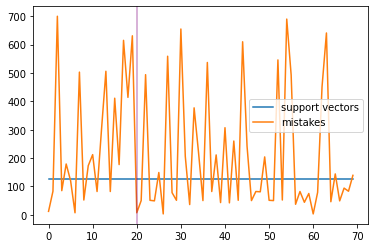

In [24]:
print(f'Mistakes {mistakes_sampling[-1]}/{len(X)} = {mistakes_sampling[-1]/len(X)*100}%')

plt.plot([len(s['betas']) for s in debug_models_sampling], label='support vectors')
plt.plot(mistakes_sampling, label='mistakes')
plt.axvline(number_of_rounds, alpha=.4, color='purple')
plt.legend()
plt.show()

In [25]:
print(f'Average mistakes: {np.average(mistakes_sampling)}')
print(f'Std mistakes: {np.std(mistakes_sampling)}')

Average mistakes: 214.7
Std mistakes: 211.78057040248055


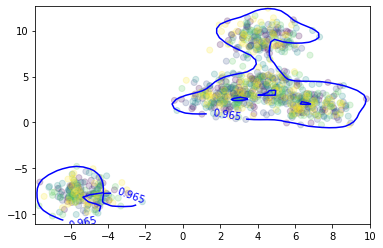

c: 0.8329644406753665, q: 0.21367652042325536
Support vectors are 77, over 1000 candidates
Mistakes 139/1000 = 13.900000000000002%


In [26]:
plot_contour(debug_sk_models_sampling[-1], colors)
print_report(debug_sk_models_sampling[-1], X)

### How does the best classifier found during the process work?

In [27]:
best_mistakes = min(mistakes_sampling)
best_mistakes_index = mistakes_sampling.index(best_mistakes)

print(f'Best mistakes {best_mistakes}/{len(X)} = {best_mistakes/len(X)*100}% at round {best_mistakes_index}/{number_of_rounds_sampling}')

Best mistakes 3/1000 = 0.3% at round 26/70


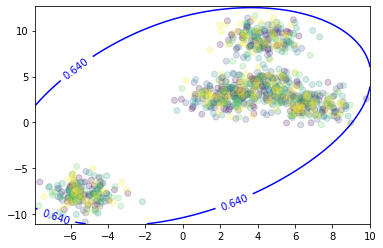

c: 0.5048518037681717, q: 0.0024745608123304505
Support vectors are 5, over 1000 candidates
Mistakes 3/1000 = 0.3%


In [28]:
plot_contour(debug_sk_models_sampling[best_mistakes_index], colors)
print_report(debug_sk_models_sampling[best_mistakes_index], X)